# Homework Assignment - DS

### Given:
You are given chunks of telemetry data of working equipment (9 sensors, 128 sec) that correspond to 6 different operating modes.
### The task:
1.	Analyze data, compute descriptive statistics, perform EDA. Assess data visually and make conclusions on operating models (classes) separability.
1.	Perform feature engineering, ideally create features that have clear meaning. Make some comments on created features, e.g. what they mean and how they can help you in the classification task.
1.	Predict operating modes of the equipment on the test data (X_test.npy), calculate precision, recall and ROC-AUC on y_test.npy. Develop 2-3 machine learning models, compare and discuss the results.
1.	If the score on any of the metric is lower than 0.92 on y_test.npy, then add some new features and aim to make the score above 0.92.

### Form of the delivery:
Please, deliver the solution in the form of a Jupyter notebook where EDA, comments and all the scores can be clearly seen.
### Timing:
Usually it takes 2 evenings, but can take up to 5 days.

---

### Solving
The task solving consists of 6 blocks:
1. Exploration data analysis (with graphs and statistical parameters);
2. Feature generation (relying on statistical parameters);
3. Models training (choosing of appropriate model);  
    3.1. XGBoost;  
    3.2. LightGBM;  
    3.3. Catboost;  
4. Feature importance analysis (choosing of usefull features);
5. Tunning of hyperparameters;
6. Neural Network models;  
    6.1 Simple dense model;  
    6.2. Convolutional model (1D and experiment with 2D);  

##### The best result was reached by LightGBM (ROC_AUC = 0.985).

In [1]:
import numpy as np
import pandas as pd

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew, kurtosis
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import warnings
warnings.filterwarnings("ignore")

In [2]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

### 1. EDA

In [3]:
# Data size
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7352, 128, 9), (7352, 6), (2947, 128, 9), (2947, 6))

In [4]:
# Fast check for NA
np.isnan(X_train).any(), np.isnan(y_train).any(), np.isnan(X_test).any(), np.isnan(y_test).any()

(False, False, False, False)

In [5]:
# Check target values and their amount
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([36760,  7352]))

In [6]:
# Check if every measure has operating mode (at least one '1' in each measure)
np.unique(np.sum(y_train, axis=1))

array([1.])

Shot summary: The target is binary. The only one operating mode can be (and should be) active at the moment (there is no hybrid modes)

In [3]:
# Combine all data into one data frame and make label encoding of target (0-5) for convinient analysis
measures = X_train.shape[0]
sensors = X_train.shape[2]

data = pd.DataFrame(columns=np.append([f'X{sensor}' for sensor in range(sensors)], ['Mode']), dtype='object')

for measure in range(measures):
    for sensor in range(sensors):
        data.at[measure, f'X{sensor}'] = X_train[measure][:, sensor]
    data.at[measure, 'Mode'] = np.argmax(y_train[measure])
data.sample(5)

X0  \
4867  [1.3430739999999999, 0.9879028, 0.7060719, 0.5...   
80    [1.0165520000000001, 0.8485091, 0.7518578, 0.7...   
6602  [0.8414558, 0.8180806, 0.8598728, 0.8784479, 0...   
1908  [1.0025819999999999, 0.9973389, 0.9941931, 0.9...   
1747  [1.02399, 1.0027059999999999, 0.9801576, 0.929...   

                                                     X1  \
4867  [-0.166521, -0.09188862, -0.1179973, -0.031030...   
80    [-0.4693631, -0.5214301, -0.4736743, -0.324127...   
6602  [-0.3809101, -0.4106359, -0.3703121, -0.315417...   
1908  [-0.1560806, -0.1527683, -0.1510924, -0.150831...   
1747  [-0.4242288, -0.3556756, -0.2339827, -0.110424...   

                                                     X2  \
4867  [-0.04234437, -0.06856382, -0.06662886, 0.0014...   
80    [-0.1547907, -0.01946882, -0.04555395, -0.0681...   
6602  [-0.09904106, -0.06418929, -0.07774104, -0.092...   
1908  [0.2126118, 0.2187176, 0.2262589, 0.2182791, 0...   
1747  [-0.2934671, -0.2059887, -0.08974435, 0.017240...   

                                                     X3  \
4867  [0.3535923, -0.0014526920000000002, -0.2832907...   
80    [0.01478672, -0.1532457, -0.249895, -0.265279,...   
6602  [-0.1369081, -0.1607704, -0.1194574, -0.101345...   
1908  [0.004299623, -0.0009625955000000001, -0.00412...   
1747  [0.05067665, 0.02871338, 0.005358765, -0.04574...   

                                                     X4  \
4867  [-0.09978196, -0.02527353, -0.05141549, 0.0356...   
80    [-0.2385266, -0.2900742, -0.2417564, -0.091596...   
6602  [-0.1068382, -0.138111, -0.09927459, -0.045802...   
1908  [-0.002977995, 0.00036663010000000004, 0.00207...   
1747  [-0.1357104, -0.06789557, 0.05306259, 0.175891...   

                                                     X5  \
4867  [0.1316412, 0.1055059, 0.1075562, 0.1757815, 0...   
80    [-0.1190291, 0.01587939, -0.01063868, -0.03369...   
6602  [0.09445695, 0.1289475, 0.1149945, 0.09970631,...   
1908  [-0.0022773339999999998, 0.003814002, 0.011340...   
1747  [-0.2866189, -0.1992732, -0.0830438, 0.0240423...   

                                                     X6  \
4867  [0.4859554, 0.7366686, 0.8676195, 0.6591409, 0...   
80    [0.2973856, 0.6444226, 0.8849052, 0.9118782, 0...   
6602  [-0.5433194, -0.5541509, -0.5674264, -0.646708...   
1908  [0.03496171, 0.03491294, 0.03265654, 0.0303994...   
1747  [-0.4169316, -0.8605723, -1.129682, -1.152185,...   

                                                     X7  \
4867  [-0.0414912, 0.2020761, 0.03372607, 0.01066396...   
80    [-0.9486616, -0.9744048, -1.006967, -1.246464,...   
6602  [0.1622027, 0.08766012, 0.08927167, 0.1376378,...   
1908  [-0.00818589, -0.01208608, -0.009884322, -0.00...   
1747  [2.514384, 1.6737509999999998, 0.8937431, 0.51...   

                                                     X8 Mode  
4867  [0.2354133, 0.5013612, 0.694782, 0.6263759, 0....    2  
80    [0.03721682, -0.3616981, -0.4051889, -0.285840...    0  
6602  [0.3551773, 0.1969826, 0.06985043, 0.03377559,...    1  
1908  [0.02000843, 0.01217841, 0.012691, 0.01531596,...    4  
1747  [0.408977, 0.07430421, 0.1223651, 0.5160795, 0...    1

Class: 0


Class: 1


Class: 2


Class: 3


Class: 4


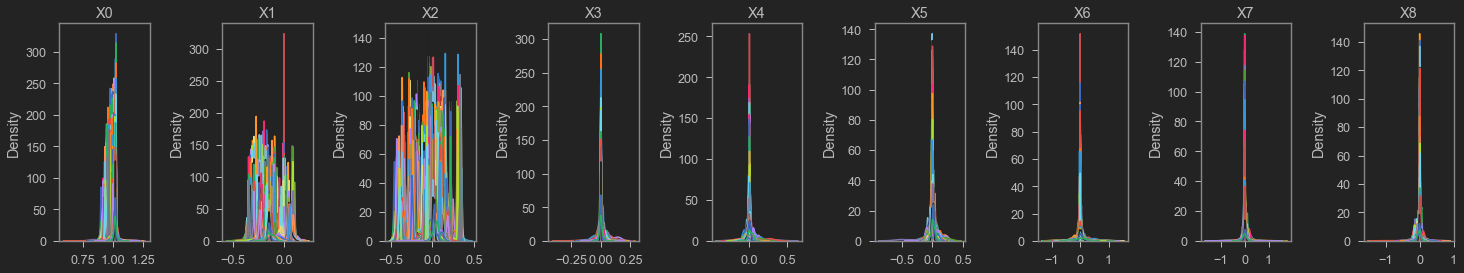

Class: 5


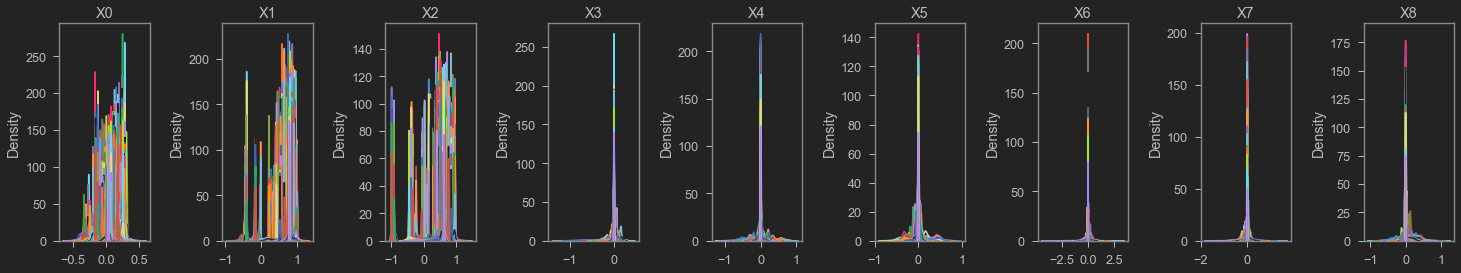

In [8]:
# "Quick look" sensor distribution graphs depending on target
for k in range(y_train.shape[1]):
    plt.figure(figsize=(25, 4))
    print(f'Class: {k}')
    selected = data.loc[data['Mode'] == k, :].drop(columns=['Mode']).reset_index(drop=True)
    for i in range(selected.shape[0]):
        for j in range(sensors):
            plt.subplot(int(f'1{sensors}{j+1}'))
            plt.title(f'X{j}')
            sns.kdeplot(selected.loc[i, f'X{j}'])
            plt.subplots_adjust(wspace=0.8)
    plt.show()

Sensors distribution for different operating modes has obvious differentiation between groups 0-2 and 3-5. Inside these groups the difference is less but can be detected relying on separate sensors.  
Let's compare them in detail on graphs with grouped measures with target differentiation.

In [4]:
merged_sensors_data = pd.DataFrame(columns=data.columns)

for k in range(y_train.shape[1]):
    selected = data.loc[data['Mode'] == k, :].drop(columns=['Mode'])
    _merged_sensors_data = pd.DataFrame()
    for i in range(sensors):
        _merged_sensors_data[f'X{i}'] = [item for sublist in selected.loc[:, f'X{i}'].values for item in sublist]
    _merged_sensors_data['Mode'] = k
    merged_sensors_data = pd.concat([merged_sensors_data, _merged_sensors_data], axis=0, ignore_index=True)

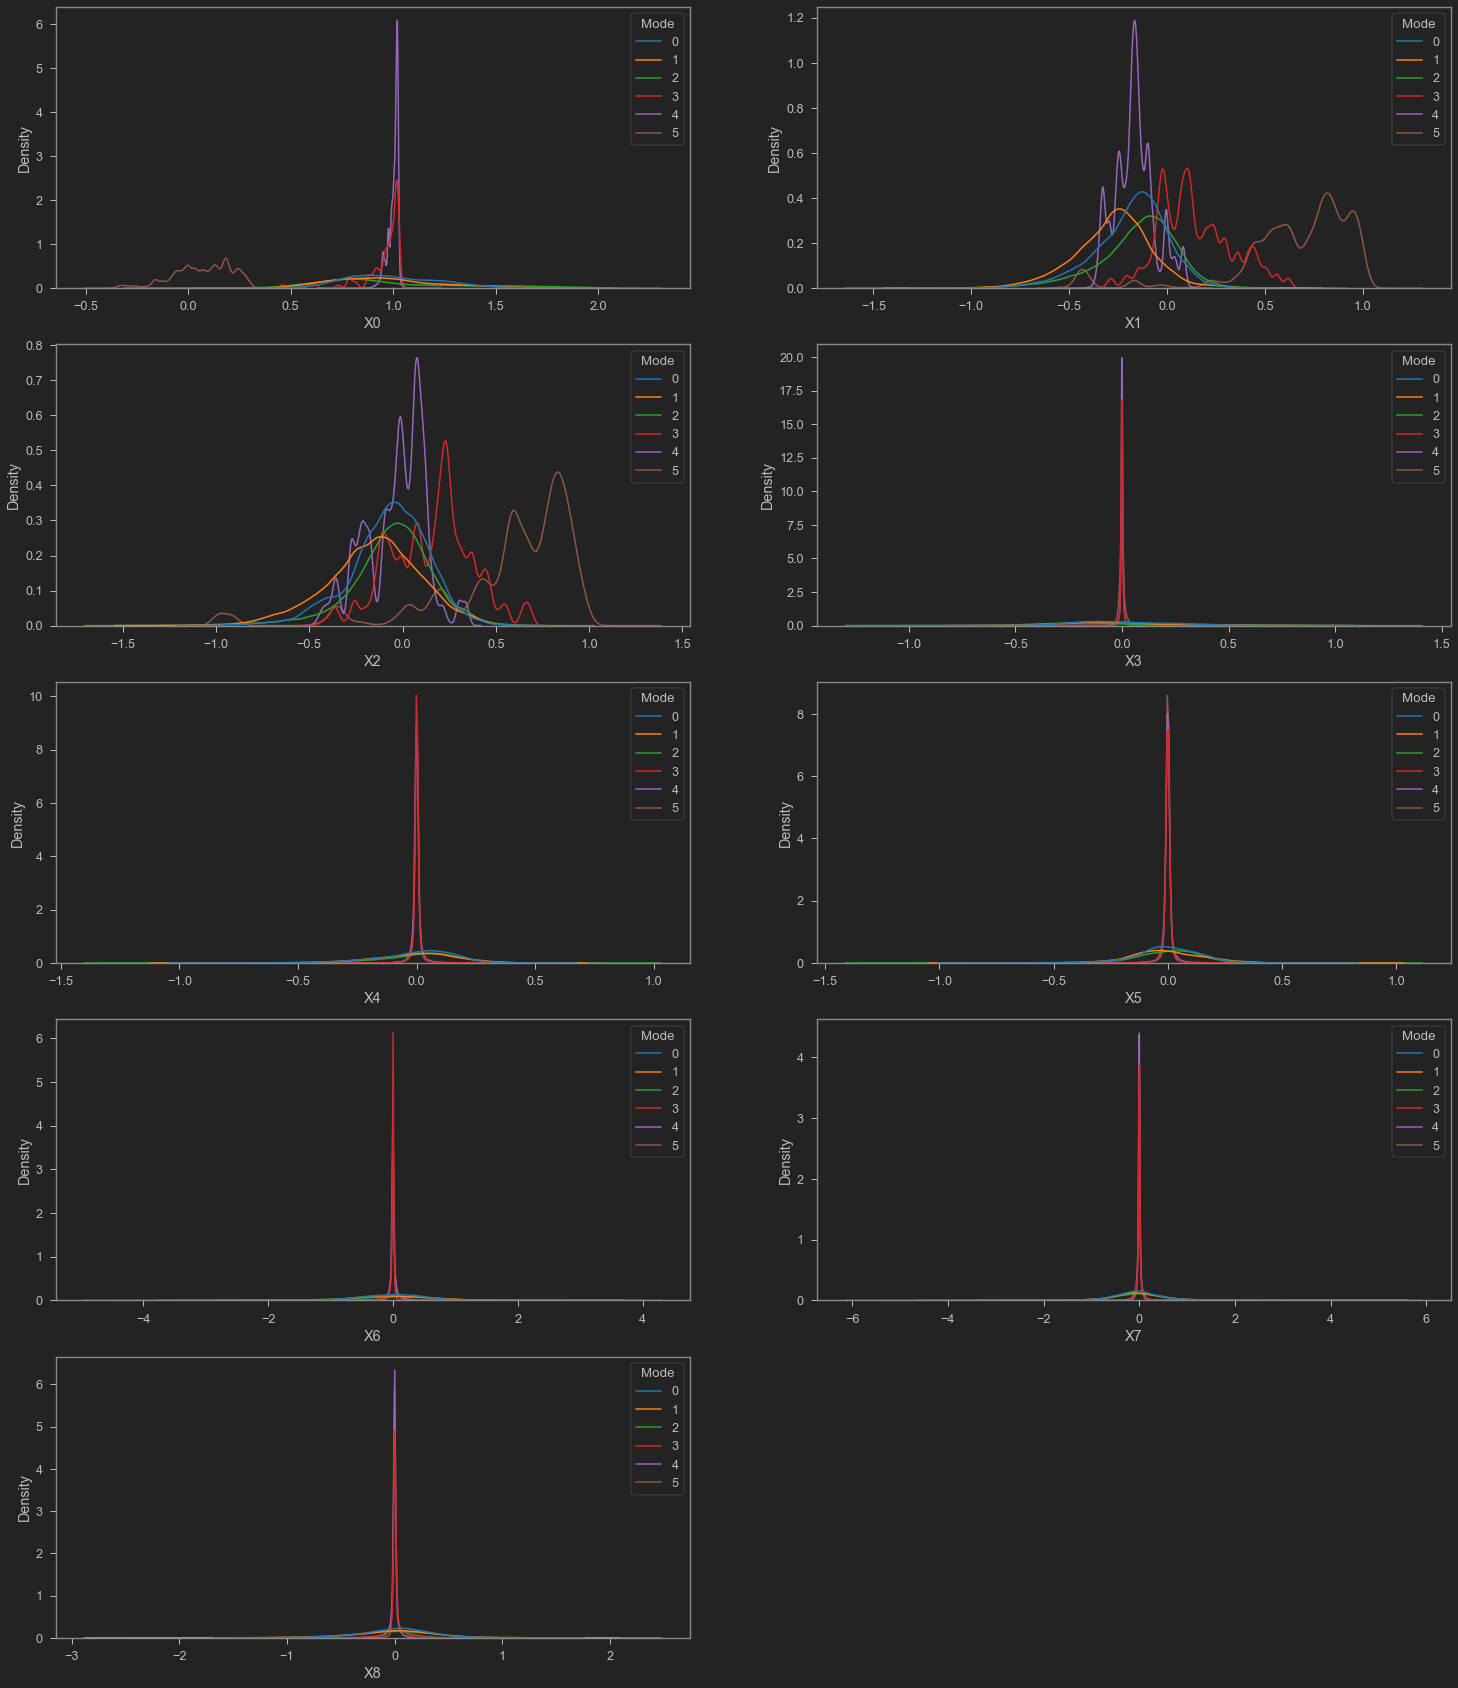

In [10]:
plt.figure(figsize=(25, 30))
for j in range(sensors):
    plt.subplot(int(f'{int(np.ceil(sensors/2))}2{j+1}'))
    sns.kdeplot(merged_sensors_data[f'X{j}'], hue=merged_sensors_data['Mode'], palette='tab10')
plt.show()

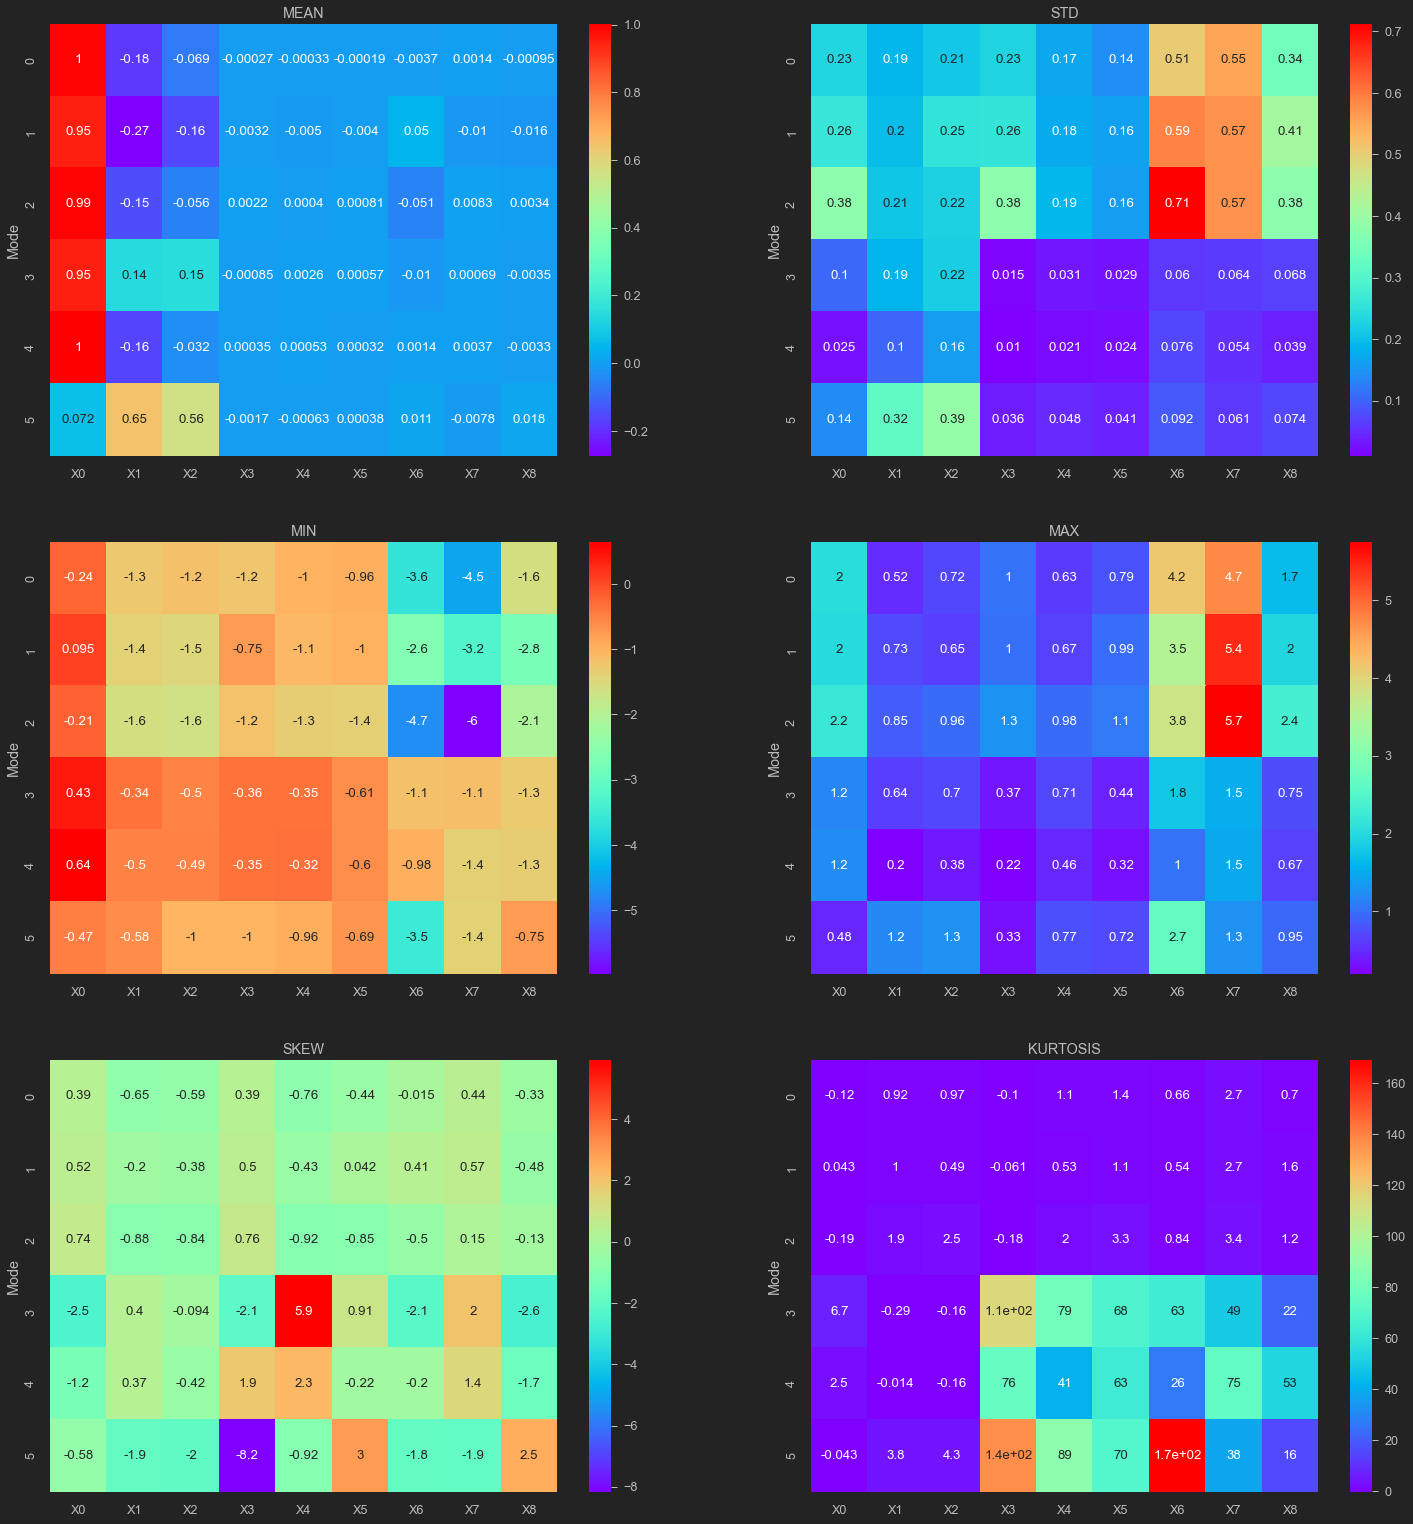

In [18]:
# Main statistics of combined data separated on sensors and target
plt.figure(figsize=(25, 27))
sns.set(font_scale=0.9)
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

plt.subplot(321)
plt.title('MEAN')
sns.heatmap(merged_sensors_data.groupby('Mode').agg(np.mean), annot=True, fmt='.2g', cmap='rainbow')

plt.subplot(322)
plt.title('STD')
sns.heatmap(merged_sensors_data.groupby('Mode').agg(np.std), annot=True, fmt='.2g', cmap='rainbow')

plt.subplot(323)
plt.title('MIN')
sns.heatmap(merged_sensors_data.groupby('Mode').agg(np.min), annot=True, fmt='.2g', cmap='rainbow')

plt.subplot(324)
plt.title('MAX')
sns.heatmap(merged_sensors_data.groupby('Mode').agg(np.max), annot=True, fmt='.2g', cmap='rainbow')

plt.subplot(325)
plt.title('SKEW')
sns.heatmap(merged_sensors_data.groupby('Mode').agg(skew), annot=True, fmt='.2g', cmap='rainbow')

plt.subplot(326)
plt.title('KURTOSIS')
sns.heatmap(merged_sensors_data.groupby('Mode').agg(kurtosis), annot=True, fmt='.2g', cmap='rainbow')

plt.show()

The first 3 sensors reflect a good class differentiation and probably has a high importance for classification. Two different groups can be seen on heatmaps as well as on histogramms above: 0-2 and 3-5. The differentian inside these group assumed more complex, except class 5 that can be easily selected by mean value and partially by 3-d and 4-th distribution moments (skew, kurtosis).

### 2. Features generation

In [5]:
def make_statistical_features(x: np.ndarray, y: np.ndarray) -> pd.DataFrame:
    """
    Method creates dataframe with main statistical features and label-encoded target
    
    :param x: input X data
    :param y: input Y data
    
    :return:  DataFrame with statistical features (mean, std, min, max, skew, kurtosis) and label-encoded target
    """
    measures = x.shape[0]
    sensors = x.shape[2]

    data = pd.DataFrame()

    for measure in range(measures):
        for sensor in range(sensors):
            data.at[measure, f'X{sensor}_mean'] = x[measure][:, sensor].mean()
            data.at[measure, f'X{sensor}_std'] = x[measure][:, sensor].std()
            data.at[measure, f'X{sensor}_min'] = x[measure][:, sensor].min()
            data.at[measure, f'X{sensor}_max'] = x[measure][:, sensor].max()
            data.at[measure, f'X{sensor}_skew'] = skew(x[measure][:, sensor])
            data.at[measure, f'X{sensor}_kurtosis'] = kurtosis(x[measure][:, sensor])
        data.at[measure, 'Mode'] = np.argmax(y[measure])
        
    return data

In [6]:
data = make_statistical_features(X_train, y_train)
data_test = make_statistical_features(X_test, y_test)

In [21]:
data.describe()

X0_mean       X0_std       X0_min       X0_max      X0_skew  \
count  7352.000000  7352.000000  7352.000000  7352.000000  7352.000000   
mean      0.804749     0.127444     0.585812     1.124611     0.252625   
std       0.366131     0.145657     0.350926     0.608197     0.608891   
min      -0.370700     0.001340    -0.466556    -0.314170    -4.998284   
25%       0.902589     0.003414     0.355264     0.960782    -0.066109   
50%       0.983997     0.013844     0.583927     1.035682     0.279333   
75%       1.011098     0.245544     0.961749     1.607995     0.617601   
max       1.055335     0.648704     1.022497     2.197618     4.598368   

       X0_kurtosis      X1_mean       X1_std       X1_min       X1_max  ...  \
count  7352.000000  7352.000000  7352.000000  7352.000000  7352.000000  ...   
mean      0.420665     0.028755     0.082753    -0.215919     0.196441  ...   
std       2.169400     0.372431     0.085700     0.562020     0.319585  ...   
min      -1.757722    -0.494512     0.001510    -1.582079    -0.444567  ...   
25%      -0.593393    -0.220897     0.004724    -0.679154    -0.012442  ...   
50%      -0.115440    -0.124932     0.019710    -0.257903     0.120476  ...   
75%       0.563116     0.167153     0.164297     0.124988     0.335699  ...   
max      36.319504     1.005326     0.369380     0.993726     1.217350  ...   

            X7_max      X7_skew  X7_kurtosis      X8_mean       X8_std  \
count  7352.000000  7352.000000  7352.000000  7352.000000  7352.000000   
mean      0.662617     0.073922     0.634860     0.000113     0.168811   
std       0.812211     0.711957     2.395687     0.061655     0.181965   
min      -0.113510    -4.828877    -1.691743    -0.437807     0.002184   
25%       0.032473    -0.262910    -0.531307    -0.009825     0.008548   
50%       0.185343     0.078837     0.004811    -0.000097     0.055189   
75%       1.135222     0.424324     0.908982     0.010297     0.324051   
max       5.746062     5.855399    37.054641     0.404380     0.966791   

            X8_min       X8_max      X8_skew  X8_kurtosis         Mode  
count  7352.000000  7352.000000  7352.000000  7352.000000  7352.000000  
mean     -0.412911     0.373870    -0.096738     0.339675     2.643362  
std       0.464741     0.408455     0.670599     1.973948     1.744802  
min      -2.763014    -0.239766    -4.715350    -1.598391     0.000000  
25%      -0.780125     0.018764    -0.424022    -0.606754     1.000000  
50%      -0.130487     0.146145    -0.095553    -0.127587     3.000000  
75%      -0.017546     0.681101     0.247330     0.609811     4.000000  
max       0.247760     2.365982     5.290280    34.262329     5.000000  

[8 rows x 55 columns]

In [7]:
# Prepare x, y data for models
X_train_df = data.drop(columns='Mode')
y_train_df = data['Mode']
X_test_df = data_test.drop(columns='Mode')
y_test_df = data_test['Mode']

### 3. Models training

In [8]:
def display_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    """
    Method displays main metrics and confusion matrix
    
    :y_true: true labels
    :y_pred: predicted probabilities
    
    :return: print results (precision, recall, accuracy, roc-auc, conf. matrix)
    """
    print(classification_report(y_true.values, np.argmax(y_pred, axis=1)))
    print('')
    print(f'ROC-AUC Score: {roc_auc_score(y_true.values, y_pred, multi_class="ovo"):.3}')
    
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, np.argmax(y_pred, axis=1)), display_labels=np.arange(6))
    disp.plot( values_format ='.3g')
    plt.show()

#### 3.1. XGB Model

In [24]:
xgb_params = {"booster": "gbtree",
              "objective": "multi:softprob",
              "eval_metric": "auc",
              "learning_rate": 0.1,
              "n_estimators": 1000,
              "num_class": 6,
              "reg_lambda": 50,
              "max_depth": 5,
              "max_leaves": 10,
              "nthread": 5,
              "seed": 32,
             }

In [11]:
# Create 20% of validation data selection
X_train_df_part, X_valid_df_part, y_train_df_part, y_valid_df_part = train_test_split(X_train_df, y_train_df, test_size=0.2, random_state=32)
X_train_df_part.shape, X_valid_df_part.shape, y_train_df_part.shape, y_valid_df_part.shape

((5881, 54), (1471, 54), (5881,), (1471,))

In [26]:
dm_test = xgb.DMatrix(data=X_test_df, label=y_test_df)
dm_train = xgb.DMatrix(data=X_train_df_part, label=y_train_df_part)
dm_valid = xgb.DMatrix(data=X_valid_df_part, label=y_valid_df_part)

In [27]:
xgb_model = xgb.train(params=xgb_params,
                      dtrain=dm_train,
                      num_boost_round=200,
                      early_stopping_rounds=20,
                      evals=[(dm_train, "train"), (dm_valid, "valid")],
                      verbose_eval=20,
                      maximize=True,
                     )

[17:59:57] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.98854	valid-auc:0.98448
[20]	train-auc:0.99778	valid-auc:0.99589
[40]	train-auc:0.99924	valid-auc:0.99770
[60]	train-auc:0.99978	valid-auc:0.99861
[80]	train-auc:0.99993	valid-auc:0.99905
[100]	train-auc:0.99997	valid-auc:0.99927
[120]	train-auc:0.99999	valid-auc:0.99941
[140]	train-auc:1.00000	valid-auc:0.99950
[160]	train-auc:1.00000	valid-auc:0.99957
[180]	train-auc:1.00000	valid-auc:0.99961
[199]	train-auc:1.00000	valid-auc:0.99965


In [28]:
pred = xgb_model.predict(dm_test)
y_test.shape, pred.shape

((2947, 6), (2947, 6))

In [31]:
# Display main quality parameters, ROC-AUC score and confusion matrix
display_metrics(y_test_df, pred)

              precision    recall  f1-score   support

         0.0       0.72      0.77      0.75       496
         1.0       0.76      0.75      0.76       471
         2.0       0.87      0.83      0.85       420
         3.0       0.93      0.85      0.88       491
         4.0       0.87      0.94      0.90       532
         5.0       1.00      1.00      1.00       537

    accuracy                           0.86      2947
   macro avg       0.86      0.86      0.86      2947
weighted avg       0.86      0.86      0.86      2947


ROC-AUC Score: 0.984


Good result! As it was declared above, we have two different groups of classes (0-2 and 3-5) with more complicated classification inside them (except 5-th class that easily separates from other).  
Lets try to use another boosting-type models.

#### 3.2. LightGBM Model

In [32]:
lgb_params = {"metric": "auc_mu",
              "learning_rate": 0.1,
              "n_estimators": 1000,
              "reg_lambda": 50,
              "max_depth": 5,
              "num_leaves": 10,
              "seed": 32,
             }

In [33]:
lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(X_train_df_part, y_train_df_part, 
              early_stopping_rounds=20, 
              eval_set=[(X_train_df_part, y_train_df_part), (X_valid_df_part, y_valid_df_part)],
              verbose=20)

[20]	training's auc_mu: 0.998203	valid_1's auc_mu: 0.997142
[40]	training's auc_mu: 0.999491	valid_1's auc_mu: 0.998697
[60]	training's auc_mu: 0.999853	valid_1's auc_mu: 0.999207
[80]	training's auc_mu: 0.999945	valid_1's auc_mu: 0.99942
[100]	training's auc_mu: 0.999978	valid_1's auc_mu: 0.99952
[120]	training's auc_mu: 0.999992	valid_1's auc_mu: 0.999601
[140]	training's auc_mu: 0.999996	valid_1's auc_mu: 0.999668
[160]	training's auc_mu: 0.999998	valid_1's auc_mu: 0.999714
[180]	training's auc_mu: 0.999999	valid_1's auc_mu: 0.999744
[200]	training's auc_mu: 1	valid_1's auc_mu: 0.99977
[220]	training's auc_mu: 1	valid_1's auc_mu: 0.999784
[240]	training's auc_mu: 1	valid_1's auc_mu: 0.999799
[260]	training's auc_mu: 1	valid_1's auc_mu: 0.999807
[280]	training's auc_mu: 1	valid_1's auc_mu: 0.999816
[300]	training's auc_mu: 1	valid_1's auc_mu: 0.999819
[320]	training's auc_mu: 1	valid_1's auc_mu: 0.99982
[340]	training's auc_mu: 1	valid_1's auc_mu: 0.999825
[360]	training's auc_mu: 1	

LGBMClassifier(max_depth=5, metric='auc_mu', n_estimators=1000, num_leaves=10,
               reg_lambda=50, seed=32)

In [34]:
pred = lgb_model.predict_proba(X_test_df)
y_test.shape, pred.shape

((2947, 6), (2947, 6))

              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76       496
         1.0       0.78      0.76      0.77       471
         2.0       0.87      0.84      0.85       420
         3.0       0.93      0.84      0.88       491
         4.0       0.87      0.94      0.90       532
         5.0       1.00      1.00      1.00       537

    accuracy                           0.86      2947
   macro avg       0.86      0.86      0.86      2947
weighted avg       0.87      0.86      0.86      2947


ROC-AUC Score: 0.984


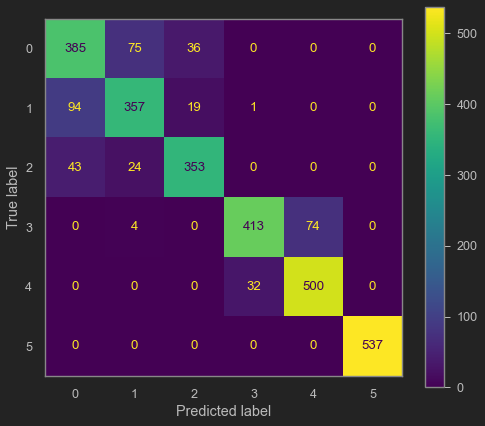

In [35]:
# Display main quality parameters, ROC-AUC score and confusion matrix
display_metrics(y_test_df, pred)

The result is close to XGB but precision and recall metrics a bit better.

#### 3.3. Catboost Model

In [36]:
cb_params = {"objective": "MultiClass",
             "eval_metric": "AUC",
             "learning_rate": 0.1,
             "n_estimators": 1000,
             "reg_lambda": 50,
             "max_depth": 5,
             "thread_count": 5,
             "random_seed": 32,
            }

In [37]:
p_train = cb.Pool(data=X_train_df_part, label=y_train_df_part)
p_valid = cb.Pool(data=X_valid_df_part, label=y_valid_df_part)

In [38]:
cb_model = cb.CatBoostClassifier(**cb_params)
cb_model.fit(p_train, 
             early_stopping_rounds=20,
             eval_set=[p_train, p_valid])

0:	test: 0.9632981	test1: 0.9662986	best: 0.9662986 (0)	total: 95.4ms	remaining: 1m 35s
1:	test: 0.9748859	test1: 0.9771175	best: 0.9771175 (1)	total: 109ms	remaining: 54.3s
2:	test: 0.9765550	test1: 0.9785953	best: 0.9785953 (2)	total: 121ms	remaining: 40s
3:	test: 0.9780899	test1: 0.9799698	best: 0.9799698 (3)	total: 133ms	remaining: 33.1s
4:	test: 0.9797641	test1: 0.9816946	best: 0.9816946 (4)	total: 145ms	remaining: 28.8s
5:	test: 0.9815481	test1: 0.9833940	best: 0.9833940 (5)	total: 156ms	remaining: 25.9s
6:	test: 0.9818737	test1: 0.9829910	best: 0.9833940 (5)	total: 168ms	remaining: 23.9s
7:	test: 0.9833410	test1: 0.9844402	best: 0.9844402 (7)	total: 182ms	remaining: 22.5s
8:	test: 0.9836239	test1: 0.9846146	best: 0.9846146 (8)	total: 197ms	remaining: 21.7s
9:	test: 0.9847508	test1: 0.9861058	best: 0.9861058 (9)	total: 211ms	remaining: 20.9s
10:	test: 0.9857976	test1: 0.9869650	best: 0.9869650 (10)	total: 226ms	remaining: 20.4s
11:	test: 0.9865693	test1: 0.9876645	best: 0.9876645

95:	test: 0.9969338	test1: 0.9967159	best: 0.9967269 (93)	total: 1.54s	remaining: 14.5s
96:	test: 0.9969832	test1: 0.9967654	best: 0.9967654 (96)	total: 1.55s	remaining: 14.5s
97:	test: 0.9970536	test1: 0.9968532	best: 0.9968532 (97)	total: 1.57s	remaining: 14.4s
98:	test: 0.9971282	test1: 0.9969406	best: 0.9969406 (98)	total: 1.58s	remaining: 14.4s
99:	test: 0.9971517	test1: 0.9969638	best: 0.9969638 (99)	total: 1.6s	remaining: 14.4s
100:	test: 0.9971583	test1: 0.9969641	best: 0.9969641 (100)	total: 1.61s	remaining: 14.4s
101:	test: 0.9971901	test1: 0.9969866	best: 0.9969866 (101)	total: 1.63s	remaining: 14.4s
102:	test: 0.9972349	test1: 0.9970178	best: 0.9970178 (102)	total: 1.65s	remaining: 14.3s
103:	test: 0.9972501	test1: 0.9970332	best: 0.9970332 (103)	total: 1.66s	remaining: 14.3s
104:	test: 0.9972940	test1: 0.9970505	best: 0.9970505 (104)	total: 1.68s	remaining: 14.3s
105:	test: 0.9973298	test1: 0.9970886	best: 0.9970886 (105)	total: 1.69s	remaining: 14.3s
106:	test: 0.9973694	

193:	test: 0.9988361	test1: 0.9983034	best: 0.9983034 (193)	total: 3s	remaining: 12.5s
194:	test: 0.9988435	test1: 0.9983014	best: 0.9983034 (193)	total: 3.01s	remaining: 12.4s
195:	test: 0.9988493	test1: 0.9983049	best: 0.9983049 (195)	total: 3.03s	remaining: 12.4s
196:	test: 0.9988555	test1: 0.9983123	best: 0.9983123 (196)	total: 3.05s	remaining: 12.4s
197:	test: 0.9988641	test1: 0.9983134	best: 0.9983134 (197)	total: 3.06s	remaining: 12.4s
198:	test: 0.9988754	test1: 0.9983168	best: 0.9983168 (198)	total: 3.08s	remaining: 12.4s
199:	test: 0.9988816	test1: 0.9983242	best: 0.9983242 (199)	total: 3.09s	remaining: 12.4s
200:	test: 0.9988860	test1: 0.9983202	best: 0.9983242 (199)	total: 3.11s	remaining: 12.4s
201:	test: 0.9988886	test1: 0.9983251	best: 0.9983251 (201)	total: 3.12s	remaining: 12.3s
202:	test: 0.9989003	test1: 0.9983422	best: 0.9983422 (202)	total: 3.14s	remaining: 12.3s
203:	test: 0.9989045	test1: 0.9983445	best: 0.9983445 (203)	total: 3.16s	remaining: 12.3s
204:	test: 0.

292:	test: 0.9994080	test1: 0.9987712	best: 0.9987712 (292)	total: 4.43s	remaining: 10.7s
293:	test: 0.9994072	test1: 0.9987726	best: 0.9987726 (293)	total: 4.44s	remaining: 10.7s
294:	test: 0.9994096	test1: 0.9987704	best: 0.9987726 (293)	total: 4.46s	remaining: 10.6s
295:	test: 0.9994158	test1: 0.9987788	best: 0.9987788 (295)	total: 4.47s	remaining: 10.6s
296:	test: 0.9994184	test1: 0.9987839	best: 0.9987839 (296)	total: 4.48s	remaining: 10.6s
297:	test: 0.9994210	test1: 0.9987838	best: 0.9987839 (296)	total: 4.5s	remaining: 10.6s
298:	test: 0.9994268	test1: 0.9987914	best: 0.9987914 (298)	total: 4.51s	remaining: 10.6s
299:	test: 0.9994309	test1: 0.9987921	best: 0.9987921 (299)	total: 4.53s	remaining: 10.6s
300:	test: 0.9994316	test1: 0.9987977	best: 0.9987977 (300)	total: 4.54s	remaining: 10.6s
301:	test: 0.9994348	test1: 0.9987997	best: 0.9987997 (301)	total: 4.56s	remaining: 10.5s
302:	test: 0.9994371	test1: 0.9988036	best: 0.9988036 (302)	total: 4.57s	remaining: 10.5s
303:	test: 

388:	test: 0.9996564	test1: 0.9990348	best: 0.9990370 (386)	total: 5.86s	remaining: 9.21s
389:	test: 0.9996564	test1: 0.9990348	best: 0.9990370 (386)	total: 5.88s	remaining: 9.19s
390:	test: 0.9996568	test1: 0.9990367	best: 0.9990370 (386)	total: 5.89s	remaining: 9.17s
391:	test: 0.9996590	test1: 0.9990391	best: 0.9990391 (391)	total: 5.9s	remaining: 9.16s
392:	test: 0.9996609	test1: 0.9990418	best: 0.9990418 (392)	total: 5.92s	remaining: 9.15s
393:	test: 0.9996631	test1: 0.9990406	best: 0.9990418 (392)	total: 5.94s	remaining: 9.14s
394:	test: 0.9996659	test1: 0.9990457	best: 0.9990457 (394)	total: 5.96s	remaining: 9.12s
395:	test: 0.9996661	test1: 0.9990448	best: 0.9990457 (394)	total: 5.97s	remaining: 9.11s
396:	test: 0.9996676	test1: 0.9990448	best: 0.9990457 (394)	total: 5.99s	remaining: 9.09s
397:	test: 0.9996676	test1: 0.9990443	best: 0.9990457 (394)	total: 6s	remaining: 9.08s
398:	test: 0.9996679	test1: 0.9990456	best: 0.9990457 (394)	total: 6.02s	remaining: 9.07s
399:	test: 0.9

483:	test: 0.9997680	test1: 0.9991615	best: 0.9991615 (483)	total: 7.32s	remaining: 7.8s
484:	test: 0.9997695	test1: 0.9991625	best: 0.9991625 (484)	total: 7.34s	remaining: 7.79s
485:	test: 0.9997699	test1: 0.9991625	best: 0.9991625 (484)	total: 7.35s	remaining: 7.78s
486:	test: 0.9997718	test1: 0.9991613	best: 0.9991625 (484)	total: 7.37s	remaining: 7.76s
487:	test: 0.9997745	test1: 0.9991662	best: 0.9991662 (487)	total: 7.39s	remaining: 7.75s
488:	test: 0.9997750	test1: 0.9991732	best: 0.9991732 (488)	total: 7.4s	remaining: 7.73s
489:	test: 0.9997760	test1: 0.9991752	best: 0.9991752 (489)	total: 7.42s	remaining: 7.72s
490:	test: 0.9997763	test1: 0.9991720	best: 0.9991752 (489)	total: 7.43s	remaining: 7.7s
491:	test: 0.9997762	test1: 0.9991730	best: 0.9991752 (489)	total: 7.45s	remaining: 7.69s
492:	test: 0.9997769	test1: 0.9991762	best: 0.9991762 (492)	total: 7.46s	remaining: 7.67s
493:	test: 0.9997779	test1: 0.9991797	best: 0.9991797 (493)	total: 7.48s	remaining: 7.66s
494:	test: 0.

583:	test: 0.9998473	test1: 0.9992932	best: 0.9992932 (582)	total: 8.78s	remaining: 6.25s
584:	test: 0.9998476	test1: 0.9992952	best: 0.9992952 (584)	total: 8.79s	remaining: 6.24s
585:	test: 0.9998476	test1: 0.9992965	best: 0.9992965 (585)	total: 8.81s	remaining: 6.22s
586:	test: 0.9998480	test1: 0.9993000	best: 0.9993000 (586)	total: 8.83s	remaining: 6.21s
587:	test: 0.9998487	test1: 0.9993010	best: 0.9993010 (587)	total: 8.84s	remaining: 6.19s
588:	test: 0.9998488	test1: 0.9993010	best: 0.9993010 (587)	total: 8.85s	remaining: 6.18s
589:	test: 0.9998500	test1: 0.9993048	best: 0.9993048 (589)	total: 8.87s	remaining: 6.16s
590:	test: 0.9998506	test1: 0.9993084	best: 0.9993084 (590)	total: 8.88s	remaining: 6.15s
591:	test: 0.9998505	test1: 0.9993077	best: 0.9993084 (590)	total: 8.9s	remaining: 6.13s
592:	test: 0.9998506	test1: 0.9993055	best: 0.9993084 (590)	total: 8.91s	remaining: 6.12s
593:	test: 0.9998511	test1: 0.9993071	best: 0.9993084 (590)	total: 8.93s	remaining: 6.1s
594:	test: 0

678:	test: 0.9998948	test1: 0.9993697	best: 0.9993697 (678)	total: 10.2s	remaining: 4.84s
679:	test: 0.9998948	test1: 0.9993697	best: 0.9993697 (678)	total: 10.2s	remaining: 4.82s
680:	test: 0.9998949	test1: 0.9993707	best: 0.9993707 (680)	total: 10.3s	remaining: 4.81s
681:	test: 0.9998950	test1: 0.9993707	best: 0.9993707 (680)	total: 10.3s	remaining: 4.79s
682:	test: 0.9998962	test1: 0.9993727	best: 0.9993727 (682)	total: 10.3s	remaining: 4.78s
683:	test: 0.9998962	test1: 0.9993701	best: 0.9993727 (682)	total: 10.3s	remaining: 4.76s
684:	test: 0.9998960	test1: 0.9993747	best: 0.9993747 (684)	total: 10.3s	remaining: 4.75s
685:	test: 0.9998963	test1: 0.9993738	best: 0.9993747 (684)	total: 10.3s	remaining: 4.74s
686:	test: 0.9998968	test1: 0.9993740	best: 0.9993747 (684)	total: 10.4s	remaining: 4.72s
687:	test: 0.9998971	test1: 0.9993738	best: 0.9993747 (684)	total: 10.4s	remaining: 4.7s
688:	test: 0.9998975	test1: 0.9993728	best: 0.9993747 (684)	total: 10.4s	remaining: 4.69s
689:	test: 

775:	test: 0.9999251	test1: 0.9994301	best: 0.9994301 (774)	total: 11.7s	remaining: 3.37s
776:	test: 0.9999252	test1: 0.9994289	best: 0.9994301 (774)	total: 11.7s	remaining: 3.36s
777:	test: 0.9999253	test1: 0.9994286	best: 0.9994301 (774)	total: 11.7s	remaining: 3.34s
778:	test: 0.9999256	test1: 0.9994299	best: 0.9994301 (774)	total: 11.7s	remaining: 3.33s
779:	test: 0.9999259	test1: 0.9994280	best: 0.9994301 (774)	total: 11.7s	remaining: 3.31s
780:	test: 0.9999261	test1: 0.9994280	best: 0.9994301 (774)	total: 11.8s	remaining: 3.3s
781:	test: 0.9999254	test1: 0.9994332	best: 0.9994332 (781)	total: 11.8s	remaining: 3.28s
782:	test: 0.9999253	test1: 0.9994351	best: 0.9994351 (782)	total: 11.8s	remaining: 3.27s
783:	test: 0.9999258	test1: 0.9994353	best: 0.9994353 (783)	total: 11.8s	remaining: 3.25s
784:	test: 0.9999266	test1: 0.9994333	best: 0.9994353 (783)	total: 11.8s	remaining: 3.23s
785:	test: 0.9999266	test1: 0.9994310	best: 0.9994353 (783)	total: 11.8s	remaining: 3.22s
786:	test: 

In [39]:
pred = cb_model.predict_proba(X_test_df)
y_test.shape, pred.shape

((2947, 6), (2947, 6))

In [40]:
# Display main quality parameters, ROC-AUC score and confusion matrix
display_metrics(y_test_df, pred)

              precision    recall  f1-score   support

         0.0       0.71      0.77      0.74       496
         1.0       0.77      0.75      0.76       471
         2.0       0.87      0.80      0.84       420
         3.0       0.91      0.79      0.85       491
         4.0       0.83      0.93      0.88       532
         5.0       1.00      1.00      1.00       537

    accuracy                           0.85      2947
   macro avg       0.85      0.84      0.84      2947
weighted avg       0.85      0.85      0.85      2947


ROC-AUC Score: 0.982


Catboost model has the less metrics...

### 4. Feature importance analysis

Not all features are equally usefull! Let's make model more effective, filter useless features.  
There are few methods to check feature importance. I preffer permutation importance and shaply and I used the first one in the task.

In [45]:
importance = permutation_importance(lgb_model, X_valid_df_part, y_valid_df_part, scoring="roc_auc_ovo", n_jobs=-1, random_state=32)

In [46]:
importance_scores = pd.DataFrame({"features": X_valid_df_part.columns,
                                  "importance-mean": importance.importances_mean,
                                  "importance-std": importance.importances_std})
importance_scores = importance_scores.sort_values(by="importance-mean", ascending=False)
importance_scores = importance_scores.reset_index(drop=True)
importance_scores

features  importance-mean  importance-std
0       X0_mean     4.139464e-02    1.123226e-03
1       X1_mean     8.125413e-03    8.232170e-04
2        X3_std     1.067702e-03    2.240813e-04
3        X6_max     6.035746e-04    1.185621e-04
4        X6_std     3.886345e-04    1.464545e-04
5       X2_mean     3.187120e-04    2.595711e-05
6        X0_min     2.508922e-04    9.753255e-05
7        X6_min     2.186520e-04    6.963972e-05
8        X1_max     2.108922e-04    4.821782e-05
9        X3_max     1.357835e-04    7.841684e-05
10       X7_std     1.220288e-04    3.780726e-05
11       X2_min     1.112367e-04    1.189126e-05
12      X1_skew     8.951655e-05    2.605373e-05
13      X6_mean     8.944055e-05    9.175943e-06
14      X3_skew     8.576520e-05    4.163054e-06
15       X7_max     7.330395e-05    1.524887e-05
16       X2_max     6.811127e-05    2.212174e-05
17      X0_skew     6.252585e-05    7.357060e-06
18       X0_std     6.208449e-05    7.715299e-06
19  X6_kurtosis     6.105382e-05    5.093400e-06
20       X2_std     5.797191e-05    3.396979e-05
21       X1_min     5.749423e-05    2.081973e-05
22       X7_min     5.642483e-05    1.453334e-05
23       X8_min     4.058753e-05    7.946994e-06
24       X0_max     3.891179e-05    9.999561e-06
25  X8_kurtosis     3.629078e-05    6.240549e-06
26      X5_skew     3.405050e-05    9.259087e-06
27      X4_skew     3.147668e-05    1.728086e-05
28       X8_max     3.062328e-05    5.339381e-06
29      X2_skew     2.942706e-05    1.391632e-05
30      X8_mean     2.408627e-05    9.240718e-06
31       X8_std     2.215888e-05    6.077515e-06
32       X5_min     2.066983e-05    4.139913e-06
33  X1_kurtosis     1.999702e-05    5.780840e-06
34       X3_min     1.905706e-05    4.278905e-06
35      X7_mean     1.489716e-05    3.919145e-06
36       X4_max     1.403218e-05    3.590836e-06
37      X5_mean     1.385926e-05    9.818703e-07
38      X8_skew     1.376768e-05    3.224157e-06
39      X7_skew     1.026080e-05    3.098373e-06
40       X1_std     9.585893e-06    3.156472e-06
41      X6_skew     7.290794e-06    7.253703e-06
42       X4_min     7.276515e-06    1.278256e-05
43      X3_mean     6.124616e-06    5.959103e-06
44  X5_kurtosis     4.272960e-06    1.634070e-06
45       X5_max     3.001667e-06    1.060446e-05
46      X4_mean     1.824035e-06    2.342093e-06
47  X0_kurtosis     2.926687e-07    4.636649e-06
48       X5_std    -3.078335e-06    9.746774e-06
49  X4_kurtosis    -3.354804e-06    3.611819e-06
50  X7_kurtosis    -7.452057e-06    5.167824e-06
51       X4_std    -7.602221e-06    1.162620e-05
52  X3_kurtosis    -1.136997e-05    2.842001e-06
53  X2_kurtosis    -1.361271e-05    8.423817e-06

In [47]:
# Delete useless features and retrain the model
feature_selection = importance_scores.loc[importance_scores['importance-mean'] > 0, 'features'].values

lgb_model_fs = lgb.LGBMClassifier(**lgb_params)
lgb_model_fs.fit(X_train_df_part[feature_selection], y_train_df_part, 
                 early_stopping_rounds=20, 
                 eval_set=[(X_train_df_part[feature_selection], y_train_df_part), (X_valid_df_part[feature_selection], y_valid_df_part)],
                 verbose=20)

[20]	valid_0's auc_mu: 0.998138	valid_1's auc_mu: 0.996951
[40]	valid_0's auc_mu: 0.999476	valid_1's auc_mu: 0.998704
[60]	valid_0's auc_mu: 0.999847	valid_1's auc_mu: 0.999244
[80]	valid_0's auc_mu: 0.999941	valid_1's auc_mu: 0.999434
[100]	valid_0's auc_mu: 0.999977	valid_1's auc_mu: 0.999556
[120]	valid_0's auc_mu: 0.999991	valid_1's auc_mu: 0.999636
[140]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999686
[160]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999723
[180]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999756
[200]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999781
[220]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999796


LGBMClassifier(max_depth=5, metric='auc_mu', n_estimators=1000, num_leaves=10,
               reg_lambda=50, seed=32)

              precision    recall  f1-score   support

         0.0       0.73      0.76      0.75       496
         1.0       0.77      0.76      0.76       471
         2.0       0.86      0.84      0.85       420
         3.0       0.92      0.85      0.88       491
         4.0       0.87      0.93      0.90       532
         5.0       1.00      1.00      1.00       537

    accuracy                           0.86      2947
   macro avg       0.86      0.86      0.86      2947
weighted avg       0.86      0.86      0.86      2947


ROC-AUC Score: 0.984


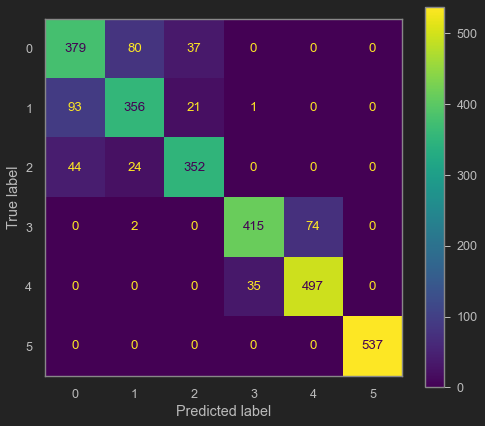

In [48]:
pred = lgb_model_fs.predict_proba(X_test_df[feature_selection])
display_metrics(y_test_df, pred)

### 5. Tunning of hyperparameters

In [97]:
def objective(trial):

    params = {"n_estimators": 1000,
              "metric": "auc_mu",
              "early_stopping_rounds": 20,
              "verbose": 0,
              "random_seed": 32,
              # Tunning
              "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 60),
              "max_depth": trial.suggest_int("max_depth", 2, 8),
              "num_leaves": trial.suggest_int("num_leaves", 10, 30),
              "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
             }

    lgb_model = lgb.LGBMClassifier(**params)
    lgb_model.fit(X_train_df_part[feature_selection], y_train_df_part, eval_set=[(X_train_df_part[feature_selection], y_train_df_part), (X_valid_df_part[feature_selection], y_valid_df_part)])

    return roc_auc_score(y_test_df.values, lgb_model.predict_proba(X_test_df[feature_selection]), multi_class="ovo")

In [98]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2021-10-23 18:44:33,182] A new study created in memory with name: no-name-44ac140b-c5e0-4066-aec4-11a37bad7178


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.983227	valid_1's auc_mu: 0.9836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[26]	valid_0's auc_mu: 0.994604	valid_1's auc_mu: 0.994343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[27]	valid_0's auc_mu: 0.994702	valid_1's auc_mu: 0.994397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[28]	valid_0's auc_mu: 0.994759	valid_1's auc_mu: 0.994475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's auc_mu: 0.997429	valid_1's auc_mu: 0.996728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's auc_mu: 0.997484	valid_1's auc_mu: 0.996782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's auc_mu: 0.997538	valid_1's auc_mu: 0.996802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[66]	valid_0's auc_mu: 0.997594	valid_1's auc_mu: 0.996853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[104]	valid_0's auc_mu: 0.998867	valid_1's auc_mu: 0.998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's auc_mu: 0.998892	valid_1's auc_mu: 0.998045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	valid_0's auc_mu: 0.998906	valid_1's auc_mu: 0.998058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	valid_0's auc_mu: 0.998924	valid_1's auc_mu: 0.99808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[147]	valid_0's auc_mu: 0.999489	valid_1's auc_mu: 0.998712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[148]	valid_0's auc_mu: 0.999498	valid_1's auc_mu: 0.998728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[149]	valid_0's auc_mu: 0.999504	valid_1's auc_mu: 0.998727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	valid_0's auc_mu: 0.999517	valid_1's auc_mu: 0.998738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's auc_mu: 0.999525	valid_1's auc_mu: 0.998763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's auc_mu: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's auc_mu: 0.999786	valid_1's auc_mu: 0.999099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	valid_0's auc_mu: 0.999791	valid_1's auc_mu: 0.999103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	valid_0's auc_mu: 0.999794	valid_1's auc_mu: 0.999112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	valid_0's auc_mu: 0.999799	valid_1's auc_mu: 0.999118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's auc_mu: 0.999803	valid_1's auc_mu: 0.999126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's auc_mu: 0

[252]	valid_0's auc_mu: 0.99991	valid_1's auc_mu: 0.999333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[253]	valid_0's auc_mu: 0.999911	valid_1's auc_mu: 0.999339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[254]	valid_0's auc_mu: 0.999912	valid_1's auc_mu: 0.999344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[255]	valid_0's auc_mu: 0.999913	valid_1's auc_mu: 0.999346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[256]	valid_0's auc_mu: 0.999916	valid_1's auc_mu: 0.999357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[257]	valid_0's auc_mu: 0.999918	valid_1's auc_mu: 0.999362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[305]	valid_0's auc_mu: 0.999961	valid_1's auc_mu: 0.999493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[306]	valid_0's auc_mu: 0.999961	valid_1's auc_mu: 0.999493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[307]	valid_0's auc_mu: 0.999962	valid_1's auc_mu: 0.999495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[308]	valid_0's auc_mu: 0.999963	valid_1's auc_mu: 0.999498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[309]	valid_0's auc_mu: 0.999964	valid_1's auc_mu: 0.999503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[354]	valid_0's auc_mu: 0.999981	valid_1's auc_mu: 0.999561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[355]	valid_0's auc_mu: 0.999981	valid_1's auc_mu: 0.999561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[356]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[357]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[358]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[359]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999568
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[418]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[419]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.99963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[420]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[421]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[422]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999632
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[478]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[479]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[480]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[481]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[482]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[483]	valid_0's auc_mu: 0.999997	valid_1

[539]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[541]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.99971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999709
[LightGBM] [Warning] No further splits wi

[I 2021-10-23 18:44:41,943] Trial 0 finished with value: 0.9843948518108548 and parameters: {'reg_lambda': 50.23256230292425, 'max_depth': 3, 'num_leaves': 21, 'learning_rate': 0.042465010410903226}. Best is trial 0 with value: 0.9843948518108548.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	valid_0's auc_mu: 0.997668	valid_1's auc_mu: 0.996698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	valid_0's auc_mu: 0.997752	valid_1's auc_mu: 0.996772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[47]	valid_0's auc_mu: 0.999152	valid_1's auc_mu: 0.998224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[48]	valid_0's auc_mu: 0.999201	valid_1's auc_mu: 0.998282
[LightGBM] [Warning] No further splits with positive gain

[70]	valid_0's auc_mu: 0.999731	valid_1's auc_mu: 0.998965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	valid_0's auc_mu: 0.999742	valid_1's auc_mu: 0.998983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	valid_0's auc_mu: 0.999754	valid_1's auc_mu: 0.99899

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	valid_0's auc_mu: 0.999911	valid_1's auc_mu: 0.999292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	valid_0's auc_mu: 0.999915	valid_1's auc_mu: 0.999301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[117]	valid_0's auc_mu: 0.999965	valid_1's auc_mu: 0.999439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[118]	valid_0's auc_mu: 0.999967	valid_1's auc_mu: 0.99945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's auc_mu: 0.999988	valid_1's auc_mu: 0.999586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[160]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.99965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[161]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[162]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[184]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[185]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.99

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[210]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999759
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[230]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[231]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[252]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[253]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2021-10-23 18:44:47,008] Trial 1 finished with value: 0.983563820191421 and parameters: {'reg_lambda': 25.521553266944082, 'max_depth': 4, 'num_leaves': 20, 'learning_rate': 0.061152289293548316}. Best is trial 0 with value: 0.9843948518108548.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999813
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's auc_mu: 0.999265	valid_1's auc_mu: 0.998237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's auc_mu: 0.999293	valid_1's auc_mu: 0.998277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[66]	valid_0's auc_mu: 0.999321	valid_1's auc_mu: 0.998335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	valid_0's auc_mu: 0.999347	valid_1's auc_mu: 0.998378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	valid_0's auc_mu: 0.999368	valid_1's auc_mu: 0.998425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	valid_0's auc_mu: 0.999392	valid_1's auc_mu: 0.998457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's auc_mu: 0.999414	valid_1's auc_mu: 0.998493
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.999937	valid_1's auc_mu: 0.999372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0.999939	valid_1's auc_mu: 0.999376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's auc_mu: 0.99994	valid_1's auc_mu: 0.999385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's auc_mu: 0.999942	valid_1's auc_mu: 0.999384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's auc_mu: 0.999945	valid_1's auc_mu: 0.999394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's auc_mu: 0.999946	valid_1's auc_mu: 0.999397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's auc_mu: 0.999948	valid_1's auc_mu: 0.999401
[LightGBM] [Warning] No further splits with positive gai

[208]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[210]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[211]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.99961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[212]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[213]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999709
[LightGBM] [Warning] No further splits with positive ga

[337]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[338]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999758


[I 2021-10-23 18:44:53,074] Trial 2 finished with value: 0.9831240373184016 and parameters: {'reg_lambda': 34.858656914567895, 'max_depth': 6, 'num_leaves': 11, 'learning_rate': 0.042519187974239536}. Best is trial 0 with value: 0.9843948518108548.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.983227	valid_1's auc_mu: 0.983599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[32]	valid_0's auc_mu: 0.997816	valid_1's auc_mu: 0.99713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[33]	valid_0's auc_mu: 0.997919	valid_1's auc_mu: 0.997193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[34]	valid_0's auc_mu: 0.997982	valid_1's auc_mu: 0.997256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[35]	valid_0's auc_mu: 0.998074	valid_1's auc_mu: 0.997371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[77]	valid_0's auc_mu: 0.999649	valid_1's auc_mu: 0.998924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's auc_mu: 0.999662	valid_1's auc_mu: 0.998945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's auc_mu: 0.999674	valid_1's auc_mu: 0.998962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's auc_mu: 0.999688	valid_1's auc_mu: 0.998977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's auc_mu: 0.999703	valid_1's auc_mu: 0.998987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[123]	valid_0's auc_mu: 0.99993	valid_1's auc_mu: 0.999368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's auc_mu: 0.999932	valid_1's auc_mu: 0.999379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	valid_0's auc_mu: 0.999933	valid_1's auc_mu: 0.999379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's auc_mu: 0.999935	valid_1's auc_mu: 0.999389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[127]	valid_0's auc_mu: 0.999937	valid_1's auc_mu: 0.99939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[128]	valid_0's auc_mu: 0.999939	valid_1's auc_mu: 0.999399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[129]	valid_0's auc_mu: 0.999943	valid_1's auc_mu: 0.999412
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[172]	valid_0's auc_mu: 0.999985	valid_1's auc_mu: 0.999588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[173]	valid_0's auc_mu: 0.999985	valid_1's auc_mu: 0.999591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[174]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[175]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[222]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[223]	valid_0's auc_mu: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[278]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[279]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[280]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[281]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[282]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[283]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

[I 2021-10-23 18:44:57,577] Trial 3 finished with value: 0.9843805712645712 and parameters: {'reg_lambda': 52.64391082645452, 'max_depth': 3, 'num_leaves': 16, 'learning_rate': 0.09394368315893985}. Best is trial 0 with value: 0.9843948518108548.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17]	valid_0's auc_mu: 0.997581	valid_1's auc_mu: 0.996491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18]	valid_0's auc_mu: 0.997648	valid_1's auc_mu: 0.996575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[35]	valid_0's auc_mu: 0.998693	valid_1's auc_mu: 0.997589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[36]	valid_0's auc_mu: 0.998748	valid_1's auc_mu: 0.99766
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[52]	valid_0's auc_mu: 0.999388	valid_1's auc_mu: 0.998431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[53]	valid_0's auc_mu: 0.999416	valid_1's auc_mu: 0.998446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's auc_mu: 0.99984	valid_1's auc_mu: 0.999107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's auc_mu: 0.999848	valid_1's auc_mu: 0.999127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[82]	valid_0's auc_mu: 0.999854	valid_1's auc_mu: 0.999141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[104]	valid_0's auc_mu: 0.999949	valid_1's auc_mu: 0.999342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's auc_mu: 0.999951	valid_1's auc_mu: 0.999345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	valid_0's auc_mu: 0.999953	valid_1's auc_mu: 0.999357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's auc_mu: 0.999988	valid_1's auc_mu: 0.999523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.999988	valid_1's auc_mu: 0.999528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	vali

[180]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[181]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999656
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[182]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[183]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.99966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[184]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999707
[LightGBM] [Warning] No further splits

[I 2021-10-23 18:45:03,714] Trial 4 finished with value: 0.9822749758943509 and parameters: {'reg_lambda': 23.960749022557206, 'max_depth': 6, 'num_leaves': 27, 'learning_rate': 0.040247866151674715}. Best is trial 0 with value: 0.9843948518108548.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[234]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999717
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.970588	valid_1's auc_mu: 0.972638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc_mu: 0.970588	valid_1's auc_mu: 0.972638
[LightGBM] [Warning] No further splits 

[61]	valid_0's auc_mu: 0.988734	valid_1's auc_mu: 0.989562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's auc_mu: 0.988747	valid_1's auc_mu: 0.989576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's auc_mu: 0.988781	valid_1's auc_mu: 0.989581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's auc_mu: 0.988913	valid_1's auc_mu: 0.989639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's auc_mu: 0.988891	valid_1's auc_mu: 0.989654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[66]	valid_0's auc_mu: 0.988949	valid_1's auc_mu: 0.989648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	valid_0's auc_mu: 0.988966	valid_1's auc_mu: 0.989665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	valid_0's auc_mu: 0.989009	valid_1's auc_mu: 0.989672
[Li

[141]	valid_0's auc_mu: 0.993214	valid_1's auc_mu: 0.992733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's auc_mu: 0.993244	valid_1's auc_mu: 0.992767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's auc_mu: 0.993262	valid_1's auc_mu: 0.992765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's auc_mu: 0.993299	valid_1's auc_mu: 0.992818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[145]	valid_0's auc_mu: 0.993322	valid_1's auc_mu: 0.992842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[146]	valid_0's auc_mu: 0.993344	valid_1's auc_mu: 0.992854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[147]	valid_0's auc_mu: 0.993371	valid_1's auc_mu: 0.992891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[148]	valid_0's auc_mu: 0.99339	valid_1's auc_mu: 0.992

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	valid_0's auc_mu: 0.994677	valid_1's auc_mu: 0.994175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's auc_mu: 0.994709	valid_1's auc_mu: 0.994199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's auc_mu: 0.994725	valid_1's auc_mu: 0.994213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	valid_0's auc_mu: 0.994757	valid_1's auc_mu: 0.994241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	valid_0's auc_mu: 0.994776	valid_1's auc_mu: 0.994252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	valid_0's auc_mu: 0.994812	valid_1's auc_mu: 0.9943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	valid_0's auc_mu: 0.99484	valid_1's auc_mu: 0.994309
[LightGBM] [Warning] No further splits with positive gain,

[279]	valid_0's auc_mu: 0.996001	valid_1's auc_mu: 0.995394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[280]	valid_0's auc_mu: 0.996015	valid_1's auc_mu: 0.995411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[281]	valid_0's auc_mu: 0.996035	valid_1's auc_mu: 0.995438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[282]	valid_0's auc_mu: 0.996047	valid_1's auc_mu: 0.99545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[283]	valid_0's auc_mu: 0.996061	valid_1's auc_mu: 0.995472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[284]	valid_0's auc_mu: 0.99608	valid_1's auc_mu: 0.995493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[285]	valid_0's auc_mu: 0.996099	valid_1's auc_mu: 0.995505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[286]	valid_0's auc_mu: 0.996111	valid_1's auc_mu: 0.9955

[360]	valid_0's auc_mu: 0.997001	valid_1's auc_mu: 0.996378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[361]	valid_0's auc_mu: 0.997007	valid_1's auc_mu: 0.996373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[362]	valid_0's auc_mu: 0.997019	valid_1's auc_mu: 0.996383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[363]	valid_0's auc_mu: 0.997031	valid_1's auc_mu: 0.996391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[364]	valid_0's auc_mu: 0.997039	valid_1's auc_mu: 0.996398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[365]	valid_0's auc_mu: 0.997051	valid_1's auc_mu: 0.996414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[366]	valid_0's auc_mu: 0.997064	valid_1's auc_mu: 0.996434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[367]	valid_0's auc_mu: 0.997073	valid_1's auc_mu: 0.99

[436]	valid_0's auc_mu: 0.997675	valid_1's auc_mu: 0.997036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[437]	valid_0's auc_mu: 0.997683	valid_1's auc_mu: 0.997038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[438]	valid_0's auc_mu: 0.997692	valid_1's auc_mu: 0.997052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[439]	valid_0's auc_mu: 0.997697	valid_1's auc_mu: 0.997047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[440]	valid_0's auc_mu: 0.997709	valid_1's auc_mu: 0.997063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[441]	valid_0's auc_mu: 0.997715	valid_1's auc_mu: 0.997072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[442]	valid_0's auc_mu: 0.997723	valid_1's auc_mu: 0.997071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[443]	valid_0's auc_mu: 0.997734	valid_1's auc_mu: 0.99

[512]	valid_0's auc_mu: 0.998191	valid_1's auc_mu: 0.997523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[513]	valid_0's auc_mu: 0.998196	valid_1's auc_mu: 0.997523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[514]	valid_0's auc_mu: 0.998199	valid_1's auc_mu: 0.997525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[515]	valid_0's auc_mu: 0.998207	valid_1's auc_mu: 0.997532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[516]	valid_0's auc_mu: 0.998213	valid_1's auc_mu: 0.997541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[517]	valid_0's auc_mu: 0.99822	valid_1's auc_mu: 0.99754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[518]	valid_0's auc_mu: 0.998225	valid_1's auc_mu: 0.99755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[519]	valid_0's auc_mu: 0.998227	valid_1's auc_mu: 0.99755

[575]	valid_0's auc_mu: 0.998502	valid_1's auc_mu: 0.997808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[576]	valid_0's auc_mu: 0.998507	valid_1's auc_mu: 0.997811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[577]	valid_0's auc_mu: 0.99851	valid_1's auc_mu: 0.997809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[578]	valid_0's auc_mu: 0.998515	valid_1's auc_mu: 0.997814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[579]	valid_0's auc_mu: 0.998521	valid_1's auc_mu: 0.997816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[580]	valid_0's auc_mu: 0.998526	valid_1's auc_mu: 0.997824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[581]	valid_0's auc_mu: 0.998528	valid_1's auc_mu: 0.997822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[582]	valid_0's auc_mu: 0.998534	valid_1's auc_mu: 0.997

[653]	valid_0's auc_mu: 0.998811	valid_1's auc_mu: 0.998067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[654]	valid_0's auc_mu: 0.998813	valid_1's auc_mu: 0.998066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[655]	valid_0's auc_mu: 0.998815	valid_1's auc_mu: 0.998068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[656]	valid_0's auc_mu: 0.998818	valid_1's auc_mu: 0.998079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[657]	valid_0's auc_mu: 0.998821	valid_1's auc_mu: 0.998079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[658]	valid_0's auc_mu: 0.998825	valid_1's auc_mu: 0.998084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[659]	valid_0's auc_mu: 0.998828	valid_1's auc_mu: 0.998084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[660]	valid_0's auc_mu: 0.998831	valid_1's auc_mu: 0.99

[734]	valid_0's auc_mu: 0.999039	valid_1's auc_mu: 0.998278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[735]	valid_0's auc_mu: 0.999042	valid_1's auc_mu: 0.998281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[736]	valid_0's auc_mu: 0.999044	valid_1's auc_mu: 0.99829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[737]	valid_0's auc_mu: 0.999045	valid_1's auc_mu: 0.998289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[738]	valid_0's auc_mu: 0.999049	valid_1's auc_mu: 0.998291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[739]	valid_0's auc_mu: 0.999052	valid_1's auc_mu: 0.998294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	valid_0's auc_mu: 0.999055	valid_1's auc_mu: 0.998294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	valid_0's auc_mu: 0.999057	valid_1's auc_mu: 0.998

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[813]	valid_0's auc_mu: 0.999209	valid_1's auc_mu: 0.998456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[814]	valid_0's auc_mu: 0.999212	valid_1's auc_mu: 0.998458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[815]	valid_0's auc_mu: 0.999214	valid_1's auc_mu: 0.998459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[816]	valid_0's auc_mu: 0.999216	valid_1's auc_mu: 0.998463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[817]	valid_0's auc_mu: 0.999217	valid_1's auc_mu: 0.998466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[818]	valid_0's auc_mu: 0.999219	valid_1's auc_mu: 0.998468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[819]	valid_0's auc_mu: 0.999222	valid_1's auc_mu: 0.998469
[LightGBM] [Warning] No further splits with positive ga

[890]	valid_0's auc_mu: 0.999338	valid_1's auc_mu: 0.998583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[891]	valid_0's auc_mu: 0.999341	valid_1's auc_mu: 0.998585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[892]	valid_0's auc_mu: 0.999343	valid_1's auc_mu: 0.998586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[893]	valid_0's auc_mu: 0.999343	valid_1's auc_mu: 0.998588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[894]	valid_0's auc_mu: 0.999346	valid_1's auc_mu: 0.998585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[895]	valid_0's auc_mu: 0.999347	valid_1's auc_mu: 0.998589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[896]	valid_0's auc_mu: 0.999348	valid_1's auc_mu: 0.998587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[897]	valid_0's auc_mu: 0.99935	valid_1's auc_mu: 0.998

[953]	valid_0's auc_mu: 0.999421	valid_1's auc_mu: 0.998685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[954]	valid_0's auc_mu: 0.999423	valid_1's auc_mu: 0.998687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[955]	valid_0's auc_mu: 0.999424	valid_1's auc_mu: 0.998685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[956]	valid_0's auc_mu: 0.999425	valid_1's auc_mu: 0.998687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[957]	valid_0's auc_mu: 0.999426	valid_1's auc_mu: 0.99869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[958]	valid_0's auc_mu: 0.999428	valid_1's auc_mu: 0.998693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[959]	valid_0's auc_mu: 0.999428	valid_1's auc_mu: 0.998694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[960]	valid_0's auc_mu: 0.999429	valid_1's auc_mu: 0.998

[I 2021-10-23 18:45:14,402] Trial 5 finished with value: 0.9826774287869088 and parameters: {'reg_lambda': 52.80174098638622, 'max_depth': 2, 'num_leaves': 23, 'learning_rate': 0.011232234993212489}. Best is trial 0 with value: 0.9843948518108548.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.994199	valid_1's auc_mu: 0.991098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[27]	valid_0's auc_mu: 0.999651	valid_1's auc_mu: 0.998714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[28]	valid_0's auc_mu: 0.999684	valid_1's auc_mu: 0.998773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[29]	valid_0's auc_mu: 0.99971	valid_1's auc_mu: 0.998814

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[58]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[59]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's auc_mu: 0.999989	valid_1's auc_mu: 0.999504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's auc_mu: 0.99999	valid_1's auc_mu: 0.999513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's auc_mu: 0.999991

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[118]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[119]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[120]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[121]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999735


[I 2021-10-23 18:45:17,347] Trial 6 finished with value: 0.9806632295466734 and parameters: {'reg_lambda': 6.397971226969236, 'max_depth': 6, 'num_leaves': 21, 'learning_rate': 0.05875119271525319}. Best is trial 0 with value: 0.9843948518108548.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.983745	valid_1's auc_mu: 0.982961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's auc_mu: 0.992211	valid_1's auc_mu: 0.99232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]	valid_0's auc_mu: 0.992305	valid_1's auc_mu: 0.992398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	valid_0's auc_mu: 0.992403	valid_1's auc_mu: 0.992458

[60]	valid_0's auc_mu: 0.994837	valid_1's auc_mu: 0.994707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's auc_mu: 0.994888	valid_1's auc_mu: 0.994749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's auc_mu: 0.994929	valid_1's auc_mu: 0.994769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[91]	valid_0's auc_mu: 0.995815	valid_1's auc_mu: 0.995472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's auc_mu: 0.995851	valid_1's auc_mu: 0.995482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's auc_mu: 0.995873	valid_1's auc_mu: 0.995513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's auc_mu: 0.996596	valid_1's auc_mu: 0.996032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's auc_mu: 0.996619	valid_1's auc_mu: 0.996068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's auc_mu: 0.996667	valid_1's auc_mu: 0.996093
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[155]	valid_0's auc_mu: 0.997539	valid_1's auc_mu: 0.996904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's auc_mu: 0.997562	valid_1's auc_mu: 0.996941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's auc_mu: 0.997593	valid_1's auc_mu: 0.996961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's auc_mu: 0.997616	valid_1's auc_mu: 0.996964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[201]	valid_0's auc_mu: 0.998371	valid_1's auc_mu: 0.997721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	valid_0's auc_mu: 0.998388	valid_1's auc_mu: 0.997726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	valid_0's auc_mu: 0.9984	valid_1's auc_mu: 0.997745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's auc_mu: 0.998411	valid_1's auc_mu: 0.997748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[246]	valid_0's auc_mu: 0.998897	valid_1's auc_mu: 0.998105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[247]	valid_0's auc_mu: 0.998906	valid_1's auc_mu: 0.998118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[248]	valid_0's auc_mu: 0.998915	valid_1's auc_mu: 0.998121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[249]	valid_0's auc_mu: 0.998925	valid_1's auc_mu: 0.998127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[294]	valid_0's auc_mu: 0.999267	valid_1's auc_mu: 0.998501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	valid_0's auc_mu: 0.999273	valid_1's auc_mu: 0.998512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	valid_0's auc_mu: 0.999279	valid_1's auc_mu: 0.998515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	valid_0's auc_mu: 0.999286	valid_1's auc_mu: 0.998522
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[345]	valid_0's auc_mu: 0.999524	valid_1's auc_mu: 0.998798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[346]	valid_0's auc_mu: 0.999528	valid_1's auc_mu: 0.998803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[347]	valid_0's auc_mu: 0.999532	valid_1's auc_mu: 0.998806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[348]	valid_0's auc_mu: 0.999536	valid_1's auc_mu: 0.998809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[349]	vali

[390]	valid_0's auc_mu: 0.999683	valid_1's auc_mu: 0.998989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[391]	valid_0's auc_mu: 0.999686	valid_1's auc_mu: 0.998993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[392]	valid_0's auc_mu: 0.999687	valid_1's auc_mu: 0.998996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[393]	valid_0's auc_mu: 0.999689	valid_1's auc_mu: 0.998999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[394]	valid_0's auc_mu: 0.999692	valid_1's auc_mu: 0.999004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[395]	valid_0's auc_mu: 0.999695	valid_1's auc_mu: 0.999005
[LightGBM] [Warning] No further splits w

[437]	valid_0's auc_mu: 0.999775	valid_1's auc_mu: 0.999114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[438]	valid_0's auc_mu: 0.999777	valid_1's auc_mu: 0.999115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[439]	valid_0's auc_mu: 0.99978	valid_1's auc_mu: 0.999116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[440]	valid_0's auc_mu: 0.999782	valid_1's auc_mu: 0.999123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[441]	valid_0's auc_mu: 0.999783	valid_1's auc_mu: 0.999124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[442]	valid_0's auc_mu: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[484]	valid_0's auc_mu: 0.99985	valid_1's auc_mu: 0.999238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[485]	valid_0's auc_mu: 0.999851	valid_1's auc_mu: 0.999238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[486]	valid_0's auc_mu: 0.999853	valid_1's auc_mu: 0.99924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[487]	valid_0's auc_mu: 0.999854	valid_1's auc_mu: 0.999243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[488]	valid_

[529]	valid_0's auc_mu: 0.999898	valid_1's auc_mu: 0.999323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[530]	valid_0's auc_mu: 0.999899	valid_1's auc_mu: 0.999323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[531]	valid_0's auc_mu: 0.9999	valid_1's auc_mu: 0.999327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[532]	valid_0's auc_mu: 0.9999	valid_1's auc_mu: 0.999325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[533]	valid_0's auc_mu: 0.999901	valid_1's auc_mu: 0.99933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[534]	valid_0's auc_mu: 0.9999

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[592]	valid_0's auc_mu: 0.99994	valid_1's auc_mu: 0.999426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[593]	valid_0's auc_mu: 0.999941	valid_1's auc_mu: 0.999431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[594]	valid_0's auc_mu: 0.999941	valid_1's auc_mu: 0.999433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[595]	valid_0's auc_mu: 0.999941	valid_1's auc_mu: 0.999436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[596]	valid_0's auc_mu: 0.999942	valid_1's auc_mu: 0.99944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[597]	valid_0's auc_mu: 0.9

[638]	valid_0's auc_mu: 0.999959	valid_1's auc_mu: 0.999486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[639]	valid_0's auc_mu: 0.999959	valid_1's auc_mu: 0.999489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[640]	valid_0's auc_mu: 0.999959	valid_1's auc_mu: 0.999491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[641]	valid_0's auc_mu: 0.99996	valid_1's auc_mu: 0.999492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[642]	valid_0's auc_mu: 0.99996	valid_1's auc_mu: 0.999491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[643]	valid_0's auc_mu: 0.99996	valid_1's auc_mu: 0.999494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[644]	valid_0's auc_mu: 0.999961	valid_1's 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[699]	valid_0's auc_mu: 0.999975	valid_1's auc_mu: 0.99955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[700]	valid_0's auc_mu: 0.999975	valid_1's auc_mu: 0.999549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[701]	valid_0's auc_mu: 0.999975	valid_1's auc_mu: 0.999553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[702]	valid_0's auc_mu: 0.999975	valid_1's auc_mu: 0.999554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[703]	valid_0's auc_mu: 0.999976	valid_1's auc_mu: 0.999555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[704]	valid_0's auc_mu: 0.999976	valid_1's auc_mu: 0.999559
[LightGBM] [Warning] No further splits wi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[749]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[750]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[751]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[752]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[753]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[754]	valid_0's auc_mu: 0.999985	valid_1's auc_mu: 0.999608
[LightGBM] [Warning] No further splits w

[794]	valid_0's auc_mu: 0.99999	valid_1's auc_mu: 0.999643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[795]	valid_0's auc_mu: 0.99999	valid_1's auc_mu: 0.999646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[796]	valid_0's auc_mu: 0.99999	valid_1's auc_mu: 0.999645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[797]	valid_0's auc_mu: 0.99999	valid_1's auc_mu: 0.999645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[798]	valid_0's auc_mu: 0.99999	valid_1's auc_mu: 0.999646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[799]	valid_0's auc_mu: 0.99999	valid_1's auc_mu: 0.999646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[854]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[855]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[856]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[857]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[858]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[903]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[904]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[905]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[906]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[907]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.99968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[908]	valid_0's auc_mu: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[963]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[964]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[965]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[966]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[967]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[968]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999708
[LightGBM] [Warning] No further splits w

[I 2021-10-23 18:45:31,138] Trial 7 finished with value: 0.9839703356847921 and parameters: {'reg_lambda': 26.02364232524023, 'max_depth': 3, 'num_leaves': 14, 'learning_rate': 0.015413412114394204}. Best is trial 0 with value: 0.9843948518108548.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.992512	valid_1's auc_mu: 0.989404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc_mu: 0.994201	valid_1's auc_mu: 0.991602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

[40]	valid_0's auc_mu: 0.999939	valid_1's auc_mu: 0.999359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[41]	valid_0's auc_mu: 0.999948	valid_1's auc_mu: 0.999387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[42]	valid_0's auc_mu: 0.999955	valid_1's auc_mu: 0.999403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[43]	valid_0's auc_mu: 0.99996	valid_1's auc_mu: 0.999424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[44]	valid_0's auc_mu: 0.999963	valid_1's auc_mu: 0.999432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[45]	valid_0's auc_mu: 0.99997	valid_1's auc_mu: 0.999454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[46]	valid_0's auc_mu: 0.999973	valid_1's auc_mu: 0.999465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[47]	valid_0's auc_mu: 0.999977	valid_1's auc_mu: 0.999476
[Ligh

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[110]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.9998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[111]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.9998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[112]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[113]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[114]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[115]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[116]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[117]	valid_0's auc_mu: 1	valid_1

[I 2021-10-23 18:45:33,797] Trial 8 finished with value: 0.982315892546178 and parameters: {'reg_lambda': 17.585113731366587, 'max_depth': 6, 'num_leaves': 17, 'learning_rate': 0.09316258026997827}. Best is trial 0 with value: 0.9843948518108548.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[120]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[121]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999808
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.989394	valid_1's auc_mu: 0.986866
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's auc_mu: 0.999635	valid_1's auc_mu: 0.998844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's auc_mu: 0.99965	valid_1's auc_mu: 0.998857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's auc_mu: 0.999665	valid_1's auc_mu: 0.998876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's auc_mu: 0.999677	valid_1's auc_mu: 0.998892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[66]	valid_0's auc_mu: 0.999693	valid_1's auc_mu: 0.998918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	valid_0's auc_mu: 0.999704	valid_1's auc_mu: 0.99893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	valid_0's auc_mu: 0.99972	valid_1's auc_mu: 0.998961
[LightGBM] [Warning] No further splits with positive gain, best g

[131]	valid_0's auc_mu: 0.999977	valid_1's auc_mu: 0.999507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[132]	valid_0's auc_mu: 0.999978	valid_1's auc_mu: 0.999513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[133]	valid_0's auc_mu: 0.999978	valid_1's auc_mu: 0.999519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's auc_mu: 0.999979	valid_1's auc_mu: 0.999527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's auc_mu: 0.99998	valid_1's auc_mu: 0.999525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's auc_mu: 0.999981	valid_1's auc_mu: 0.99953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's auc_mu: 0.999981	valid_1's auc_mu: 0.999535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.9995

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.99969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.99969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999697
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[265]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[266]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[267]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[268]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[269]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	valid_0's auc_mu: 1	val

[I 2021-10-23 18:45:39,248] Trial 9 finished with value: 0.9836487416854641 and parameters: {'reg_lambda': 42.644164812840195, 'max_depth': 6, 'num_leaves': 12, 'learning_rate': 0.060016069912900864}. Best is trial 0 with value: 0.9843948518108548.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.991322	valid_1's auc_mu: 0.988965


[18]	valid_0's auc_mu: 0.995727	valid_1's auc_mu: 0.994613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	valid_0's auc_mu: 0.995811	valid_1's auc_mu: 0.994765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[44]	valid_0's auc_mu: 0.997551	valid_1's auc_mu: 0.996658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[45]	valid_0's auc_mu: 0.997614	valid_1's auc_mu: 0.996712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	valid_0's auc_mu: 0.998476	valid_1's auc_mu: 0.997457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	valid_0's auc_mu: 0.998506	valid_1's auc_mu: 0.997477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's auc_mu: 0.999047	valid_1's auc_mu: 0.998142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's auc_mu: 0.999068	valid_1's auc_mu: 0.998162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	valid_0's auc_mu: 0.999088	valid_1's auc_mu: 0.998171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[121]	valid_0's auc_mu: 0.999483	valid_1's auc_mu: 0.998664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's auc_mu: 0.999496	valid_1's auc_mu: 0.998676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's auc_mu: 0.999508	valid_1's auc_mu: 0.998694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's auc_mu: 0.999517	valid_1's auc_mu: 0.998717
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's auc_mu: 0.999772	valid_1's auc_mu: 0.999011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's auc_mu: 0.999777	valid_1's auc_mu: 0.999015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[161]	valid_0's auc_mu: 0.999783	valid_1's auc_mu: 0.999018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[162]	valid_0's auc_mu: 0.999788	valid_1's auc_mu: 0.999022
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	valid_0's auc_mu: 0.999907	valid_1's auc_mu: 0.999192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	valid_0's auc_mu: 0.999908	valid_1's auc_mu: 0.999194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	valid_0's auc_mu: 0.999911	valid_1's auc_mu: 0.999199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's auc_mu: 0.999913	valid_1's auc_mu: 0.999201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's auc_mu: 0.999915	valid_1's auc_mu: 0.999207
[LightGBM] [Warning] No f

[245]	valid_0's auc_mu: 0.99996	valid_1's auc_mu: 0.999357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[246]	valid_0's auc_mu: 0.999961	valid_1's auc_mu: 0.99936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[247]	valid_0's auc_mu: 0.999962	valid_1's auc_mu: 0.999361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[248]	valid_0's auc_mu: 0.999962	valid_1's auc_mu: 0.999365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[249]	valid_0's auc_mu: 0.999963	valid_1's auc_mu: 0.999367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[250]	valid_0's auc_mu: 0.999963	valid_1's auc_mu: 0.999368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	valid_0's auc_mu: 0.999981	valid_1's auc_mu: 0.999467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[298]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[299]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's auc_mu: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[345]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[346]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.99955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[347]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[348]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[349]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999552
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[396]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[397]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[398]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[399]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[401]	valid_0's auc_mu: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[440]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[441]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[442]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[443]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[444]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[481]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[482]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[483]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[484]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[485]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999671
[LightGBM] [Warning] No f

[I 2021-10-23 18:45:53,793] Trial 10 finished with value: 0.9837704504187954 and parameters: {'reg_lambda': 59.33530704156239, 'max_depth': 8, 'num_leaves': 28, 'learning_rate': 0.027327389263758644}. Best is trial 0 with value: 0.9843948518108548.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.973415	valid_1's auc_mu: 0.973675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc_mu: 0.978674	valid_1's auc_mu: 0.979734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc_mu: 0.979757	valid_1's auc_mu: 0.981375
[LightGBM] [Warning] No further sp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's auc_mu: 0.998944	valid_1's auc_mu: 0.998242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's auc_mu: 0.998978	valid_1's auc_mu: 0.998269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's auc_mu: 0.999007	valid_1's auc_mu: 0.998289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's auc_mu: 0.999032	valid_1's auc_mu: 0.998314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's auc_mu: 0.999044	valid_1's auc_mu: 0.998348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's auc_mu: 0.999058	valid_1's auc_mu: 0.998353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's auc_mu: 0.999081	valid_1's auc_mu: 0.998374
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's auc_mu: 0.999793	valid_1's auc_mu: 0.999185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's auc_mu: 0.999795	valid_1's auc_mu: 0.999186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's auc_mu: 0.999798	valid_1's auc_mu: 0.999196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's auc_mu: 0.999803	valid_1's auc_mu: 0.999204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[161]	valid_0's auc_mu: 0.999807	valid_1's auc_mu: 0.999206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[162]	valid_0's auc_mu: 0.99981	valid_1's auc_mu: 0.999215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[163]	valid_0's auc_mu: 0.999813	valid_1's auc_mu: 0.999213
[LightGBM] [Warning] No further splits with positive gai

[234]	valid_0's auc_mu: 0.999946	valid_1's auc_mu: 0.999433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[235]	valid_0's auc_mu: 0.999947	valid_1's auc_mu: 0.999433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[236]	valid_0's auc_mu: 0.999948	valid_1's auc_mu: 0.999436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[237]	valid_0's auc_mu: 0.99995	valid_1's auc_mu: 0.999441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[238]	valid_0's auc_mu: 0.99995	valid_1's auc_mu: 0.999446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[239]	valid_0's auc_mu: 0.99995	valid_1's auc_mu: 0.999446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[240]	valid_0's auc_mu: 0.999951	valid_1's auc_mu: 0.999451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[241]	valid_0's auc_mu: 0.999951	valid_1's auc_mu: 0.99945

[311]	valid_0's auc_mu: 0.999985	valid_1's auc_mu: 0.999575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[312]	valid_0's auc_mu: 0.999985	valid_1's auc_mu: 0.999574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[313]	valid_0's auc_mu: 0.999985	valid_1's auc_mu: 0.999575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[314]	valid_0's auc_mu: 0.999985	valid_1's auc_mu: 0.999579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[315]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[316]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[317]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[318]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.99

[374]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[376]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.99964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[377]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.99964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[378]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.99964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[379]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.99964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[380]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[381]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999643

[452]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[453]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[454]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[455]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[456]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.99969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[457]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[458]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[459]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999

[I 2021-10-23 18:45:59,499] Trial 11 finished with value: 0.9844021683765848 and parameters: {'reg_lambda': 44.61982109190278, 'max_depth': 2, 'num_leaves': 17, 'learning_rate': 0.09831160898478036}. Best is trial 11 with value: 0.9844021683765848.


[533]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999721
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.973415	valid_1's auc_mu: 0.973675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc_mu: 0.978004	valid_1's auc_mu: 0.978512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc_mu: 0.979584	valid_1'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's auc_mu: 0.998543	valid_1's auc_mu: 0.997892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's auc_mu: 0.998572	valid_1's auc_mu: 0.997922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's auc_mu: 0.998613	valid_1's auc_mu: 0.997957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's auc_mu: 0.998633	valid_1's auc_mu: 0.997965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's auc_mu: 0.998663	valid_1's auc_mu: 0.998002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's auc_mu: 0.998694	valid_1's auc_mu: 0.998028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[82]	valid_0's auc_mu: 0.99873	valid_1's auc_mu: 0.998068
[LightGBM] [Warning] No further splits with positive gain, best

[154]	valid_0's auc_mu: 0.999641	valid_1's auc_mu: 0.998976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's auc_mu: 0.999646	valid_1's auc_mu: 0.998981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's auc_mu: 0.999649	valid_1's auc_mu: 0.998977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's auc_mu: 0.999653	valid_1's auc_mu: 0.998976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's auc_mu: 0.999663	valid_1's auc_mu: 0.998993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's auc_mu: 0.999667	valid_1's auc_mu: 0.999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's auc_mu: 0.999672	valid_1's auc_mu: 0.999003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[161]	valid_0's auc_mu: 0.999683	valid_1's auc_mu: 0.99902

[216]	valid_0's auc_mu: 0.999869	valid_1's auc_mu: 0.999279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's auc_mu: 0.99987	valid_1's auc_mu: 0.999277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc_mu: 0.999872	valid_1's auc_mu: 0.999283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's auc_mu: 0.999874	valid_1's auc_mu: 0.999287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's auc_mu: 0.999876	valid_1's auc_mu: 0.99929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	valid_0's auc_mu: 0.999878	valid_1's auc_mu: 0.999298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[222]	valid_0's auc_mu: 0.99988	valid_1's auc_mu: 0.999295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[223]	valid_0's auc_mu: 0.999882	valid_1's auc_mu: 0.99929

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[294]	valid_0's auc_mu: 0.999957	valid_1's auc_mu: 0.999452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	valid_0's auc_mu: 0.999957	valid_1's auc_mu: 0.999453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	valid_0's auc_mu: 0.999958	valid_1's auc_mu: 0.999452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	valid_0's auc_mu: 0.999959	valid_1's auc_mu: 0.999453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[298]	valid_0's auc_mu: 0.999959	valid_1's auc_mu: 0.999455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[299]	valid_0's auc_mu: 0.99996	valid_1's auc_mu: 0.999461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's auc_mu: 0.999961	valid_1's auc_mu: 0.999458
[LightGBM] [Warning] No further splits with positive gai

[376]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[377]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[378]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.99957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[379]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[380]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[381]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[382]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[383]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999

[453]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[454]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[455]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[456]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[457]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[458]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[459]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[460]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.99

[530]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[531]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[532]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[533]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.99968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[534]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.99968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[535]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[536]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[537]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.9996

[I 2021-10-23 18:46:05,311] Trial 12 finished with value: 0.9843459029577674 and parameters: {'reg_lambda': 39.6064980924994, 'max_depth': 2, 'num_leaves': 24, 'learning_rate': 0.07844744345615003}. Best is trial 11 with value: 0.9844021683765848.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	valid_0's auc_mu: 0.997637	valid_1's auc_mu: 0.996676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	valid_0's auc_mu: 0.997747	valid_1's auc_mu: 0.996796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[47]	valid_0's auc_mu: 0.999157	valid_1's auc_mu: 0.998282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[48]	valid_0's auc_mu: 0.999205	valid_1's auc_mu: 0.998355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[49]	valid_0's auc_mu: 0.999243	valid_1's auc_mu: 0.99839

[70]	valid_0's auc_mu: 0.999709	valid_1's auc_mu: 0.998983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	valid_0's auc_mu: 0.999722	valid_1's auc_mu: 0.998997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	valid_0's auc_mu: 0.999731	valid_1's auc_mu: 0.999001
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's auc_mu: 0.999889	valid_1's auc_mu: 0.999258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	valid_0's auc_mu: 0.999895	valid_1's auc_mu: 0.999272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[117]	valid_0's auc_mu: 0.999956	valid_1's auc_mu: 0.999435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[118]	valid_0's auc_mu: 0.999957	valid_1's auc_mu: 0.999434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[119]	valid_0's auc_mu: 0.999958	valid_1's auc_mu: 0.999437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0.999979	valid_1's auc_mu: 0.999533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's auc_mu: 0.99998	valid_1's auc_mu: 0.999542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[161]	valid_0's auc_mu: 0.99999	valid_1's auc_mu: 0.999621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[162]	valid_0's auc_mu: 0.99999	valid_1's auc_mu: 0.999625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[183]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[184]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999676
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.99971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999

[230]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[231]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[232]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[253]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[254]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[298]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[318]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[319]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2021-10-23 18:46:11,370] Trial 13 finished with value: 0.9839811311458033 and parameters: {'reg_lambda': 45.80033317403665, 'max_depth': 4, 'num_leaves': 18, 'learning_rate': 0.07392291959939035}. Best is trial 11 with value: 0.9844021683765848.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.983227	valid_1's auc_mu: 0.9836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's auc_mu: 0.994347	valid_1's auc_mu: 0.994072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]	valid_0's auc_mu: 0.994429	valid_1's auc_mu: 0.994213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	valid_0's auc_mu: 0.994478	valid_1's auc_mu: 0.99427

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's auc_mu: 0.996201	valid_1's auc_mu: 0.995651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's auc_mu: 0.99629	valid_1's auc_mu: 0.995727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's auc_mu: 0.996352	valid_1's auc_mu: 0.995774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's auc_mu: 0.998233	valid_1's auc_mu: 0.99752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	valid_0's auc_mu: 0.99825	valid_1's auc_mu: 0.997521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	valid_0's auc_mu: 0.998288	valid_1's auc_mu: 0.997558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[108]	valid_0's auc_mu: 0.998313	valid_1's auc_mu: 0.997566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[109]	valid_0's auc_mu: 0.998334	valid_1's auc_mu: 0.997582
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's auc_mu: 0.999156	valid_1's auc_mu: 0.998355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's auc_mu: 0.999175	valid_1's auc_mu: 0.998368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's auc_mu: 0.999186	valid_1's auc_mu: 0.998382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's auc_mu: 0.999194	valid_1's auc_mu: 0.998391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's auc_mu: 0.999205	valid_1's auc_mu: 0.998399
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[199]	valid_0's auc_mu: 0.999559	valid_1's auc_mu: 0.998809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's auc_mu: 0.999564	valid_1's auc_mu: 0.998817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	valid_0's auc_mu: 0.999571	valid_1's auc_mu: 0.998818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	valid_0's auc_mu: 0.999577	valid_1's auc_mu: 0.998837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[244]	valid_0's auc_mu: 0.999758	valid_1's auc_mu: 0.999059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[245]	valid_0's auc_mu: 0.999761	valid_1's auc_mu: 0.999062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[246]	valid_0's auc_mu: 0.999764	valid_1's auc_mu: 0.999068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[247]	valid_0's auc_mu: 0.999767	valid_1's auc_mu: 0.999074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[248]	valid_0's auc_mu: 0.999769	valid_1's auc_mu: 0.999077
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[309]	valid_0's auc_mu: 0.999892	valid_1's auc_mu: 0.999297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[310]	valid_0's auc_mu: 0.999892	valid_1's auc_mu: 0.999299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[311]	valid_0's auc_mu: 0.999894	valid_1's auc_mu: 0.9993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[312]	valid_0's auc_mu: 0.999895	valid_1's auc_mu: 0.9993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[313]	valid_0's auc_mu: 0.999896	valid_1's auc_mu: 0.999307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[314]	valid_0's auc_mu: 0.999897	valid_1's auc_mu: 0.999309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[354]	valid_0's auc_mu: 0.999939	valid_1's auc_mu: 0.999405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[355]	valid_0's auc_mu: 0.99994	valid_1's auc_mu: 0.999409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[356]	valid_0's auc_mu: 0.999941	valid_1's auc_mu: 0.999413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[357]	valid_0's auc_mu: 0.999942	valid_1's auc_mu: 0.999414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[358]	valid_0's auc_mu: 0.999942	valid_1's auc_mu: 0.999421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[359]	valid_0's auc_mu: 0.999943	valid_1's auc_mu: 0.999421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[415]	valid_0's auc_mu: 0.999969	valid_1's auc_mu: 0.999519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[416]	valid_0's auc_mu: 0.99997	valid_1's auc_mu: 0.999524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[417]	valid_0's auc_mu: 0.99997	valid_1's auc_mu: 0.999524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[418]	valid_0's auc_mu: 0.99997	valid_1's auc_mu: 0.999526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[419]	valid_0's auc_mu: 0.999971	valid_1's auc_mu: 0.999523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[464]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[465]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[466]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[467]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[468]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999567
[LightGBM] [Warning] No f

[509]	valid_0's auc_mu: 0.99999	valid_1's auc_mu: 0.999613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[510]	valid_0's auc_mu: 0.99999	valid_1's auc_mu: 0.999614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[511]	valid_0's auc_mu: 0.99999	valid_1's auc_mu: 0.999615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[512]	valid_0's auc_mu: 0.999991	valid_1's auc_mu: 0.999616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[513]	valid_0's auc_mu: 0.999991	valid_1's auc_mu: 0.999616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[514]	valid_0's auc_mu: 0.999991	valid_1's auc_mu: 0.99962
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[571]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[572]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[573]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[574]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.99966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[575]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.99966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[576]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[577]	valid_0's auc_mu: 0.999996	valid_1's

[635]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[636]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[637]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[638]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[639]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[640]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999685
[LightGBM] [Warning] No further splits w

[695]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[696]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[697]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[698]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[699]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[700]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999715
[LightGBM] [Warning] No further splits w

[759]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[760]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[761]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[762]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[763]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[764]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[765]	v

[I 2021-10-23 18:46:21,920] Trial 14 finished with value: 0.9843226366395534 and parameters: {'reg_lambda': 50.42709137405758, 'max_depth': 3, 'num_leaves': 24, 'learning_rate': 0.03317819654746325}. Best is trial 11 with value: 0.9844021683765848.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.970477	valid_1's auc_mu: 0.972796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc_mu: 0.97491	valid_1's auc_mu: 0.976851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc_mu: 0.979386	valid_1's auc_mu: 0.981381
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's auc_mu: 0.998293	valid_1's auc_mu: 0.997613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's auc_mu: 0.998318	valid_1's auc_mu: 0.997635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's auc_mu: 0.998356	valid_1's auc_mu: 0.997679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's auc_mu: 0.998391	valid_1's auc_mu: 0.997719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's auc_mu: 0.998426	valid_1's auc_mu: 0.997757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's auc_mu: 0.998451	valid_1's auc_mu: 0.997797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's auc_mu: 0.998479	valid_1's auc_mu: 0.997805
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's auc_mu: 0.999418	valid_1's auc_mu: 0.998696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.999429	valid_1's auc_mu: 0.998712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0.999434	valid_1's auc_mu: 0.998715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's auc_mu: 0.999443	valid_1's auc_mu: 0.998721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's auc_mu: 0.999455	valid_1's auc_mu: 0.998735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's auc_mu: 0.999462	valid_1's auc_mu: 0.99875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's auc_mu: 0.999468	valid_1's auc_mu: 0.998749
[LightGBM] [Warning] No further splits with positive gai

[215]	valid_0's auc_mu: 0.999796	valid_1's auc_mu: 0.999179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's auc_mu: 0.999798	valid_1's auc_mu: 0.999185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's auc_mu: 0.999803	valid_1's auc_mu: 0.999192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc_mu: 0.999805	valid_1's auc_mu: 0.999195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's auc_mu: 0.999806	valid_1's auc_mu: 0.999196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's auc_mu: 0.999809	valid_1's auc_mu: 0.999204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	valid_0's auc_mu: 0.99981	valid_1's auc_mu: 0.999207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[222]	valid_0's auc_mu: 0.999812	valid_1's auc_mu: 0.999

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[293]	valid_0's auc_mu: 0.999922	valid_1's auc_mu: 0.999371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[294]	valid_0's auc_mu: 0.999924	valid_1's auc_mu: 0.999371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	valid_0's auc_mu: 0.999924	valid_1's auc_mu: 0.999373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	valid_0's auc_mu: 0.999925	valid_1's auc_mu: 0.999376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	valid_0's auc_mu: 0.999926	valid_1's auc_mu: 0.999379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[298]	valid_0's auc_mu: 0.999927	valid_1's auc_mu: 0.999379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[299]	valid_0's auc_mu: 0.999928	valid_1's auc_mu: 0.999386
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[356]	valid_0's auc_mu: 0.999961	valid_1's auc_mu: 0.999477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[357]	valid_0's auc_mu: 0.999961	valid_1's auc_mu: 0.999477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[358]	valid_0's auc_mu: 0.999962	valid_1's auc_mu: 0.99948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[359]	valid_0's auc_mu: 0.999962	valid_1's auc_mu: 0.99948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[360]	valid_0's auc_mu: 0.999962	valid_1's auc_mu: 0.999481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[361]	valid_0's auc_mu: 0.999963	valid_1's auc_mu: 0.999481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[362]	valid_0's auc_mu: 0.999963	valid_1's auc_mu: 0.999491
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[433]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[434]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[435]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[436]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[437]	valid_0's auc_mu: 0.999985	valid_1's auc_mu: 0.999579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[438]	valid_0's auc_mu: 0.999985	valid_1's auc_mu: 0.999581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[439]	valid_0's auc_mu: 0.999985	valid_1's auc_mu: 0.99958
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[514]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[515]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[516]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[517]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[518]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[519]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[520]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999618
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[594]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[595]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[596]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[597]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[598]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[599]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.99967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999673
[LightGBM] [Warning] No further splits with positive gai

[I 2021-10-23 18:46:28,972] Trial 15 finished with value: 0.9842402263415331 and parameters: {'reg_lambda': 59.94153668220798, 'max_depth': 2, 'num_leaves': 20, 'learning_rate': 0.0817184354297168}. Best is trial 11 with value: 0.9844021683765848.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[26]	valid_0's auc_mu: 0.997336	valid_1's auc_mu: 0.996324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[27]	valid_0's auc_mu: 0.997418	valid_1's auc_mu: 0.996391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[28]	valid_0's auc_mu: 0.99747	valid_1's auc_mu: 0.996459

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[49]	valid_0's auc_mu: 0.998628	valid_1's auc_mu: 0.997603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's auc_mu: 0.998681	valid_1's auc_mu: 0.997671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[83]	valid_0's auc_mu: 0.99958	valid_1's auc_mu: 0.998727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[84]	valid_0's auc_mu: 0.999595	valid_1's auc_mu: 0.998743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[85]	valid_0's auc_mu: 0.999609	valid_1's auc_mu: 0.998764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[86]	valid_0's auc_mu: 0.999628	valid_1's auc_mu: 0.998783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's auc_mu: 0.999895	valid_1's auc_mu: 0.999249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's auc_mu: 0.999898	valid_1's auc_mu: 0.999255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	valid_0's auc_mu: 0.999901	valid_1's auc_mu: 0.999263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's auc_mu: 0.999905	valid_1's auc_mu: 0.999269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[171]	valid_0's auc_mu: 0.999976	valid_1's auc_mu: 0.999497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[172]	valid_0's auc_mu: 0.999976	valid_1's auc_mu: 0.999495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[173]	valid_0's auc_mu: 0.999977	valid_1's auc_mu: 0.999497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[174]	valid_0's auc_mu: 0.999977	valid_1's auc_mu: 0.999502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[175]	vali

[216]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999641
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[264]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.99972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[265]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[266]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[267]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.99972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[268]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[269]	valid_0's auc_mu: 0.9

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[310]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[311]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[312]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[313]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[314]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-10-23 18:46:35,179] Trial 16 finished with value: 0.9839011726974364 and parameters: {'reg_lambda': 35.612184737844785, 'max_depth': 4, 'num_leaves': 14, 'learning_rate': 0.05017349528417953}. Best is trial 11 with value: 0.9844021683765848.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.983476	valid_1's auc_mu: 0.983815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	valid_0's auc_mu: 0.986757	valid_1's auc_mu: 0.985898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[33]	valid_0's auc_mu: 0.986727	valid_1's auc_mu: 0.985888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[34]	valid_0's auc_mu: 0.98673	valid_1's auc_mu: 0.985897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's auc_mu: 0.987468	valid_1's auc_mu: 0.986567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's auc_mu: 0.987469	valid_1's auc_mu: 0.986589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's auc_mu: 0.987563	valid_1's auc_mu: 0.98663

[93]	valid_0's auc_mu: 0.988528	valid_1's auc_mu: 0.987813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	valid_0's auc_mu: 0.988547	valid_1's auc_mu: 0.98782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	valid_0's auc_mu: 0.988563	valid_1's auc_mu: 0.987855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[124]	valid_0's auc_mu: 0.989618	valid_1's auc_mu: 0.989371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	valid_0's auc_mu: 0.989666	valid_1's auc_mu: 0.989392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's auc_mu: 0.98979	valid_1's auc_mu: 0.989652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[127]	valid_0's auc_mu: 0.98984	valid_1's auc_mu: 0.989678
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's auc_mu: 0.990765	valid_1's auc_mu: 0.990531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's auc_mu: 0.990812	valid_1's auc_mu: 0.990667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's auc_mu: 0.990838	valid_1's auc_mu: 0.990721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[190]	valid_0's auc_mu: 0.991678	valid_1's auc_mu: 0.991631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	valid_0's auc_mu: 0.991743	valid_1's auc_mu: 0.991677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[192]	valid_0's auc_mu: 0.99176	valid_1's auc_mu: 0.991682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[221]	valid_0's auc_mu: 0.992279	valid_1's auc_mu: 0.992036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[222]	valid_0's auc_mu: 0.99235	valid_1's auc_mu: 0.992107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[223]	valid_0's auc_mu: 0.992415	valid_1's auc_mu: 0.99222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[252]	valid_0's auc_mu: 0.99283	valid_1's auc_mu: 0.99256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[253]	valid_0's auc_mu: 0.992835	valid_1's auc_mu: 0.992554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[254]	valid_0's auc_mu: 0.992842	valid_1's auc_mu: 0.992567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[283]	valid_0's auc_mu: 0.993179	valid_1's auc_mu: 0.993027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[284]	valid_0's auc_mu: 0.993192	valid_1's auc_mu: 0.993026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[285]	valid_0's auc_mu: 0.9932	valid_1's auc_mu: 0.993034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[286]	valid_0's auc_mu: 0.993198	valid_1's auc_mu: 0.993031
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[317]	valid_0's auc_mu: 0.993729	valid_1's auc_mu: 0.9934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[318]	valid_0's auc_mu: 0.993737	valid_1's auc_mu: 0.993406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[319]	valid_0's auc_mu: 0.993743	valid_1's auc_mu: 0.993403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[349]	valid_0's auc_mu: 0.993905	valid_1's auc_mu: 0.993624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	valid_0's auc_mu: 0.993911	valid_1's auc_mu: 0.99362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[351]	valid_0's auc_mu: 0.993912	valid_1's auc_mu: 0.993641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[380]	valid_0's auc_mu: 0.99416	valid_1's auc_mu: 0.993946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[381]	valid_0's auc_mu: 0.994166	valid_1's auc_mu: 0.993951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[382]	valid_0's auc_mu: 0.994178	valid_1's auc_mu: 0.993968
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[410]	valid_0's auc_mu: 0.994357	valid_1's auc_mu: 0.994136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[411]	valid_0's auc_mu: 0.994361	valid_1's auc_mu: 0.994139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[412]	valid_0's auc_mu: 0.994366	valid_1's auc_mu: 0.994147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[441]	valid_0's auc_mu: 0.994553	valid_1's auc_mu: 0.99436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[442]	valid_0's auc_mu: 0.994554	valid_1's auc_mu: 0.994367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[443]	valid_0's auc_mu: 0.994564	valid_1's auc_mu: 0.994

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	valid_0's auc_mu: 0.994743	valid_1's auc_mu: 0.994577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	valid_0's auc_mu: 0.994749	valid_1's auc_mu: 0.994579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	valid_0's auc_mu: 0.994753	valid_1's auc_mu: 0.994584
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[505]	valid_0's auc_mu: 0.99491	valid_1's auc_mu: 0.994697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[506]	valid_0's auc_mu: 0.994915	valid_1's auc_mu: 0.994707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[507]	valid_0's auc_mu: 0.994917	valid_1's auc_mu: 0.994

[535]	valid_0's auc_mu: 0.995051	valid_1's auc_mu: 0.99484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[536]	valid_0's auc_mu: 0.995058	valid_1's auc_mu: 0.994841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[537]	valid_0's auc_mu: 0.995058	valid_1's auc_mu: 0.994842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[565]	valid_0's auc_mu: 0.995189	valid_1's auc_mu: 0.994938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[566]	valid_0's auc_mu: 0.995192	valid_1's auc_mu: 0.994943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[567]	valid_0's auc_mu: 0.995202	valid_1's auc_mu: 0.994951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[596]	valid_0's auc_mu: 0.995316	valid_1's auc_mu: 0.99505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[597]	valid_0's auc_mu: 0.995324	valid_1's auc_mu: 0.995057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[598]	valid_0's auc_mu: 0.995325	valid_1's auc_mu: 0.995054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[629]	valid_0's auc_mu: 0.995439	valid_1's auc_mu: 0.9951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[630]	valid_0's auc_mu: 0.995442	valid_1's auc_mu: 0.995104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[631]	valid_0's auc_mu: 0.995446	valid_1's auc_mu: 0.995105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[632]	valid_0's auc_mu: 0.99545	valid_1's auc_mu: 0.995109
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[661]	valid_0's auc_mu: 0.995552	valid_1's auc_mu: 0.995157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[662]	valid_0's auc_mu: 0.995557	valid_1's auc_mu: 0.995157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[663]	valid_0's auc_mu: 0.995563	valid_1's auc_mu: 0.99

[691]	valid_0's auc_mu: 0.995689	valid_1's auc_mu: 0.995231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[692]	valid_0's auc_mu: 0.995692	valid_1's auc_mu: 0.995233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[693]	valid_0's auc_mu: 0.995695	valid_1's auc_mu: 0.995238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[722]	valid_0's auc_mu: 0.995824	valid_1's auc_mu: 0.995324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[723]	valid_0's auc_mu: 0.995827	valid_1's auc_mu: 0.995323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[724]	valid_0's auc_mu: 0.995831	valid_1's auc_mu: 0.995325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[752]	valid_0's auc_mu: 0.995931	valid_1's auc_mu: 0.995402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[753]	valid_0's auc_mu: 0.995934	valid_1's auc_mu: 0.995404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[754]	valid_0's auc_mu: 0.995937	valid_1's auc_mu: 0.9954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[786]	valid_0's auc_mu: 0.99604	valid_1's auc_mu: 0.995491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[787]	valid_0's auc_mu: 0.996044	valid_1's auc_mu: 0.995491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[788]	valid_0's auc_mu: 0.996047	valid_1's auc_mu: 0.995496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[817]	valid_0's auc_mu: 0.996139	valid_1's auc_mu: 0.995587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[818]	valid_0's auc_mu: 0.996144	valid_1's auc_mu: 0.995589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[847]	valid_0's auc_mu: 0.996294	valid_1's auc_mu: 0.995729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[848]	valid_0's auc_mu: 0.996299	valid_1's auc_mu: 0.995735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[849]	valid_0's auc_mu: 0.996302	valid_1's auc_mu: 0.99574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[877]	valid_0's auc_mu: 0.996421	valid_1's auc_mu: 0.995869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	valid_0's auc_mu: 0.996424	valid_1's auc_mu: 0.99587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[879]	valid_0's auc_mu: 0.996428	valid_1's auc_mu: 0.995872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[880]	valid_0's auc_mu: 0.996431	valid_1's auc_mu: 0.995879
[LightGBM] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[907]	valid_0's auc_mu: 0.996564	valid_1's auc_mu: 0.995991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[908]	valid_0's auc_mu: 0.996571	valid_1's auc_mu: 0.995998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[909]	valid_0's auc_mu: 0.996575	valid_1's auc_mu: 0.996002
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[941]	valid_0's auc_mu: 0.996738	valid_1's auc_mu: 0.996149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[942]	valid_0's auc_mu: 0.996742	valid_1's auc_mu: 0.996152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[943]	valid_0's auc_mu: 0.996746	valid_1's auc_mu: 0.996157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[944]	valid_0's auc_mu: 0.996752	valid_1's auc_mu: 0.996157
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[987]	valid_0's auc_mu: 0.996937	valid_1's auc_mu: 0.99631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[988]	valid_0's auc_mu: 0.996942	valid_1's auc_mu: 0.996316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[989]	valid_0's auc_mu: 0.996946	valid_1's auc_mu: 0.996317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[990]	valid_0's auc_mu: 0.996951	valid_1's auc_mu: 0.99632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2021-10-23 18:46:48,581] Trial 17 finished with value: 0.9786370044525099 and parameters: {'reg_lambda': 46.668555052813645, 'max_depth': 3, 'num_leaves': 30, 'learning_rate': 0.0023391423779665285}. Best is trial 11 with value: 0.9844021683765848.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.989749	valid_1's auc_mu: 0.987053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[33]	valid_0's auc_mu: 0.997302	valid_1's auc_mu: 0.996157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[34]	valid_0's auc_mu: 0.99735	valid_1's auc_mu: 0.996244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[35]	valid_0's auc_mu: 0.997407	valid_1's auc_mu: 0.996286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[68]	valid_0's auc_mu: 0.99871	valid_1's auc_mu: 0.997631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	valid_0's auc_mu: 0.998729	valid_1's auc_mu: 0.997681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's auc_mu: 0.998757	valid_1's auc_mu: 0.997711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	valid_0's auc_mu: 0.998776	valid_1's auc_mu: 0.997745
[LightGBM] [War

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[101]	valid_0's auc_mu: 0.99938	valid_1's auc_mu: 0.998465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[102]	valid_0's auc_mu: 0.999396	valid_1's auc_mu: 0.998492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	valid_0's auc_mu: 0.999411	valid_1's auc_mu: 0.998514
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's auc_mu: 0.999722	valid_1's auc_mu: 0.998926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's auc_mu: 0.999728	valid_1's auc_mu: 0.998937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's auc_mu: 0.999732	valid_1's auc_mu: 0.998949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's auc_mu: 0.999742	valid_1's auc_mu: 0.998958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.999749	valid_1's auc_mu: 0.998972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[190]	valid_0's auc_mu: 0.999927	valid_1's auc_mu: 0.99932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	valid_0's auc_mu: 0.999928	valid_1's auc_mu: 0.999328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[192]	valid_0's auc_mu: 0.999929	valid_1's auc_mu: 0.999334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[193]	valid_0's auc_mu: 0.999931	valid_1's auc_mu: 0.999335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[194]	valid_0's auc_mu: 0.999932	valid_1's auc_mu: 0.999341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[195]	valid_0's auc_mu: 0.999934	valid_1's auc_mu: 0.999342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[196]	valid_0's auc_mu: 0.999936	valid_1'

[255]	valid_0's auc_mu: 0.99998	valid_1's auc_mu: 0.999527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[256]	valid_0's auc_mu: 0.99998	valid_1's auc_mu: 0.99953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[257]	valid_0's auc_mu: 0.999981	valid_1's auc_mu: 0.999536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[258]	valid_0's auc_mu: 0.999981	valid_1's auc_mu: 0.999537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[259]	valid_0's auc_mu: 0.999981	valid_1's auc_mu: 0.99954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[260]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.99954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[261]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[262]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999543


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[318]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[319]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[320]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[321]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[322]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[323]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[324]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999641
[LightGBM] [Warning] No further splits with positive ga

[383]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[384]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[385]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[386]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[387]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[388]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[389]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[390]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.99

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[455]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[456]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[457]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[458]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[459]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.99975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[460]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[461]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[462]	valid_0's auc_mu: 1	vali

[I 2021-10-23 18:46:58,690] Trial 18 finished with value: 0.9834043358695516 and parameters: {'reg_lambda': 33.939744779789955, 'max_depth': 5, 'num_leaves': 15, 'learning_rate': 0.028039802281807948}. Best is trial 11 with value: 0.9844021683765848.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.993072	valid_1's auc_mu: 0.989735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[56]	valid_0's auc_mu: 0.999988	valid_1's auc_mu: 0.999446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[57]	valid_0's auc_mu: 0.999989	valid_1's auc_mu: 0.999456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[58]	valid_0's auc_mu: 0.99999	valid_1's auc_mu: 0.999459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[59]	valid_0's auc_mu: 0.99999	valid_1's auc_mu: 0.999469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's auc_mu: 0.999991	valid_1's auc_mu: 0.999467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999488
[LightGBM] [Warning] No further splits with positive gain, best 

[121]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[127]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.99974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[128]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.99974
[LightGBM] [Warning] No further splits with positive 

[I 2021-10-23 18:47:01,794] Trial 19 finished with value: 0.9819952892561795 and parameters: {'reg_lambda': 14.530160418384796, 'max_depth': 8, 'num_leaves': 18, 'learning_rate': 0.06975800275308522}. Best is trial 11 with value: 0.9844021683765848.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[130]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[131]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[132]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999748
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[59]	valid_0's auc_mu: 0.998458	valid_1's auc_mu: 0.997811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's auc_mu: 0.998504	valid_1's auc_mu: 0.997848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's auc_mu: 0.998545	valid_1's auc_mu: 0.997895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's auc_mu: 0.998594	valid_1's auc_mu: 0.997938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's auc_mu: 0.998628	valid_1's auc_mu: 0.997956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's auc_mu: 0.998664	valid_1's auc_mu: 0.997973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's auc_mu: 0.998691	valid_1's auc_mu: 0.997994
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.999734	valid_1's auc_mu: 0.999092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0.999742	valid_1's auc_mu: 0.999107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's auc_mu: 0.999745	valid_1's auc_mu: 0.999116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's auc_mu: 0.999752	valid_1's auc_mu: 0.999122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's auc_mu: 0.999758	valid_1's auc_mu: 0.999118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's auc_mu: 0.999762	valid_1's auc_mu: 0.999131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's auc_mu: 0.999767	valid_1's auc_mu: 0.999137
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's auc_mu: 0.99994	valid_1's auc_mu: 0.999413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's auc_mu: 0.999942	valid_1's auc_mu: 0.999418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc_mu: 0.999944	valid_1's auc_mu: 0.999419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's auc_mu: 0.999944	valid_1's auc_mu: 0.999416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's auc_mu: 0.999945	valid_1's auc_mu: 0.999422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	valid_0's auc_mu: 0.999946	valid_1's auc_mu: 0.999424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[222]	valid_0's auc_mu: 0.999947	valid_1's auc_mu: 0.999425
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[294]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.99956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[298]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[299]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999567
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[356]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[357]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[358]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[359]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[360]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[361]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[362]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999643
[LightGBM] [Warning] No further splits with positive ga

[433]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[434]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[435]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[436]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[437]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[438]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[439]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[440]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.99

[I 2021-10-23 18:47:07,154] Trial 20 finished with value: 0.9843954056228478 and parameters: {'reg_lambda': 40.529743677048145, 'max_depth': 2, 'num_leaves': 22, 'learning_rate': 0.09872749201688874}. Best is trial 11 with value: 0.9844021683765848.


[491]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[492]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[493]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999715
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.973415	valid_1's auc_mu: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's auc_mu: 0.998027	valid_1's auc_mu: 0.997372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's auc_mu: 0.998063	valid_1's auc_mu: 0.997386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's auc_mu: 0.998131	valid_1's auc_mu: 0.997466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's auc_mu: 0.998177	valid_1's auc_mu: 0.997492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's auc_mu: 0.998228	valid_1's auc_mu: 0.997548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's auc_mu: 0.998257	valid_1's auc_mu: 0.997595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[66]	valid_0's auc_mu: 0.998292	valid_1's auc_mu: 0.997616
[LightGBM] [Warning] No further splits with positive gain, bes

[137]	valid_0's auc_mu: 0.999591	valid_1's auc_mu: 0.998915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.999597	valid_1's auc_mu: 0.998921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0.999604	valid_1's auc_mu: 0.99893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's auc_mu: 0.99961	valid_1's auc_mu: 0.998932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's auc_mu: 0.999621	valid_1's auc_mu: 0.998945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's auc_mu: 0.999627	valid_1's auc_mu: 0.998954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's auc_mu: 0.999632	valid_1's auc_mu: 0.998962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's auc_mu: 0.999638	valid_1's auc_mu: 0.9989

[198]	valid_0's auc_mu: 0.999856	valid_1's auc_mu: 0.99926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[199]	valid_0's auc_mu: 0.99986	valid_1's auc_mu: 0.999266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's auc_mu: 0.999861	valid_1's auc_mu: 0.99927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	valid_0's auc_mu: 0.999864	valid_1's auc_mu: 0.999274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	valid_0's auc_mu: 0.999866	valid_1's auc_mu: 0.999274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	valid_0's auc_mu: 0.999867	valid_1's auc_mu: 0.999275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's auc_mu: 0.99987	valid_1's auc_mu: 0.999278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's auc_mu: 0.999871	valid_1's auc_mu: 0.999285

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[260]	valid_0's auc_mu: 0.999944	valid_1's auc_mu: 0.99942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[261]	valid_0's auc_mu: 0.999945	valid_1's auc_mu: 0.999426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[262]	valid_0's auc_mu: 0.999945	valid_1's auc_mu: 0.999426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[263]	valid_0's auc_mu: 0.999947	valid_1's auc_mu: 0.999428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[264]	valid_0's auc_mu: 0.999947	valid_1's auc_mu: 0.999431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[265]	valid_0's auc_mu: 0.999948	valid_1's auc_mu: 0.99944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[266]	valid_0's auc_mu: 0.999949	valid_1's auc_mu: 0.99944
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[336]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[337]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[338]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999549
[LightGBM] [Warning] No further splits with positive ga

[417]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[418]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[419]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[420]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[421]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[422]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[423]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[424]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.99

[494]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.99968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[495]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[496]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[497]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[498]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[499]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.99968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[501]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.9996

[I 2021-10-23 18:47:12,625] Trial 21 finished with value: 0.984416088801376 and parameters: {'reg_lambda': 42.121784489811176, 'max_depth': 2, 'num_leaves': 22, 'learning_rate': 0.08466357412117177}. Best is trial 21 with value: 0.984416088801376.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.973415	valid_1's auc_mu: 0.973675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc_mu: 0.978674	valid_1's auc_mu: 0.979734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc_mu: 0.97975	valid_1's auc_mu: 0.981367
[LightGBM] [Warning] No further spl

[58]	valid_0's auc_mu: 0.998393	valid_1's auc_mu: 0.997774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[59]	valid_0's auc_mu: 0.998428	valid_1's auc_mu: 0.9978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's auc_mu: 0.998488	valid_1's auc_mu: 0.997862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's auc_mu: 0.998549	valid_1's auc_mu: 0.997909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's auc_mu: 0.998589	valid_1's auc_mu: 0.997946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's auc_mu: 0.998628	valid_1's auc_mu: 0.997991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's auc_mu: 0.998654	valid_1's auc_mu: 0.998005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's auc_mu: 0.998676	valid_1's auc_mu: 0.998018
[Ligh

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's auc_mu: 0.999724	valid_1's auc_mu: 0.999105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.999729	valid_1's auc_mu: 0.999115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0.999735	valid_1's auc_mu: 0.999111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's auc_mu: 0.99974	valid_1's auc_mu: 0.999119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's auc_mu: 0.999745	valid_1's auc_mu: 0.99912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's auc_mu: 0.999754	valid_1's auc_mu: 0.999126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's auc_mu: 0.999759	valid_1's auc_mu: 0.999134
[LightGBM] [Warning] No further splits with positive gain

[214]	valid_0's auc_mu: 0.999935	valid_1's auc_mu: 0.999412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's auc_mu: 0.999936	valid_1's auc_mu: 0.99942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's auc_mu: 0.999937	valid_1's auc_mu: 0.999425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's auc_mu: 0.999938	valid_1's auc_mu: 0.999424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc_mu: 0.99994	valid_1's auc_mu: 0.999427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's auc_mu: 0.999941	valid_1's auc_mu: 0.999426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's auc_mu: 0.999942	valid_1's auc_mu: 0.999433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	valid_0's auc_mu: 0.999943	valid_1's auc_mu: 0.9994

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[277]	valid_0's auc_mu: 0.999979	valid_1's auc_mu: 0.999546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[278]	valid_0's auc_mu: 0.99998	valid_1's auc_mu: 0.99955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[279]	valid_0's auc_mu: 0.99998	valid_1's auc_mu: 0.99955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[280]	valid_0's auc_mu: 0.99998	valid_1's auc_mu: 0.999554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[281]	valid_0's auc_mu: 0.999981	valid_1's auc_mu: 0.999556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[282]	valid_0's auc_mu: 0.999981	valid_1's auc_mu: 0.999558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[283]	valid_0's auc_mu: 0.999981	valid_1's auc_mu: 0.999555
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[354]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[355]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[356]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.99964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[357]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.99964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[358]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[359]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[360]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999643
[LightGBM] [Warning] No further splits with positive gain

[435]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[436]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[437]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[438]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[439]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[440]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[441]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[442]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.99

[I 2021-10-23 18:47:18,201] Trial 22 finished with value: 0.9843764217434925 and parameters: {'reg_lambda': 41.054949293788404, 'max_depth': 2, 'num_leaves': 23, 'learning_rate': 0.09870520553001332}. Best is trial 21 with value: 0.984416088801376.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.973175	valid_1's auc_mu: 0.973346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc_mu: 0.978858	valid_1's auc_mu: 0.97965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc_mu: 0.979666	valid_1's auc_mu: 0.981313
[LightGBM] [Warning] No further spl

[74]	valid_0's auc_mu: 0.998827	valid_1's auc_mu: 0.998119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's auc_mu: 0.998867	valid_1's auc_mu: 0.998156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's auc_mu: 0.998889	valid_1's auc_mu: 0.998183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's auc_mu: 0.998932	valid_1's auc_mu: 0.998221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's auc_mu: 0.998954	valid_1's auc_mu: 0.998242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's auc_mu: 0.998984	valid_1's auc_mu: 0.998268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's auc_mu: 0.99901	valid_1's auc_mu: 0.998291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's auc_mu: 0.999039	valid_1's auc_mu: 0.998329
[Lig

[136]	valid_0's auc_mu: 0.999684	valid_1's auc_mu: 0.999031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's auc_mu: 0.99969	valid_1's auc_mu: 0.999039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.999696	valid_1's auc_mu: 0.999051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0.999704	valid_1's auc_mu: 0.999066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's auc_mu: 0.999708	valid_1's auc_mu: 0.999067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's auc_mu: 0.999713	valid_1's auc_mu: 0.99906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's auc_mu: 0.99972	valid_1's auc_mu: 0.999068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's auc_mu: 0.999725	valid_1's auc_mu: 0.99908

[213]	valid_0's auc_mu: 0.999931	valid_1's auc_mu: 0.999411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	valid_0's auc_mu: 0.999933	valid_1's auc_mu: 0.999408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's auc_mu: 0.999934	valid_1's auc_mu: 0.999408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's auc_mu: 0.999936	valid_1's auc_mu: 0.999412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's auc_mu: 0.999937	valid_1's auc_mu: 0.999416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc_mu: 0.999938	valid_1's auc_mu: 0.999419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's auc_mu: 0.999939	valid_1's auc_mu: 0.999418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's auc_mu: 0.999941	valid_1's auc_mu: 0.99

[293]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[294]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	valid_0's auc_mu: 0.999985	valid_1's auc_mu: 0.999552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	valid_0's auc_mu: 0.999985	valid_1's auc_mu: 0.99956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[298]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[299]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[373]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[374]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.99966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[376]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[377]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[378]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[379]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999667
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[452]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[453]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[454]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[455]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[456]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[457]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[458]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999705
[LightGBM] [Warning] No further splits with positive ga

[I 2021-10-23 18:47:23,846] Trial 23 finished with value: 0.9843978284922714 and parameters: {'reg_lambda': 30.208680636704532, 'max_depth': 2, 'num_leaves': 26, 'learning_rate': 0.08629239161462798}. Best is trial 21 with value: 0.984416088801376.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.973227	valid_1's auc_mu: 0.973517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc_mu: 0.978605	valid_1's auc_mu: 0.979611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc_mu: 0.979675	valid_1's auc_mu: 0.981343
[LightGBM] [Warning] No further sp

[72]	valid_0's auc_mu: 0.99875	valid_1's auc_mu: 0.998032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	valid_0's auc_mu: 0.998779	valid_1's auc_mu: 0.998069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	valid_0's auc_mu: 0.998815	valid_1's auc_mu: 0.998094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's auc_mu: 0.998848	valid_1's auc_mu: 0.998114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's auc_mu: 0.998868	valid_1's auc_mu: 0.998154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's auc_mu: 0.998906	valid_1's auc_mu: 0.99818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's auc_mu: 0.998924	valid_1's auc_mu: 0.998189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's auc_mu: 0.998947	valid_1's auc_mu: 0.998215
[Ligh

[153]	valid_0's auc_mu: 0.999766	valid_1's auc_mu: 0.999115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's auc_mu: 0.999771	valid_1's auc_mu: 0.999125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's auc_mu: 0.999779	valid_1's auc_mu: 0.999132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's auc_mu: 0.999781	valid_1's auc_mu: 0.999133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's auc_mu: 0.999785	valid_1's auc_mu: 0.99915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's auc_mu: 0.99979	valid_1's auc_mu: 0.999155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's auc_mu: 0.999794	valid_1's auc_mu: 0.99916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's auc_mu: 0.999798	valid_1's auc_mu: 0.99916

[230]	valid_0's auc_mu: 0.999948	valid_1's auc_mu: 0.999412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[231]	valid_0's auc_mu: 0.999949	valid_1's auc_mu: 0.999417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[232]	valid_0's auc_mu: 0.99995	valid_1's auc_mu: 0.999422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[233]	valid_0's auc_mu: 0.999951	valid_1's auc_mu: 0.999429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[234]	valid_0's auc_mu: 0.999951	valid_1's auc_mu: 0.999428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[235]	valid_0's auc_mu: 0.999952	valid_1's auc_mu: 0.999433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[236]	valid_0's auc_mu: 0.999953	valid_1's auc_mu: 0.999439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[237]	valid_0's auc_mu: 0.999954	valid_1's auc_mu: 0.999

[307]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[308]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[309]	valid_0's auc_mu: 0.999988	valid_1's auc_mu: 0.999571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[310]	valid_0's auc_mu: 0.999988	valid_1's auc_mu: 0.999573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[311]	valid_0's auc_mu: 0.999988	valid_1's auc_mu: 0.999577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[312]	valid_0's auc_mu: 0.999988	valid_1's auc_mu: 0.999578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[313]	valid_0's auc_mu: 0.999988	valid_1's auc_mu: 0.999573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[314]	valid_0's auc_mu: 0.999988	valid_1's auc_mu: 0.99

[369]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[370]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[371]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[372]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[373]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[374]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[376]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.99

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[447]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[448]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[449]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[450]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.99969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[451]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.99969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[452]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.99969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[453]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999691
[LightGBM] [Warning] No further splits with positive gain,

[I 2021-10-23 18:47:29,311] Trial 24 finished with value: 0.9845484710264952 and parameters: {'reg_lambda': 31.831387139486047, 'max_depth': 2, 'num_leaves': 27, 'learning_rate': 0.08673724131478118}. Best is trial 24 with value: 0.9845484710264952.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	valid_0's auc_mu: 0.998275	valid_1's auc_mu: 0.997191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	valid_0's auc_mu: 0.998381	valid_1's auc_mu: 0.997296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[47]	valid_0's auc_mu: 0.999626	valid_1's auc_mu: 0.998743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[48]	valid_0's auc_mu: 0.999654	valid_1's auc_mu: 0.998786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	valid_0's auc_mu: 0.999907	valid_1's auc_mu: 0.999266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's auc_mu: 0.999912	valid_1's auc_mu: 0.999262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[90]	valid_0's auc_mu: 0.999973	valid_1's auc_mu: 0.999455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's auc_mu: 0.999974	valid_1's auc_mu: 0.999468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's auc_mu: 0.999975	valid_1's auc_mu: 0.999471
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[112]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[113]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[114]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999613
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[177]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[178]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[199]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2021-10-23 18:47:33,334] Trial 25 finished with value: 0.9835638361073624 and parameters: {'reg_lambda': 29.92194289799471, 'max_depth': 4, 'num_leaves': 30, 'learning_rate': 0.08696740951356918}. Best is trial 24 with value: 0.9845484710264952.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[211]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[212]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	valid_0's auc_mu: 0.997561	valid_1's auc_mu: 0.99703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[33]	valid_0's auc_mu: 0.997672	valid_1's auc_mu: 0.99713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[34]	valid_0's auc_mu: 0.997774	valid_1's auc_mu: 0.997192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[62]	valid_0's auc_mu: 0.999347	valid_1's auc_mu: 0.998581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's auc_mu: 0.999379	valid_1's auc_mu: 0.998623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's auc_mu: 0.9994	valid_1's auc_mu: 0.998632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's auc_mu: 0.999427	valid_1's auc_mu: 0.998688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	valid_0's auc_mu: 0.999912	valid_1's auc_mu: 0.999338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[108]	valid_0's auc_mu: 0.999919	valid_1's auc_mu: 0.999355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[109]	valid_0's auc_mu: 0.999922	valid_1's auc_mu: 0.999362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[110]	valid_0's auc_mu: 0.999926	valid_1's auc_mu: 0.999377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[111]	valid_0's auc_mu: 0.999929	valid_1's auc_mu: 0.999384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[112]	valid_0's auc_mu: 0.999932	valid_1's auc_mu: 0.999392
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999655
[LightGBM] [Warning] No f

[214]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-10-23 18:47:36,707] Trial 26 finished with value: 0.983911434019884 and parameters: {'reg_lambda': 17.287177353815203, 'max_depth': 3, 'num_leaves': 26, 'learning_rate': 0.070110844438253}. Best is trial 24 with value: 0.9845484710264952.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's auc_mu: 0.99831	valid_1's auc_mu: 0.997252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	valid_0's auc_mu: 0.998413	valid_1's auc_mu: 0.997316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	valid_0's auc_mu: 0.998484	valid_1's auc_mu: 0.99745


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[52]	valid_0's auc_mu: 0.999799	valid_1's auc_mu: 0.999089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[53]	valid_0's auc_mu: 0.999813	valid_1's auc_mu: 0.999111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[54]	valid_0's auc_mu: 0.999828	valid_1's auc_mu: 0.999122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[55]	valid_0's auc_mu: 0.999835	valid_1's auc_mu: 0.999133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[56]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[101]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[102]	valid_0's auc_mu: 0.999988	valid_1's auc_mu: 0.999577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	valid_0's auc_mu: 0.999988	valid_1's auc_mu: 0.999579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[104]	valid_0's auc_mu: 0.999989	valid_1's auc_mu: 0.999586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's auc_mu: 0.99999	valid_1's

[157]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[161]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[162]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[163]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999762
[LightGBM] [Warning] No furth

[I 2021-10-23 18:47:40,934] Trial 27 finished with value: 0.9837043989311047 and parameters: {'reg_lambda': 45.56936502983316, 'max_depth': 5, 'num_leaves': 19, 'learning_rate': 0.08941955992525354}. Best is trial 24 with value: 0.9845484710264952.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.973415	valid_1's auc_mu: 0.973669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc_mu: 0.978056	valid_1's auc_mu: 0.978531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc_mu: 0.979598	valid_1's auc_mu: 0.981268
[LightGBM] [Warning] No further sp

[60]	valid_0's auc_mu: 0.997898	valid_1's auc_mu: 0.997247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's auc_mu: 0.997958	valid_1's auc_mu: 0.997298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's auc_mu: 0.998012	valid_1's auc_mu: 0.997378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's auc_mu: 0.998054	valid_1's auc_mu: 0.997407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's auc_mu: 0.998109	valid_1's auc_mu: 0.997464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's auc_mu: 0.998172	valid_1's auc_mu: 0.997547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[66]	valid_0's auc_mu: 0.998216	valid_1's auc_mu: 0.99755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	valid_0's auc_mu: 0.998252	valid_1's auc_mu: 0.997563
[Lig

[137]	valid_0's auc_mu: 0.999571	valid_1's auc_mu: 0.998875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.999577	valid_1's auc_mu: 0.998877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0.999581	valid_1's auc_mu: 0.998878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's auc_mu: 0.99959	valid_1's auc_mu: 0.998894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's auc_mu: 0.999596	valid_1's auc_mu: 0.998901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's auc_mu: 0.999604	valid_1's auc_mu: 0.998913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's auc_mu: 0.999609	valid_1's auc_mu: 0.998917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's auc_mu: 0.999613	valid_1's auc_mu: 0.998

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's auc_mu: 0.999884	valid_1's auc_mu: 0.999305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's auc_mu: 0.999886	valid_1's auc_mu: 0.999309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc_mu: 0.999888	valid_1's auc_mu: 0.999312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's auc_mu: 0.999889	valid_1's auc_mu: 0.999311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's auc_mu: 0.999891	valid_1's auc_mu: 0.999316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	valid_0's auc_mu: 0.999893	valid_1's auc_mu: 0.99932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[222]	valid_0's auc_mu: 0.999894	valid_1's auc_mu: 0.999323
[LightGBM] [Warning] No further splits with positive gai

[277]	valid_0's auc_mu: 0.999955	valid_1's auc_mu: 0.999447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[278]	valid_0's auc_mu: 0.999955	valid_1's auc_mu: 0.999446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[279]	valid_0's auc_mu: 0.999956	valid_1's auc_mu: 0.99945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[280]	valid_0's auc_mu: 0.999956	valid_1's auc_mu: 0.999454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[281]	valid_0's auc_mu: 0.999957	valid_1's auc_mu: 0.999457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[282]	valid_0's auc_mu: 0.999958	valid_1's auc_mu: 0.999452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[283]	valid_0's auc_mu: 0.999958	valid_1's auc_mu: 0.999454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[284]	valid_0's auc_mu: 0.999959	valid_1's auc_mu: 0.999

[353]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[354]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[355]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[356]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[357]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[358]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[359]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[360]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.99

[434]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[435]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[436]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[437]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[438]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.99963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[439]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[440]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[441]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999

[511]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[512]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[513]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[514]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[515]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[516]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[517]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[518]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.99

[587]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[588]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[589]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[590]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[591]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[592]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[593]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999716


[I 2021-10-23 18:47:47,286] Trial 28 finished with value: 0.9844989536101251 and parameters: {'reg_lambda': 37.4117055899531, 'max_depth': 2, 'num_leaves': 28, 'learning_rate': 0.07977168393181483}. Best is trial 24 with value: 0.9845484710264952.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17]	valid_0's auc_mu: 0.998388	valid_1's auc_mu: 0.997327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18]	valid_0's auc_mu: 0.998496	valid_1's

[40]	valid_0's auc_mu: 0.999743	valid_1's auc_mu: 0.998899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[41]	valid_0's auc_mu: 0.999765	valid_1's auc_mu: 0.998926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[42]	valid_0's auc_mu: 0.999785	valid_1's auc_mu: 0.99896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[43]	valid_0's auc_mu: 0.999801	valid_1's auc_mu: 0.998971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's auc_mu: 0.999988	valid_1's auc_mu: 0.999477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's auc_mu: 0.999988	valid_1's auc_mu: 0.999487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's auc_mu: 0.999989	valid_1's auc_mu: 0.999495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[82]	valid_0's auc_mu: 0.99999	valid_1's auc_mu: 0.999504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[83]	valid_0's auc_mu: 0.999991	valid_1's auc_mu: 0.999514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[84]	valid_0's auc_mu: 0.999991

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[121]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's auc_mu: 1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[165]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[166]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[167]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[168]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[169]	valid_0's auc_mu: 1	valid_1's au

[I 2021-10-23 18:47:53,020] Trial 29 finished with value: 0.9829245011172109 and parameters: {'reg_lambda': 36.11242688658981, 'max_depth': 7, 'num_leaves': 28, 'learning_rate': 0.07994117859572099}. Best is trial 24 with value: 0.9845484710264952.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.983539	valid_1's auc_mu: 0.982991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[33]	valid_0's auc_mu: 0.997369	valid_1's auc_mu: 0.996801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[34]	valid_0's auc_mu: 0.997473	valid_1's auc_mu: 0.99686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[35]	valid_0's auc_mu: 0.99757	valid_1's auc_mu: 0.996911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[36]	valid_0's auc_mu: 0.997674	valid_1's auc_mu: 0.997028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[37]	valid_0's a

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's auc_mu: 0.999552	valid_1's auc_mu: 0.998848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's auc_mu: 0.999566	valid_1's auc_mu: 0.998851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's auc_mu: 0.999582	valid_1's auc_mu: 0.998871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's auc_mu: 0.999596	valid_1's auc_mu: 0.998883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[82]	valid_0's auc_mu: 0.99961	valid_1's auc_mu: 0.9989
[LightGBM] [Warning] No further s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's auc_mu: 0.999911	valid_1's auc_mu: 0.999353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's auc_mu: 0.999913	valid_1's auc_mu: 0.999357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	valid_0's auc_mu: 0.999915	valid_1's auc_mu: 0.999365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's auc_mu: 0.999919	valid_1's auc_mu: 0.999377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[127]	valid_0's auc_mu: 0.999924	valid_1's auc_mu: 0.999385
[LightGBM] [Warning] No f

[170]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[171]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[172]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[173]	valid_0's auc_mu: 0.999985	valid_1's auc_mu: 0.999599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[174]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[175]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[176]	valid_0's auc_mu: 0.999986	valid_1's auc_mu: 0.999612
[LightGBM] [Warning] No further splits with positive ga

[230]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.99971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[231]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.99971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[232]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[233]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[234]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[235]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[236]	valid_0's auc_mu: 0.999999	valid_1's

[291]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[292]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[293]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[294]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[298]	valid_0's auc_mu: 1	val

[I 2021-10-23 18:47:57,238] Trial 30 finished with value: 0.9840778826363067 and parameters: {'reg_lambda': 30.182314205403873, 'max_depth': 3, 'num_leaves': 25, 'learning_rate': 0.07117942877599362}. Best is trial 24 with value: 0.9845484710264952.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.973415	valid_1's auc_mu: 0.973669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc_mu: 0.978056	valid_1's auc_mu: 0.978531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc_mu: 0.979624	valid_1's auc_mu: 0.981291
[LightGBM] [Warning] No further sp

[58]	valid_0's auc_mu: 0.998027	valid_1's auc_mu: 0.997385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[59]	valid_0's auc_mu: 0.998072	valid_1's auc_mu: 0.997411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's auc_mu: 0.99813	valid_1's auc_mu: 0.997468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's auc_mu: 0.998197	valid_1's auc_mu: 0.997556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's auc_mu: 0.998234	valid_1's auc_mu: 0.997582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's auc_mu: 0.998279	valid_1's auc_mu: 0.997633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's auc_mu: 0.998321	valid_1's auc_mu: 0.997688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's auc_mu: 0.998375	valid_1's auc_mu: 0.997718
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's auc_mu: 0.999613	valid_1's auc_mu: 0.998933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's auc_mu: 0.999619	valid_1's auc_mu: 0.998942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's auc_mu: 0.999624	valid_1's auc_mu: 0.998958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.999629	valid_1's auc_mu: 0.998971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0.999634	valid_1's auc_mu: 0.998968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's auc_mu: 0.999643	valid_1's auc_mu: 0.998977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's auc_mu: 0.999648	valid_1's auc_mu: 0.99898
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's auc_mu: 0.999908	valid_1's auc_mu: 0.999367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's auc_mu: 0.999908	valid_1's auc_mu: 0.999371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc_mu: 0.999909	valid_1's auc_mu: 0.999372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's auc_mu: 0.999911	valid_1's auc_mu: 0.99937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's auc_mu: 0.999913	valid_1's auc_mu: 0.999373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	valid_0's auc_mu: 0.999914	valid_1's auc_mu: 0.999377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[222]	valid_0's auc_mu: 0.999916	valid_1's auc_mu: 0.999383
[LightGBM] [Warning] No further splits with positive gai

[293]	valid_0's auc_mu: 0.999972	valid_1's auc_mu: 0.999505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[294]	valid_0's auc_mu: 0.999972	valid_1's auc_mu: 0.999506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	valid_0's auc_mu: 0.999972	valid_1's auc_mu: 0.99951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	valid_0's auc_mu: 0.999972	valid_1's auc_mu: 0.999513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	valid_0's auc_mu: 0.999973	valid_1's auc_mu: 0.99952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[298]	valid_0's auc_mu: 0.999973	valid_1's auc_mu: 0.99952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[299]	valid_0's auc_mu: 0.999974	valid_1's auc_mu: 0.999518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's auc_mu: 0.999974	valid_1's auc_mu: 0.99952

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[370]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[371]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.9996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[372]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[373]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[374]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[376]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999607
[LightGBM] [Warning] No further splits with positive gain

[431]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[432]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[433]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[434]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[435]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[436]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[437]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[438]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.99

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[507]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[508]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[509]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[510]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[511]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[512]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[513]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[514]	valid_0's auc_mu: 1	val

[I 2021-10-23 18:48:03,080] Trial 31 finished with value: 0.984432307750868 and parameters: {'reg_lambda': 38.086551829064106, 'max_depth': 2, 'num_leaves': 29, 'learning_rate': 0.0858315645067892}. Best is trial 24 with value: 0.9845484710264952.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.973415	valid_1's auc_mu: 0.973669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc_mu: 0.978056	valid_1's auc_mu: 0.978531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc_mu: 0.979624	valid_1's auc_mu: 0.981291
[LightGBM] [Warning] No further sp

[59]	valid_0's auc_mu: 0.997954	valid_1's auc_mu: 0.997306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's auc_mu: 0.998027	valid_1's auc_mu: 0.99736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's auc_mu: 0.998067	valid_1's auc_mu: 0.997436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's auc_mu: 0.998104	valid_1's auc_mu: 0.997465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's auc_mu: 0.998164	valid_1's auc_mu: 0.997529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's auc_mu: 0.998221	valid_1's auc_mu: 0.997592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's auc_mu: 0.998252	valid_1's auc_mu: 0.997626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[66]	valid_0's auc_mu: 0.998308	valid_1's auc_mu: 0.997667
[Lig

[136]	valid_0's auc_mu: 0.999606	valid_1's auc_mu: 0.998951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's auc_mu: 0.999609	valid_1's auc_mu: 0.998951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.999618	valid_1's auc_mu: 0.998957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0.999623	valid_1's auc_mu: 0.998952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's auc_mu: 0.999626	valid_1's auc_mu: 0.998952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's auc_mu: 0.999637	valid_1's auc_mu: 0.998966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's auc_mu: 0.999643	valid_1's auc_mu: 0.998974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's auc_mu: 0.999649	valid_1's auc_mu: 0.99

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc_mu: 0.999905	valid_1's auc_mu: 0.999344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's auc_mu: 0.999906	valid_1's auc_mu: 0.999351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's auc_mu: 0.999907	valid_1's auc_mu: 0.999356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	valid_0's auc_mu: 0.999909	valid_1's auc_mu: 0.999356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[222]	valid_0's auc_mu: 0.999911	valid_1's auc_mu: 0.999359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[223]	valid_0's auc_mu: 0.999912	valid_1's auc_mu: 0.999366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[224]	valid_0's auc_mu: 0.999913	valid_1's auc_mu: 0.999372
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	valid_0's auc_mu: 0.999971	valid_1's auc_mu: 0.999509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	valid_0's auc_mu: 0.999972	valid_1's auc_mu: 0.999508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	valid_0's auc_mu: 0.999972	valid_1's auc_mu: 0.999507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[298]	valid_0's auc_mu: 0.999972	valid_1's auc_mu: 0.999508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[299]	valid_0's auc_mu: 0.999973	valid_1's auc_mu: 0.999511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's auc_mu: 0.999973	valid_1's auc_mu: 0.999512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[301]	valid_0's auc_mu: 0.999974	valid_1's auc_mu: 0.999515
[LightGBM] [Warning] No further splits with positive ga

[372]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[373]	valid_0's auc_mu: 0.999991	valid_1's auc_mu: 0.999612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[374]	valid_0's auc_mu: 0.999991	valid_1's auc_mu: 0.999614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	valid_0's auc_mu: 0.999991	valid_1's auc_mu: 0.999613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[376]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[377]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[378]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[379]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.99

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[435]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[436]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[437]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[438]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[439]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[440]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[441]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999668
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[512]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[513]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[514]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[515]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[516]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[517]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[518]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999707
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2021-10-23 18:48:09,312] Trial 32 finished with value: 0.9842957177879552 and parameters: {'reg_lambda': 38.2017942706486, 'max_depth': 2, 'num_leaves': 29, 'learning_rate': 0.0836289753665834}. Best is trial 24 with value: 0.9845484710264952.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.973227	valid_1's auc_mu: 0.973517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc_mu: 0.977984	valid_1's auc_mu: 0.978482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc_mu: 0.979309	valid_1's auc_mu: 0.980285
[LightGBM] [Warning] No further sp

[75]	valid_0's auc_mu: 0.998094	valid_1's auc_mu: 0.997414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's auc_mu: 0.998124	valid_1's auc_mu: 0.997454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's auc_mu: 0.998155	valid_1's auc_mu: 0.997492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's auc_mu: 0.998198	valid_1's auc_mu: 0.997521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's auc_mu: 0.998235	valid_1's auc_mu: 0.997557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's auc_mu: 0.998264	valid_1's auc_mu: 0.997584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's auc_mu: 0.998302	valid_1's auc_mu: 0.997616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[82]	valid_0's auc_mu: 0.998333	valid_1's auc_mu: 0.997646
[Li

[152]	valid_0's auc_mu: 0.999514	valid_1's auc_mu: 0.998783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's auc_mu: 0.999521	valid_1's auc_mu: 0.998803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's auc_mu: 0.999529	valid_1's auc_mu: 0.998818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's auc_mu: 0.999529	valid_1's auc_mu: 0.998821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's auc_mu: 0.999538	valid_1's auc_mu: 0.998829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's auc_mu: 0.999546	valid_1's auc_mu: 0.998848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's auc_mu: 0.999551	valid_1's auc_mu: 0.998853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's auc_mu: 0.999559	valid_1's auc_mu: 0.99

[215]	valid_0's auc_mu: 0.999794	valid_1's auc_mu: 0.999167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's auc_mu: 0.999798	valid_1's auc_mu: 0.999177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's auc_mu: 0.9998	valid_1's auc_mu: 0.999172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc_mu: 0.999802	valid_1's auc_mu: 0.99918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's auc_mu: 0.999804	valid_1's auc_mu: 0.999183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's auc_mu: 0.999807	valid_1's auc_mu: 0.999185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	valid_0's auc_mu: 0.999811	valid_1's auc_mu: 0.999185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[222]	valid_0's auc_mu: 0.999812	valid_1's auc_mu: 0.99918

[292]	valid_0's auc_mu: 0.999932	valid_1's auc_mu: 0.9994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[293]	valid_0's auc_mu: 0.999934	valid_1's auc_mu: 0.999401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[294]	valid_0's auc_mu: 0.999935	valid_1's auc_mu: 0.999403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	valid_0's auc_mu: 0.999936	valid_1's auc_mu: 0.999406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	valid_0's auc_mu: 0.999936	valid_1's auc_mu: 0.999406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	valid_0's auc_mu: 0.999936	valid_1's auc_mu: 0.99941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[298]	valid_0's auc_mu: 0.999937	valid_1's auc_mu: 0.999413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[299]	valid_0's auc_mu: 0.999938	valid_1's auc_mu: 0.99941

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[370]	valid_0's auc_mu: 0.999975	valid_1's auc_mu: 0.999517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[371]	valid_0's auc_mu: 0.999975	valid_1's auc_mu: 0.999514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[372]	valid_0's auc_mu: 0.999975	valid_1's auc_mu: 0.99952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[373]	valid_0's auc_mu: 0.999976	valid_1's auc_mu: 0.999517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[374]	valid_0's auc_mu: 0.999976	valid_1's auc_mu: 0.999519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	valid_0's auc_mu: 0.999977	valid_1's auc_mu: 0.99952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[376]	valid_0's auc_mu: 0.999977	valid_1's auc_mu: 0.999525
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[450]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[451]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[452]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[453]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[454]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[455]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[456]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999607
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[528]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[529]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[530]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[531]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[532]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[533]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[534]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999667
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[591]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.99969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[592]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[593]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[594]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[595]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[596]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[597]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999693
[LightGBM] [Warning] No further splits with positive gai

[I 2021-10-23 18:48:16,067] Trial 33 finished with value: 0.9843811683819964 and parameters: {'reg_lambda': 32.354894959170196, 'max_depth': 2, 'num_leaves': 28, 'learning_rate': 0.06491120231465408}. Best is trial 24 with value: 0.9845484710264952.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.983745	valid_1's auc_mu: 0.982956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[28]	valid_0's auc_mu: 0.997198	valid_1's auc_mu: 0.996575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[29]	valid_0's auc_mu: 0.997324	valid_1's auc_mu: 0.996737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's auc_mu: 0.997492	valid_1's auc_mu: 0.996868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]	valid_0's auc_mu: 0.997603	valid_1's auc_mu: 0.996991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	valid_0's auc_mu: 0.999625	valid_1's auc_mu: 0.998899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	valid_0's auc_mu: 0.99964	valid_1's auc_mu: 0.998907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's auc_mu: 0.999658	valid_1's auc_mu: 0.998933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's auc_mu: 0.999673	valid_1's auc_mu: 0.998933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's auc_mu: 0.999687	valid_1's auc_mu: 0.998958
[LightGBM] [Warning] No further

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[121]	valid_0's auc_mu: 0.999956	valid_1's auc_mu: 0.999465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's auc_mu: 0.999959	valid_1's auc_mu: 0.999479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's auc_mu: 0.99996	valid_1's auc_mu: 0.999482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's auc_mu: 0.999961	valid_1's auc_mu: 0.999484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	valid_0's auc_mu: 0.999963	valid_1's auc_mu: 0.999499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's auc_mu: 0.999963	valid_1's auc_mu: 0.999502
[LightGBM] [Warning] No further splits wi

[181]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[182]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[183]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[184]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[185]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[245]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[246]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[247]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[248]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.99978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[249]	valid_0's auc_mu: 1	valid_1's auc

[I 2021-10-23 18:48:19,574] Trial 34 finished with value: 0.9841771763578818 and parameters: {'reg_lambda': 23.665391059324744, 'max_depth': 3, 'num_leaves': 26, 'learning_rate': 0.07650153856692136}. Best is trial 24 with value: 0.9845484710264952.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.983749	valid_1's auc_mu: 0.982971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[29]	valid_0's auc_mu: 0.997878	valid_1's auc_mu: 0.997196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's auc_mu: 0.997998	valid_1's auc_mu: 0.997295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]	valid_0's auc_mu: 0.998085	valid_1's auc_mu: 0.997348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[74]	valid_0's auc_mu: 0.999781	valid_1's auc_mu: 0.999072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's auc_mu: 0.999789	valid_1's auc_mu: 0.999082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's auc_mu: 0.9998	valid_1's auc_mu: 0.999097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's auc_mu: 0.999805	valid_1's auc_mu: 0.999107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's auc_mu: 0.999813	valid_1's auc_mu: 0.999126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[120]	valid_0's auc_mu: 0.999977	valid_1's auc_mu: 0.999543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[121]	valid_0's auc_mu: 0.999978	valid_1's auc_mu: 0.999552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's auc_mu: 0.999979	valid_1's auc_mu: 0.999558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's auc_mu: 0.99998	valid_1's auc_mu: 0.999563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's auc_mu: 0.999981	valid_1's auc_mu: 0.999569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[168]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[169]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.9997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[170]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[171]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[172]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[173]	valid_0's auc_mu: 0.9

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[228]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.99978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[229]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[230]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[231]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[232]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[233]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999785
[LightGB

[I 2021-10-23 18:48:22,966] Trial 35 finished with value: 0.984197233802694 and parameters: {'reg_lambda': 27.79938226972648, 'max_depth': 3, 'num_leaves': 29, 'learning_rate': 0.09107677128241001}. Best is trial 24 with value: 0.9845484710264952.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.973415	valid_1's auc_mu: 0.973669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc_mu: 0.978014	valid_1's auc_mu: 0.978493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc_mu: 0.97915	valid_1's auc_mu: 0.980324
[LightGBM] [Warning] No further spl

[59]	valid_0's auc_mu: 0.996414	valid_1's auc_mu: 0.995826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's auc_mu: 0.996467	valid_1's auc_mu: 0.995887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's auc_mu: 0.996553	valid_1's auc_mu: 0.995959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's auc_mu: 0.99661	valid_1's auc_mu: 0.99597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's auc_mu: 0.996671	valid_1's auc_mu: 0.996037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's auc_mu: 0.996726	valid_1's auc_mu: 0.996128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's auc_mu: 0.996779	valid_1's auc_mu: 0.996173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[66]	valid_0's auc_mu: 0.99683	valid_1's auc_mu: 0.996231
[Light

[135]	valid_0's auc_mu: 0.999033	valid_1's auc_mu: 0.998298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's auc_mu: 0.999042	valid_1's auc_mu: 0.998313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's auc_mu: 0.999053	valid_1's auc_mu: 0.998323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.999069	valid_1's auc_mu: 0.998334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0.999079	valid_1's auc_mu: 0.998346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's auc_mu: 0.999095	valid_1's auc_mu: 0.998358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's auc_mu: 0.999104	valid_1's auc_mu: 0.998369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's auc_mu: 0.999122	valid_1's auc_mu: 0.99

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[213]	valid_0's auc_mu: 0.999619	valid_1's auc_mu: 0.998922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	valid_0's auc_mu: 0.999621	valid_1's auc_mu: 0.998923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's auc_mu: 0.999623	valid_1's auc_mu: 0.998931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's auc_mu: 0.999629	valid_1's auc_mu: 0.998934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's auc_mu: 0.999634	valid_1's auc_mu: 0.998936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc_mu: 0.999638	valid_1's auc_mu: 0.998938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's auc_mu: 0.999643	valid_1's auc_mu: 0.998945
[LightGBM] [Warning] No further splits with positive ga

[274]	valid_0's auc_mu: 0.999812	valid_1's auc_mu: 0.999194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	valid_0's auc_mu: 0.999815	valid_1's auc_mu: 0.999199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	valid_0's auc_mu: 0.999816	valid_1's auc_mu: 0.9992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[277]	valid_0's auc_mu: 0.999817	valid_1's auc_mu: 0.999205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[278]	valid_0's auc_mu: 0.99982	valid_1's auc_mu: 0.999205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[279]	valid_0's auc_mu: 0.999821	valid_1's auc_mu: 0.99921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[280]	valid_0's auc_mu: 0.999824	valid_1's auc_mu: 0.99921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[281]	valid_0's auc_mu: 0.999826	valid_1's auc_mu: 0.999213


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[352]	valid_0's auc_mu: 0.99992	valid_1's auc_mu: 0.999376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[353]	valid_0's auc_mu: 0.99992	valid_1's auc_mu: 0.999381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[354]	valid_0's auc_mu: 0.999921	valid_1's auc_mu: 0.999378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[355]	valid_0's auc_mu: 0.999922	valid_1's auc_mu: 0.999378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[356]	valid_0's auc_mu: 0.999923	valid_1's auc_mu: 0.999378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[357]	valid_0's auc_mu: 0.999924	valid_1's auc_mu: 0.99938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[358]	valid_0's auc_mu: 0.999926	valid_1's auc_mu: 0.999388
[LightGBM] [Warning] No further splits with positive gain,

[432]	valid_0's auc_mu: 0.999962	valid_1's auc_mu: 0.999471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[433]	valid_0's auc_mu: 0.999963	valid_1's auc_mu: 0.999472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[434]	valid_0's auc_mu: 0.999963	valid_1's auc_mu: 0.999473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[435]	valid_0's auc_mu: 0.999964	valid_1's auc_mu: 0.999474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[436]	valid_0's auc_mu: 0.999964	valid_1's auc_mu: 0.999478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[437]	valid_0's auc_mu: 0.999964	valid_1's auc_mu: 0.999479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[438]	valid_0's auc_mu: 0.999964	valid_1's auc_mu: 0.999478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[439]	valid_0's auc_mu: 0.999965	valid_1's auc_mu: 0.99

[509]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[510]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[511]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[512]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[513]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[514]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[515]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[516]	valid_0's auc_mu: 0.999985	valid_1's auc_mu: 0.99

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[586]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[587]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[588]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[589]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[590]	valid_0's auc_mu: 0.999992	valid_1's auc_mu: 0.999617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[591]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[592]	valid_0's auc_mu: 0.999993	valid_1's auc_mu: 0.999617
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[648]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[649]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[650]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[651]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[652]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[653]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[654]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999644
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[725]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[726]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[727]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[728]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[729]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[730]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[731]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999684
[LightGBM] [Warning] No further splits with positive ga

[806]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[807]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[808]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[809]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[810]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[813]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999703
[LightGBM] [Warning] No further split

[I 2021-10-23 18:48:31,928] Trial 36 finished with value: 0.9843770882862446 and parameters: {'reg_lambda': 37.56867701445161, 'max_depth': 2, 'num_leaves': 27, 'learning_rate': 0.05448285519588063}. Best is trial 24 with value: 0.9845484710264952.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	valid_0's auc_mu: 0.997894	valid_1's auc_mu: 0.996855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	valid_0's auc_mu: 0.998002	valid_1's auc_mu: 0.996946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[47]	valid_0's auc_mu: 0.999325	valid_1's auc_mu: 0.998435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[48]	valid_0's auc_mu: 0.999356	valid_1's auc_mu: 0.99848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[70]	valid_0's auc_mu: 0.999808	valid_1's auc_mu: 0.999092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	valid_0's auc_mu: 0.999819	valid_1's auc_mu: 0.999109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	valid_0's auc_mu: 0.999827	valid_1's auc_mu: 0.999128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[94]	valid_0's auc_mu: 0.999943	valid_1's auc_mu: 0.999365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	valid_0's auc_mu: 0.999945	valid_1's auc_mu: 0.999381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	valid_0's auc_mu: 0.999948	valid_1's auc_mu: 0.99939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's auc_mu: 0.999987	valid_1's auc_mu: 0.999572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's auc_mu: 0.999988	valid_1's auc_mu: 0.999577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's auc_mu: 0.999989	valid_1's auc_mu: 0.99

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[145]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[166]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[167]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[190]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[192]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[212]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[213]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[I 2021-10-23 18:48:36,309] Trial 37 finished with value: 0.9837565264075586 and parameters: {'reg_lambda': 21.14247371379273, 'max_depth': 4, 'num_leaves': 25, 'learning_rate': 0.0642981418646176}. Best is trial 24 with value: 0.9845484710264952.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.970588	valid_1's auc_mu: 0.972638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc_mu: 0.97468	valid_1's auc_mu: 0.975578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc_mu: 0.979311	valid_1's auc_mu: 0.98122
[LightGBM] [Warning] No further spli

[74]	valid_0's auc_mu: 0.998331	valid_1's auc_mu: 0.997678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's auc_mu: 0.998364	valid_1's auc_mu: 0.997706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's auc_mu: 0.998399	valid_1's auc_mu: 0.99776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's auc_mu: 0.998434	valid_1's auc_mu: 0.997785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's auc_mu: 0.998464	valid_1's auc_mu: 0.997798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's auc_mu: 0.998507	valid_1's auc_mu: 0.997836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's auc_mu: 0.998524	valid_1's auc_mu: 0.99783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's auc_mu: 0.998563	valid_1's auc_mu: 0.997855
[Ligh

[135]	valid_0's auc_mu: 0.999452	valid_1's auc_mu: 0.998723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's auc_mu: 0.999462	valid_1's auc_mu: 0.998739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's auc_mu: 0.999469	valid_1's auc_mu: 0.998745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.999476	valid_1's auc_mu: 0.998756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0.999483	valid_1's auc_mu: 0.998758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's auc_mu: 0.99949	valid_1's auc_mu: 0.998769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's auc_mu: 0.999498	valid_1's auc_mu: 0.998781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's auc_mu: 0.999507	valid_1's auc_mu: 0.998

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[211]	valid_0's auc_mu: 0.999815	valid_1's auc_mu: 0.99918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[212]	valid_0's auc_mu: 0.999819	valid_1's auc_mu: 0.999192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[213]	valid_0's auc_mu: 0.999821	valid_1's auc_mu: 0.999197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	valid_0's auc_mu: 0.999822	valid_1's auc_mu: 0.999196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's auc_mu: 0.999824	valid_1's auc_mu: 0.999196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's auc_mu: 0.999826	valid_1's auc_mu: 0.999207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's auc_mu: 0.999827	valid_1's auc_mu: 0.999208
[LightGBM] [Warning] No further splits with positive gai

[292]	valid_0's auc_mu: 0.999937	valid_1's auc_mu: 0.999405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[293]	valid_0's auc_mu: 0.999938	valid_1's auc_mu: 0.999404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[294]	valid_0's auc_mu: 0.999938	valid_1's auc_mu: 0.999408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	valid_0's auc_mu: 0.999938	valid_1's auc_mu: 0.999408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	valid_0's auc_mu: 0.999939	valid_1's auc_mu: 0.999404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	valid_0's auc_mu: 0.99994	valid_1's auc_mu: 0.999406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[298]	valid_0's auc_mu: 0.999941	valid_1's auc_mu: 0.999404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[299]	valid_0's auc_mu: 0.999941	valid_1's auc_mu: 0.999

[370]	valid_0's auc_mu: 0.999973	valid_1's auc_mu: 0.999505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[371]	valid_0's auc_mu: 0.999973	valid_1's auc_mu: 0.999501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[372]	valid_0's auc_mu: 0.999974	valid_1's auc_mu: 0.999505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[373]	valid_0's auc_mu: 0.999974	valid_1's auc_mu: 0.999499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[374]	valid_0's auc_mu: 0.999974	valid_1's auc_mu: 0.999496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	valid_0's auc_mu: 0.999974	valid_1's auc_mu: 0.999504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[376]	valid_0's auc_mu: 0.999974	valid_1's auc_mu: 0.999504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[377]	valid_0's auc_mu: 0.999975	valid_1's auc_mu: 0.99

[448]	valid_0's auc_mu: 0.99999	valid_1's auc_mu: 0.999583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[449]	valid_0's auc_mu: 0.99999	valid_1's auc_mu: 0.999583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[450]	valid_0's auc_mu: 0.99999	valid_1's auc_mu: 0.999585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[451]	valid_0's auc_mu: 0.999991	valid_1's auc_mu: 0.999585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[452]	valid_0's auc_mu: 0.999991	valid_1's auc_mu: 0.999585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[453]	valid_0's auc_mu: 0.999991	valid_1's auc_mu: 0.999587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[454]	valid_0's auc_mu: 0.999991	valid_1's auc_mu: 0.999588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[455]	valid_0's auc_mu: 0.999991	valid_1's auc_mu: 0.99958

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[511]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[512]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[513]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[514]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[515]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[516]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[517]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999618
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[589]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[590]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[591]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[592]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[593]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[594]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[595]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999658
[LightGBM] [Warning] No further splits with positive ga

[668]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[669]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.99969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[670]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[671]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.99969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.99969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[675]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999691
[LightGBM] [Warning] No further splits with positive g

[I 2021-10-23 18:48:43,843] Trial 38 finished with value: 0.9842137926814386 and parameters: {'reg_lambda': 54.31652289763464, 'max_depth': 2, 'num_leaves': 30, 'learning_rate': 0.08183730280078078}. Best is trial 24 with value: 0.9845484710264952.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	valid_0's auc_mu: 0.997992	valid_1's auc_mu: 0.996975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	valid_0's auc_mu: 0.998107	valid_1's auc_mu: 0.997104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[46]	valid_0's auc_mu: 0.999492	valid_1's auc_mu: 0.998644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[47]	valid_0's auc_mu: 0.999518	valid_1's auc_mu: 0.998672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	valid_0's auc_mu: 0.999856	valid_1's auc_mu: 0.999196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's auc_mu: 0.999862	valid_1's auc_mu: 0.999208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's auc_mu: 0.999955	valid_1's auc_mu: 0.999444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	valid_0's auc_mu: 0.999956	valid_1's auc_mu: 0.999451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	valid_0's auc_mu: 0.999958	valid_1's auc_mu: 0.99945

[115]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[116]	valid_0's auc_mu: 0.999985	valid_1's auc_mu: 0.999588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[117]	valid_0's auc_mu: 0.999985	valid_1's auc_mu: 0.99

[137]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[159]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.99972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[161]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[182]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[183]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[206]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[228]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[229]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[230]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999794
[LightGBM] [Warn

[250]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[251]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[252]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[I 2021-10-23 18:48:48,744] Trial 39 finished with value: 0.9838253394539355 and parameters: {'reg_lambda': 48.29866537634865, 'max_depth': 4, 'num_leaves': 27, 'learning_rate': 0.09391691600007027}. Best is trial 24 with value: 0.9845484710264952.


[261]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[262]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[263]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999808
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002213 seconds.


[28]	valid_0's auc_mu: 0.996543	valid_1's auc_mu: 0.996596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[29]	valid_0's auc_mu: 0.996603	valid_1's auc_mu: 0.996643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's auc_mu: 0.996688	valid_1's auc_mu: 0.996711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's auc_mu: 0.99884	valid_1's auc_mu: 0.998137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's auc_mu: 0.998875	valid_1's auc_mu: 0.998157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's auc_mu: 0.998915	valid_1's auc_mu: 0.998199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's auc_mu: 0.998949	valid_1's auc_mu: 0.99824
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's auc_mu: 0.99963	valid_1's auc_mu: 0.998921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's auc_mu: 0.999646	valid_1's auc_mu: 0.998961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's auc_mu: 0.999658	valid_1's auc_mu: 0.998961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	valid_0's auc_mu: 0.999685	valid_1's auc_mu: 0.999005
[LightGBM] [War

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's auc_mu: 0.99996	valid_1's auc_mu: 0.999493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's auc_mu: 0.999962	valid_1's auc_mu: 0.999494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.999965	valid_1's auc_mu: 0.999505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0.999966	valid_1's auc_mu: 0.999513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's auc_mu: 0.999967	valid_1's auc_mu: 0.999518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's auc_mu: 0.999969	valid_1's auc_mu: 0.999519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[183]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[184]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.99967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[185]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[187]	valid

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[231]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[232]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[233]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[234]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[235]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999763
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-10-23 18:48:52,459] Trial 40 finished with value: 0.9830789310589336 and parameters: {'reg_lambda': 2.9192618855276287, 'max_depth': 3, 'num_leaves': 22, 'learning_rate': 0.04782700009114553}. Best is trial 24 with value: 0.9845484710264952.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.973415	valid_1's auc_mu: 0.973675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc_mu: 0.978674	valid_1's auc_mu: 0.979734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc_mu: 0.979757	valid_1's auc_mu: 0.981375
[LightGBM] [Warning] No further sp

[77]	valid_0's auc_mu: 0.999004	valid_1's auc_mu: 0.998239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's auc_mu: 0.999032	valid_1's auc_mu: 0.99828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's auc_mu: 0.999061	valid_1's auc_mu: 0.99831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's auc_mu: 0.999081	valid_1's auc_mu: 0.998329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's auc_mu: 0.999098	valid_1's auc_mu: 0.998338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[82]	valid_0's auc_mu: 0.999127	valid_1's auc_mu: 0.998362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[83]	valid_0's auc_mu: 0.999144	valid_1's auc_mu: 0.998386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[84]	valid_0's auc_mu: 0.999164	valid_1's auc_mu: 0.998408
[Ligh

[155]	valid_0's auc_mu: 0.999795	valid_1's auc_mu: 0.999174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's auc_mu: 0.999799	valid_1's auc_mu: 0.999183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's auc_mu: 0.999801	valid_1's auc_mu: 0.999185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's auc_mu: 0.999805	valid_1's auc_mu: 0.999186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's auc_mu: 0.999809	valid_1's auc_mu: 0.999196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's auc_mu: 0.999811	valid_1's auc_mu: 0.999189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[161]	valid_0's auc_mu: 0.999814	valid_1's auc_mu: 0.9992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[162]	valid_0's auc_mu: 0.999818	valid_1's auc_mu: 0.9992

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[232]	valid_0's auc_mu: 0.999947	valid_1's auc_mu: 0.999435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[233]	valid_0's auc_mu: 0.999948	valid_1's auc_mu: 0.999436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[234]	valid_0's auc_mu: 0.999948	valid_1's auc_mu: 0.999435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[235]	valid_0's auc_mu: 0.999949	valid_1's auc_mu: 0.999442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[236]	valid_0's auc_mu: 0.99995	valid_1's auc_mu: 0.999442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[237]	valid_0's auc_mu: 0.999952	valid_1's auc_mu: 0.999451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[238]	valid_0's auc_mu: 0.999952	valid_1's auc_mu: 0.999449
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[298]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[299]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.99955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[301]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999553
[LightGBM] [Warning] No further splits with positive gai

[372]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[373]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[374]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[376]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[377]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[378]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[379]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.99

[450]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[451]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[452]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.99968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[453]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[454]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.99968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[455]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[456]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[457]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.9996

[530]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[531]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[532]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.99972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[533]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[534]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.99972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[535]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[536]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.99972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[537]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999723
[LightGBM] [Warning] No further splits with positive g

[I 2021-10-23 18:48:58,343] Trial 41 finished with value: 0.9843394068308997 and parameters: {'reg_lambda': 43.16758837569374, 'max_depth': 2, 'num_leaves': 17, 'learning_rate': 0.09876897607677795}. Best is trial 24 with value: 0.9845484710264952.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.973227	valid_1's auc_mu: 0.973517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc_mu: 0.978605	valid_1's auc_mu: 0.979611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc_mu: 0.979675	valid_1's auc_mu: 0.981343
[LightGBM] [Warning] No further sp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	valid_0's auc_mu: 0.998798	valid_1's auc_mu: 0.99806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's auc_mu: 0.998821	valid_1's auc_mu: 0.998077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's auc_mu: 0.998849	valid_1's auc_mu: 0.998098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's auc_mu: 0.99888	valid_1's auc_mu: 0.998139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's auc_mu: 0.998912	valid_1's auc_mu: 0.998163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's auc_mu: 0.998943	valid_1's auc_mu: 0.998201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's auc_mu: 0.998974	valid_1's auc_mu: 0.998223
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's auc_mu: 0.999666	valid_1's auc_mu: 0.998994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's auc_mu: 0.999672	valid_1's auc_mu: 0.998986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.999678	valid_1's auc_mu: 0.999002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0.999684	valid_1's auc_mu: 0.999006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's auc_mu: 0.999689	valid_1's auc_mu: 0.999014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's auc_mu: 0.999694	valid_1's auc_mu: 0.999017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's auc_mu: 0.999697	valid_1's auc_mu: 0.99902
[LightGBM] [Warning] No further splits with positive gai

[213]	valid_0's auc_mu: 0.999925	valid_1's auc_mu: 0.999379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	valid_0's auc_mu: 0.999927	valid_1's auc_mu: 0.999385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's auc_mu: 0.999927	valid_1's auc_mu: 0.999391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's auc_mu: 0.999928	valid_1's auc_mu: 0.999393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's auc_mu: 0.99993	valid_1's auc_mu: 0.99939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc_mu: 0.999932	valid_1's auc_mu: 0.99939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's auc_mu: 0.999933	valid_1's auc_mu: 0.999389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's auc_mu: 0.999934	valid_1's auc_mu: 0.99939

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[294]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[298]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[299]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999561
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[371]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[372]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[373]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[374]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.99964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[376]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.99964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[377]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999642
[LightGBM] [Warning] No further splits with positive gain

[448]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[449]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[450]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[451]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[452]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.99969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[453]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[454]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[455]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999

[I 2021-10-23 18:49:03,871] Trial 42 finished with value: 0.9846428557026247 and parameters: {'reg_lambda': 32.044015659373045, 'max_depth': 2, 'num_leaves': 20, 'learning_rate': 0.08663110372919475}. Best is trial 42 with value: 0.9846428557026247.


[510]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[511]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[512]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999713
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.973227	valid_1's auc_mu: 

[73]	valid_0's auc_mu: 0.998804	valid_1's auc_mu: 0.998087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	valid_0's auc_mu: 0.998832	valid_1's auc_mu: 0.998098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's auc_mu: 0.998868	valid_1's auc_mu: 0.998136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's auc_mu: 0.998901	valid_1's auc_mu: 0.998166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's auc_mu: 0.998929	valid_1's auc_mu: 0.998203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's auc_mu: 0.998941	valid_1's auc_mu: 0.998206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's auc_mu: 0.99897	valid_1's auc_mu: 0.998235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's auc_mu: 0.999011	valid_1's auc_mu: 0.99827
[Ligh

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's auc_mu: 0.99967	valid_1's auc_mu: 0.999004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's auc_mu: 0.999676	valid_1's auc_mu: 0.99901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's auc_mu: 0.999684	valid_1's auc_mu: 0.999019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.999689	valid_1's auc_mu: 0.999023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0.999696	valid_1's auc_mu: 0.999037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's auc_mu: 0.9997	valid_1's auc_mu: 0.999038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's auc_mu: 0.999704	valid_1's auc_mu: 0.999042
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[213]	valid_0's auc_mu: 0.999928	valid_1's auc_mu: 0.999386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	valid_0's auc_mu: 0.999929	valid_1's auc_mu: 0.999386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's auc_mu: 0.99993	valid_1's auc_mu: 0.999388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's auc_mu: 0.999931	valid_1's auc_mu: 0.999394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's auc_mu: 0.999933	valid_1's auc_mu: 0.999395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc_mu: 0.999934	valid_1's auc_mu: 0.999394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's auc_mu: 0.999935	valid_1's auc_mu: 0.999392
[LightGBM] [Warning] No further splits with positive gai

[289]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[290]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[291]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[292]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[293]	valid_0's auc_mu: 0.999982	valid_1's auc_mu: 0.999549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[294]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.99

[351]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[352]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[353]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[354]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[355]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[356]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[357]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[358]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.99

[428]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[429]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[430]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[431]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[432]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[433]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[434]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[435]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.99

[I 2021-10-23 18:49:09,388] Trial 43 finished with value: 0.984426646587006 and parameters: {'reg_lambda': 32.22429866146276, 'max_depth': 2, 'num_leaves': 21, 'learning_rate': 0.08725514079826667}. Best is trial 42 with value: 0.9846428557026247.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[507]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[508]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[509]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[510]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[511]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999726
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_st

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[29]	valid_0's auc_mu: 0.997651	valid_1's auc_mu: 0.997074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's auc_mu: 0.997756	valid_1's auc_mu: 0.997159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]	valid_0's auc_mu: 0.997867	valid_1's auc_mu: 0.997252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	valid_0's auc_mu: 0.997982	valid_1's auc_mu: 0.997315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[74]	valid_0's auc_mu: 0.999712	valid_1's auc_mu: 0.999022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's auc_mu: 0.999723	valid_1's auc_mu: 0.999035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's auc_mu: 0.999731	valid_1's auc_mu: 0.999044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's auc_mu: 0.999743	valid_1's auc_mu: 0.999055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's auc_mu: 0.999755	valid_1's auc_mu: 0.999078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's auc_mu: 0.999763	valid_1's auc_mu: 0.999091
[LightGBM] [Warning] No further splits with po

[119]	valid_0's auc_mu: 0.999958	valid_1's auc_mu: 0.999478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[120]	valid_0's auc_mu: 0.999959	valid_1's auc_mu: 0.999483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[121]	valid_0's auc_mu: 0.999961	valid_1's auc_mu: 0.999489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's auc_mu: 0.999963	valid_1's auc_mu: 0.999498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's auc_mu: 0.999964	valid_1's auc_mu: 0.999504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's auc_mu: 0.999966	valid_1's auc_mu: 0.999507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	valid_0's auc_mu: 0.999967	valid_1's auc_mu: 0.99951
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[183]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[184]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[185]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[187]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[188]	valid_0's auc_mu: 0

[243]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[244]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[245]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[246]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[247]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[248]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[249]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[250]	valid_0's auc_mu: 1	val

[I 2021-10-23 18:49:13,115] Trial 44 finished with value: 0.9840347137380704 and parameters: {'reg_lambda': 34.13811648090139, 'max_depth': 3, 'num_leaves': 20, 'learning_rate': 0.08976616369344478}. Best is trial 42 with value: 0.9846428557026247.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.973175	valid_1's auc_mu: 0.973346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc_mu: 0.978046	valid_1's auc_mu: 0.978363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc_mu: 0.979433	valid_1's auc_mu: 0.980406
[LightGBM] [Warning] No further sp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[59]	valid_0's auc_mu: 0.997912	valid_1's auc_mu: 0.997288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's auc_mu: 0.997982	valid_1's auc_mu: 0.997306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's auc_mu: 0.998033	valid_1's auc_mu: 0.997368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's auc_mu: 0.99808	valid_1's auc_mu: 0.997394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's auc_mu: 0.998131	valid_1's auc_mu: 0.997428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's auc_mu: 0.998199	valid_1's auc_mu: 0.997513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's auc_mu: 0.998231	valid_1's auc_mu: 0.997527
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's auc_mu: 0.999619	valid_1's auc_mu: 0.998928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's auc_mu: 0.999625	valid_1's auc_mu: 0.998946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.99963	valid_1's auc_mu: 0.998946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0.999635	valid_1's auc_mu: 0.998953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's auc_mu: 0.999639	valid_1's auc_mu: 0.99896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's auc_mu: 0.999647	valid_1's auc_mu: 0.998966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's auc_mu: 0.999652	valid_1's auc_mu: 0.998973
[LightGBM] [Warning] No further splits with positive gain

[216]	valid_0's auc_mu: 0.999909	valid_1's auc_mu: 0.999366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's auc_mu: 0.999911	valid_1's auc_mu: 0.99937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc_mu: 0.999912	valid_1's auc_mu: 0.999367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's auc_mu: 0.999915	valid_1's auc_mu: 0.999372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's auc_mu: 0.999917	valid_1's auc_mu: 0.99937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	valid_0's auc_mu: 0.999918	valid_1's auc_mu: 0.999372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[222]	valid_0's auc_mu: 0.999919	valid_1's auc_mu: 0.999373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[223]	valid_0's auc_mu: 0.99992	valid_1's auc_mu: 0.99938

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[294]	valid_0's auc_mu: 0.999977	valid_1's auc_mu: 0.999523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	valid_0's auc_mu: 0.999977	valid_1's auc_mu: 0.999523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	valid_0's auc_mu: 0.999978	valid_1's auc_mu: 0.999524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	valid_0's auc_mu: 0.999978	valid_1's auc_mu: 0.999526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[298]	valid_0's auc_mu: 0.999978	valid_1's auc_mu: 0.99953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[299]	valid_0's auc_mu: 0.999979	valid_1's auc_mu: 0.999524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's auc_mu: 0.999979	valid_1's auc_mu: 0.999527
[LightGBM] [Warning] No further splits with positive gai

[371]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[372]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[373]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.999618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[374]	valid_0's auc_mu: 0.999994	valid_1's auc_mu: 0.99962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[376]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[377]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[378]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999

[434]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[435]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[436]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[437]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[438]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[439]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[440]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[441]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.99

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[512]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.99972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[513]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[514]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[515]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.99972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[516]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.99972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[517]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[518]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[519]	valid_0's auc_mu: 1	valid_

[I 2021-10-23 18:49:18,775] Trial 45 finished with value: 0.9845614114516807 and parameters: {'reg_lambda': 26.746451988102457, 'max_depth': 2, 'num_leaves': 29, 'learning_rate': 0.0763706083303883}. Best is trial 42 with value: 0.9846428557026247.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.983745	valid_1's auc_mu: 0.982961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's auc_mu: 0.997317	valid_1's auc_mu: 0.996704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]	valid_0's auc_mu: 0.997446	valid_1's auc_mu: 0.996769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	valid_0's auc_mu: 0.997573	valid_1's auc_mu: 0.996913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[33]	valid_0's auc_mu: 0.997651	valid_1's auc_mu: 0.996974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[77]	valid_0's auc_mu: 0.999654	valid_1's auc_mu: 0.99891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's auc_mu: 0.999665	valid_1's auc_mu: 0.998923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's auc_mu: 0.999686	valid_1's auc_mu: 0.998951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's auc_mu: 0.999703	valid_1's auc_mu: 0.998979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's auc_mu: 0.999717	valid_1's auc_mu: 0.998995
[LightGBM] [Warning] No further

[122]	valid_0's auc_mu: 0.999945	valid_1's auc_mu: 0.999421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's auc_mu: 0.999948	valid_1's auc_mu: 0.999435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's auc_mu: 0.999952	valid_1's auc_mu: 0.99944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	valid_0's auc_mu: 0.999954	valid_1's auc_mu: 0.999452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's auc_mu: 0.999956	valid_1's auc_mu: 0.999452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[127]	valid_0's auc_mu: 0.999957	valid_1's auc_mu: 0.999457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[128]	valid_0's auc_mu: 0.999959	valid_1's auc_mu: 0.999458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[184]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[185]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[187]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[188]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[189]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[190]	valid_0's auc_mu: 0.999997	valid_1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[242]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[243]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[244]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[245]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[246]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[247]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.99976
[LightGB

[I 2021-10-23 18:49:22,722] Trial 46 finished with value: 0.9837782680170845 and parameters: {'reg_lambda': 26.186125823438026, 'max_depth': 3, 'num_leaves': 29, 'learning_rate': 0.07577009272952982}. Best is trial 42 with value: 0.9846428557026247.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.973175	valid_1's auc_mu: 0.973346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc_mu: 0.978031	valid_1's auc_mu: 0.978111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc_mu: 0.979796	valid_1's auc_mu: 0.980419
[LightGBM] [Warning] No further sp

[59]	valid_0's auc_mu: 0.997349	valid_1's auc_mu: 0.996799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's auc_mu: 0.997411	valid_1's auc_mu: 0.996852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's auc_mu: 0.997491	valid_1's auc_mu: 0.996913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's auc_mu: 0.997544	valid_1's auc_mu: 0.996938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's auc_mu: 0.997598	valid_1's auc_mu: 0.996982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's auc_mu: 0.997673	valid_1's auc_mu: 0.997017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's auc_mu: 0.997734	valid_1's auc_mu: 0.997098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[66]	valid_0's auc_mu: 0.997794	valid_1's auc_mu: 0.997156
[Li

[137]	valid_0's auc_mu: 0.999503	valid_1's auc_mu: 0.998761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's auc_mu: 0.999508	valid_1's auc_mu: 0.998765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's auc_mu: 0.999517	valid_1's auc_mu: 0.998771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's auc_mu: 0.999523	valid_1's auc_mu: 0.998779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's auc_mu: 0.999528	valid_1's auc_mu: 0.998783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's auc_mu: 0.999534	valid_1's auc_mu: 0.998801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's auc_mu: 0.999537	valid_1's auc_mu: 0.998805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's auc_mu: 0.999547	valid_1's auc_mu: 0.99

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[213]	valid_0's auc_mu: 0.99985	valid_1's auc_mu: 0.999224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	valid_0's auc_mu: 0.999852	valid_1's auc_mu: 0.999223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's auc_mu: 0.999854	valid_1's auc_mu: 0.999227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's auc_mu: 0.999855	valid_1's auc_mu: 0.999237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's auc_mu: 0.999858	valid_1's auc_mu: 0.999245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc_mu: 0.99986	valid_1's auc_mu: 0.999245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's auc_mu: 0.999861	valid_1's auc_mu: 0.999247
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	valid_0's auc_mu: 0.999944	valid_1's auc_mu: 0.99941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	valid_0's auc_mu: 0.999945	valid_1's auc_mu: 0.999411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	valid_0's auc_mu: 0.999947	valid_1's auc_mu: 0.999413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[277]	valid_0's auc_mu: 0.999947	valid_1's auc_mu: 0.999419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[278]	valid_0's auc_mu: 0.999947	valid_1's auc_mu: 0.999418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[279]	valid_0's auc_mu: 0.999948	valid_1's auc_mu: 0.999421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[280]	valid_0's auc_mu: 0.999949	valid_1's auc_mu: 0.99942
[LightGBM] [Warning] No further splits with positive gain

[351]	valid_0's auc_mu: 0.999983	valid_1's auc_mu: 0.999554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[352]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[353]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[354]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[355]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[356]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[357]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[358]	valid_0's auc_mu: 0.999985	valid_1's auc_mu: 0.99

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[431]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[432]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[433]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[434]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.99964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[435]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.99964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[436]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[437]	valid_0's auc_mu: 0.999995	valid_1's auc_mu: 0.999645
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[509]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[510]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[511]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[512]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[513]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.9997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[514]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[515]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999704
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[586]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[587]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[588]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[589]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[590]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[591]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[592]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[593]	valid_0's auc_mu: 1	val

[I 2021-10-23 18:49:29,326] Trial 47 finished with value: 0.9844096018579725 and parameters: {'reg_lambda': 22.630247213236512, 'max_depth': 2, 'num_leaves': 10, 'learning_rate': 0.06419951258218036}. Best is trial 42 with value: 0.9846428557026247.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.974471	valid_1's auc_mu: 0.973808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc_mu: 0.979932	valid_1's auc_mu: 0.98078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	valid_0's auc_mu: 0.999191	valid_1's auc_mu: 0.998487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's auc_mu: 0.999209	valid_1's auc_mu: 0.998498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's auc_mu: 0.999228	valid_1's auc_mu: 0.998505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's auc_mu: 0.999256	valid_1's auc_mu: 0.99854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's auc_mu: 0.999281	valid_1's auc_mu: 0.99856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's auc_mu: 0.999296	valid_1's auc_mu: 0.998575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's auc_mu: 0.999314	valid_1's auc_mu: 0.998576
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's auc_mu: 0.999876	valid_1's auc_mu: 0.999272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's auc_mu: 0.999879	valid_1's auc_mu: 0.99928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's auc_mu: 0.999881	valid_1's auc_mu: 0.999284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's auc_mu: 0.999885	valid_1's auc_mu: 0.99929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's auc_mu: 0.999889	valid_1's auc_mu: 0.9993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's auc_mu: 0.99989	valid_1's auc_mu: 0.9993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's auc_mu: 0.999893	valid_1's auc_mu: 0.999301
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[213]	valid_0's auc_mu: 0.999974	valid_1's auc_mu: 0.999499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	valid_0's auc_mu: 0.999975	valid_1's auc_mu: 0.999508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's auc_mu: 0.999975	valid_1's auc_mu: 0.999514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's auc_mu: 0.999976	valid_1's auc_mu: 0.999511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's auc_mu: 0.999976	valid_1's auc_mu: 0.999518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc_mu: 0.999977	valid_1's auc_mu: 0.999518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's auc_mu: 0.999978	valid_1's auc_mu: 0.999517
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[290]	valid_0's auc_mu: 0.999996	valid_1's auc_mu: 0.999639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[291]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[292]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[293]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[294]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	valid_0's auc_mu: 0.999997	valid_1's auc_mu: 0.999653
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[369]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[370]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[371]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[372]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[373]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[374]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[376]	valid_0's auc_mu: 1	val

[I 2021-10-23 18:49:33,682] Trial 48 finished with value: 0.9844961387499715 and parameters: {'reg_lambda': 20.76962157588453, 'max_depth': 2, 'num_leaves': 28, 'learning_rate': 0.09441294773585726}. Best is trial 42 with value: 0.9846428557026247.


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc_mu: 0.983939	valid_1's auc_mu: 0.983667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[27]	valid_0's auc_mu: 0.998213	valid_1's auc_mu: 0.997638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[28]	valid_0's auc_mu: 0.998349	valid_1's auc_mu: 0.997703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[29]	valid_0's auc_mu: 0.998401	valid_1's auc_mu: 0.997778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[72]	valid_0's auc_mu: 0.999918	valid_1's auc_mu: 0.99939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	valid_0's auc_mu: 0.999924	valid_1's auc_mu: 0.999396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	valid_0's auc_mu: 0.999931	valid_1's auc_mu: 0.999421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's auc_mu: 0.999935	valid_1's auc_mu: 0.999443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's auc_mu: 0.99994	valid_1's auc_mu: 0.999455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's auc_mu: 0.999943	valid_1's auc_mu: 0.999465
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[121]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.99974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's auc_mu: 0.999998	valid_1's auc_mu: 0.999739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's auc_mu: 0.999999	valid_1's auc_mu: 0.999748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	valid

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[167]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.99981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[168]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[169]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[170]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[171]	valid_0's auc_mu: 1	valid_1's auc_mu: 0.999815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2021-10-23 18:49:36,241] Trial 49 finished with value: 0.9836788757070156 and parameters: {'reg_lambda': 10.23176709163249, 'max_depth': 3, 'num_leaves': 27, 'learning_rate': 0.09353071528050214}. Best is trial 42 with value: 0.9846428557026247.


In [99]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial_full = study.best_trial
print("  Value: {}".format(trial_full.value))
print("  Params: ")
for key, value in trial_full.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.9846428557026247
  Params: 
    reg_lambda: 32.044015659373045
    max_depth: 2
    num_leaves: 20
    learning_rate: 0.08663110372919475


In [100]:
# Include optimal parameters in the model
lgb_params.update(trial_full.params)

lgb_model_fs = lgb.LGBMClassifier(**lgb_params)
lgb_model_fs.fit(X_train_df_part[feature_selection], y_train_df_part, 
                 early_stopping_rounds=20, 
                 eval_set=[(X_train_df_part[feature_selection], y_train_df_part), (X_valid_df_part[feature_selection], y_valid_df_part)],
                 verbose=20)

[20]	valid_0's auc_mu: 0.993754	valid_1's auc_mu: 0.993224
[40]	valid_0's auc_mu: 0.996778	valid_1's auc_mu: 0.996152
[60]	valid_0's auc_mu: 0.998254	valid_1's auc_mu: 0.997551
[80]	valid_0's auc_mu: 0.998974	valid_1's auc_mu: 0.998223
[100]	valid_0's auc_mu: 0.999357	valid_1's auc_mu: 0.998629
[120]	valid_0's auc_mu: 0.999559	valid_1's auc_mu: 0.998844
[140]	valid_0's auc_mu: 0.999689	valid_1's auc_mu: 0.999014
[160]	valid_0's auc_mu: 0.999792	valid_1's auc_mu: 0.99916
[180]	valid_0's auc_mu: 0.999858	valid_1's auc_mu: 0.999261
[200]	valid_0's auc_mu: 0.999904	valid_1's auc_mu: 0.99934
[220]	valid_0's auc_mu: 0.999934	valid_1's auc_mu: 0.999398
[240]	valid_0's auc_mu: 0.999952	valid_1's auc_mu: 0.999445
[260]	valid_0's auc_mu: 0.999965	valid_1's auc_mu: 0.999482
[280]	valid_0's auc_mu: 0.999976	valid_1's auc_mu: 0.99952
[300]	valid_0's auc_mu: 0.999984	valid_1's auc_mu: 0.999561
[320]	valid_0's auc_mu: 0.999989	valid_1's auc_mu: 0.999595
[340]	valid_0's auc_mu: 0.999992	valid_1's auc_

LGBMClassifier(learning_rate=0.08663110372919475, max_depth=2, metric='auc_mu',
               n_estimators=1000, num_leaves=20, reg_lambda=32.044015659373045,
               seed=32)

In [101]:
pred = lgb_model_fs.predict_proba(X_test_df[feature_selection])
display_metrics(y_test_df, pred)

              precision    recall  f1-score   support

         0.0       0.76      0.79      0.77       496
         1.0       0.76      0.78      0.77       471
         2.0       0.87      0.81      0.84       420
         3.0       0.92      0.85      0.88       491
         4.0       0.88      0.94      0.91       532
         5.0       1.00      1.00      1.00       537

    accuracy                           0.87      2947
   macro avg       0.86      0.86      0.86      2947
weighted avg       0.87      0.87      0.87      2947


ROC-AUC Score: 0.985


### 6. Neural Networks

Let's make some tests with neural networks to solve the task.

#### 6.1 Simple dense model

In [118]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [106]:
flatten_size = X_train.shape[1] * X_train.shape[2]
classes = y_train.shape[1]
train_nn = X_train.reshape((-1, flatten_size))
test_nn = X_test.reshape((-1, flatten_size))

In [107]:
train_nn.shape, test_nn.shape

((7352, 1152), (2947, 1152))

In [120]:
model = Sequential()
model.add(Dense(128, activation='tanh', input_shape=(flatten_size,)))
model.add(Dropout(0.5, input_shape=(flatten_size,)))
model.add(Dense(128, activation='tanh', input_shape=(flatten_size,)))
model.add(Dropout(0.5, input_shape=(flatten_size,)))
model.add(Dense(classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['AUC']) 

history = model.fit(train_nn,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)
                
model.evaluate(test_nn, y_test)

Epoch 1/100
184/184 [==============================] - 1s 3ms/step - loss: 1.1962 - auc: 0.8549 - val_loss: 1.2099 - val_auc: 0.9021
Epoch 2/100
184/184 [==============================] - 0s 2ms/step - loss: 0.9329 - auc: 0.9107 - val_loss: 1.0974 - val_auc: 0.9263
Epoch 3/100
184/184 [==============================] - 0s 2ms/step - loss: 0.7467 - auc: 0.9433 - val_loss: 0.9010 - val_auc: 0.9467
Epoch 4/100
184/184 [==============================] - 0s 2ms/step - loss: 0.6180 - auc: 0.9611 - val_loss: 0.8953 - val_auc: 0.9496
Epoch 5/100
184/184 [==============================] - 0s 2ms/step - loss: 0.5137 - auc: 0.9726 - val_loss: 0.8444 - val_auc: 0.9575
Epoch 6/100
184/184 [==============================] - 0s 2ms/step - loss: 0.4533 - auc: 0.9784 - val_loss: 0.8379 - val_auc: 0.9608
Epoch 7/100
184/184 [==============================] - 0s 2ms/step - loss: 0.4128 - auc: 0.9815 - val_loss: 0.8470 - val_auc: 0.9624
Epoch 8/100
184/184 [==============================] - 0s 2ms/step - 

[0.7816063165664673, 0.9751165509223938]

The result reached by dense neural networks (ROC-AUC 0.975) is less than by boosting models...

#### 6.2 Convolutional neural networks

As input data has 'N*(128,9)' dimention convolutional NN model can be usefull for this type of data.

In [127]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Concatenate, Conv1D, MaxPooling1D, Input, Conv2D, MaxPooling2D

##### 1D CNN 

In [130]:
input_layer = Input(shape=(X_train.shape[1:]))

conv_1 = Conv1D(32, 3, padding='same', activation='relu')(input_layer)
conv_2 = Conv1D(32, 3, padding='same', activation='relu')(conv_1)
pooling_1 = MaxPooling1D(pool_size=2)(conv_2)
dropout_1 = Dropout(0.25)(pooling_1)

conv_3 = Conv1D(64, 3, padding='same', activation='relu')(dropout_1)
conv_4 = Conv1D(64, 3, padding='same', activation='relu')(conv_3)
pooling_2 = MaxPooling1D(pool_size=2)(conv_4)
dropout_2 = Dropout(0.25)(pooling_2)

flatten_layer = Flatten()(dropout_2)
dense_layer = Dense(512, activation='relu')(flatten_layer)
dropout_3 = Dropout(0.5)(dense_layer)

output_layer = Dense(classes, activation='softmax')(dropout_3)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['AUC'])

model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1, validation_split=0.2)
model.evaluate(X_train, y_train, verbose=1)
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/100
184/184 [==============================] - 4s 18ms/step - loss: 0.5791 - auc: 0.9652 - val_loss: 0.3452 - val_auc: 0.9885
Epoch 2/100
184/184 [==============================] - 3s 17ms/step - loss: 0.1653 - auc: 0.9964 - val_loss: 0.3633 - val_auc: 0.9793
Epoch 3/100
184/184 [==============================] - 4s 24ms/step - loss: 0.1347 - auc: 0.9974 - val_loss: 0.2909 - val_auc: 0.9890
Epoch 4/100
184/184 [==============================] - 3s 16ms/step - loss: 0.0974 - auc: 0.9988 - val_loss: 0.3374 - val_auc: 0.9806
Epoch 5/100
184/184 [==============================] - 3s 16ms/step - loss: 0.0963 - auc: 0.9988 - val_loss: 0.4160 - val_auc: 0.9787
Epoch 6/100
184/184 [==============================] - 3s 17ms/step - loss: 0.0939 - auc: 0.9989 - val_loss: 0.5676 - val_auc: 0.9670
Epoch 7/100
184/184 [==============================] - 3s 16ms/step - loss: 0.0915 - auc: 0.9988 - val_loss: 0.5205 - val_auc: 0.9776
Epoch 8/100
184/184 [==============================] - 3s 18ms

Epoch 62/100
184/184 [==============================] - 2s 11ms/step - loss: 0.0402 - auc: 0.9998 - val_loss: 1.7681 - val_auc: 0.9497
Epoch 63/100
184/184 [==============================] - 2s 13ms/step - loss: 0.0401 - auc: 0.9998 - val_loss: 2.2382 - val_auc: 0.9569
Epoch 64/100
184/184 [==============================] - 2s 13ms/step - loss: 0.0574 - auc: 0.9989 - val_loss: 1.2945 - val_auc: 0.9524
Epoch 65/100
184/184 [==============================] - 2s 12ms/step - loss: 0.0458 - auc: 0.9997 - val_loss: 1.3568 - val_auc: 0.9533
Epoch 66/100
184/184 [==============================] - 3s 15ms/step - loss: 0.0457 - auc: 0.9995 - val_loss: 1.9414 - val_auc: 0.9659
Epoch 67/100
184/184 [==============================] - 2s 13ms/step - loss: 0.0473 - auc: 0.9993 - val_loss: 1.4940 - val_auc: 0.9552
Epoch 68/100
184/184 [==============================] - 2s 11ms/step - loss: 0.0336 - auc: 0.9998 - val_loss: 1.6693 - val_auc: 0.9537
Epoch 69/100
184/184 [==============================] -

[1.887313723564148, 0.9717043042182922]

The result (ROC-AUC 0.972) is lower then boosting models as well as from simple dense NN.  

##### 2D CNN (for an experiment)

In [12]:
X_train_4Dtensor = X_train.reshape(-1, 128, 9, 1)
X_test_4Dtensor = X_test.reshape(-1, 128, 9, 1)
classes = y_train.shape[1]

In [13]:
input_layer = Input(shape=(X_train_4Dtensor.shape[1:]))

conv_1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
conv_2 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv_1)
pooling_1 = MaxPooling2D(pool_size=(2, 2))(conv_2)
dropout_1 = Dropout(0.25)(pooling_1)

conv_3 = Conv2D(64, (3, 3), padding='same', activation='relu')(dropout_1)
conv_4 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv_3)
pooling_2 = MaxPooling2D(pool_size=(2, 2))(conv_4)
dropout_2 = Dropout(0.25)(pooling_2)

flatten_layer = Flatten()(dropout_2)
dense_layer = Dense(512, activation='relu')(flatten_layer)
dropout_3 = Dropout(0.5)(dense_layer)

output_layer = Dense(classes, activation='softmax')(dropout_3)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['AUC'])

model.fit(X_train_4Dtensor, y_train, batch_size=32, epochs=100, verbose=1, validation_split=0.2)
model.evaluate(X_train_4Dtensor, y_train, verbose=1)
model.evaluate(X_test_4Dtensor, y_test, verbose=1)

Epoch 1/100
184/184 [==============================] - 14s 74ms/step - loss: 0.5112 - auc: 0.9722 - val_loss: 0.5111 - val_auc: 0.9657
Epoch 2/100
184/184 [==============================] - 13s 73ms/step - loss: 0.1460 - auc: 0.9972 - val_loss: 0.4729 - val_auc: 0.9718
Epoch 3/100
184/184 [==============================] - 13s 73ms/step - loss: 0.1168 - auc: 0.9981 - val_loss: 0.4130 - val_auc: 0.9815
Epoch 4/100
184/184 [==============================] - 13s 72ms/step - loss: 0.0829 - auc: 0.9991 - val_loss: 0.5906 - val_auc: 0.9669
Epoch 5/100
184/184 [==============================] - 13s 73ms/step - loss: 0.0705 - auc: 0.9992 - val_loss: 0.7126 - val_auc: 0.9674
Epoch 6/100
184/184 [==============================] - 13s 73ms/step - loss: 0.0672 - auc: 0.9992 - val_loss: 0.6384 - val_auc: 0.9680
Epoch 7/100
184/184 [==============================] - 13s 73ms/step - loss: 0.0839 - auc: 0.9987 - val_loss: 1.0573 - val_auc: 0.9664
Epoch 8/100
184/184 [==============================] - 

[12.869426727294922, 0.9579042196273804]

ROC-AUC 0.958 is too low...  
There could be more experiments with NN but final metric quite far from boosting model and I don't think that NN tunning get much better result than boosting models.

### SUMMARY:
Modelling showed the next ROC-AUC results:
1. XGBoost - 0.984
2. LightGBM - 0.984 (0.985 after final tunning)
3. Catboost - 0.982
4. Dense NN model - 0.975
5. CNN model - 0.972 (1D) / 0.958 (2D)

##### The best model LightGBM showed 0.985 ROC-AUC result on test_data, hence the model is recommended to use for operating mode choose.

----

Baseline

In [10]:
from sklearn.linear_model import LogisticRegression

In [19]:
def make_statistical_features(x: np.ndarray, y: np.ndarray) -> pd.DataFrame:
    measures = x.shape[0]
    sensors = x.shape[2]
    data = pd.DataFrame()
    for measure in range(measures):
        for sensor in range(sensors):
            data.at[measure, f'X{sensor}_mean'] = x[measure][:, sensor].mean()
            data.at[measure, f'X{sensor}_std'] = x[measure][:, sensor].std()
            data.at[measure, f'X{sensor}_min'] = x[measure][:, sensor].min()
            data.at[measure, f'X{sensor}_max'] = x[measure][:, sensor].max()
#             data.at[measure, f'X{sensor}_skew'] = skew(x[measure][:, sensor])
#             data.at[measure, f'X{sensor}_kurtosis'] = kurtosis(x[measure][:, sensor])
        data.at[measure, 'Mode'] = np.argmax(y[measure])   
    return data

In [20]:
data = make_statistical_features(X_train, y_train)
data_test = make_statistical_features(X_test, y_test)

In [24]:
X_train_df = data.drop(columns='Mode')
y_train_df = data['Mode']
X_test_df = data_test.drop(columns='Mode')
y_test_df = data_test['Mode']

In [28]:
clf = LogisticRegression(random_state=32).fit(X_train_df, y_train_df)
prediction = clf.predict_proba(X_test_df)

              precision    recall  f1-score   support

         0.0       0.69      0.83      0.75       496
         1.0       0.77      0.69      0.73       471
         2.0       0.83      0.80      0.81       420
         3.0       0.88      0.78      0.82       491
         4.0       0.82      0.90      0.85       532
         5.0       1.00      0.95      0.97       537

    accuracy                           0.83      2947
   macro avg       0.83      0.82      0.82      2947
weighted avg       0.83      0.83      0.83      2947


ROC-AUC Score: 0.975


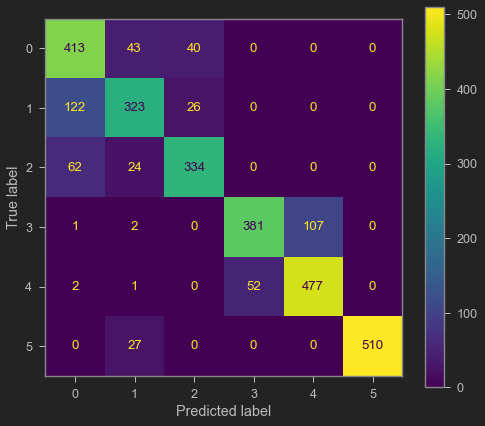

In [30]:
# Mean + STD
display_metrics(y_test_df, prediction)

In [18]:
# Mean + STD + Skew + Kurtosis
display_metrics(y_test_df, prediction)

              precision    recall  f1-score   support

         0.0       0.72      0.75      0.74       496
         1.0       0.77      0.73      0.75       471
         2.0       0.84      0.90      0.87       420
         3.0       0.88      0.78      0.83       491
         4.0       0.82      0.89      0.85       532
         5.0       1.00      0.97      0.98       537

    accuracy                           0.84      2947
   macro avg       0.84      0.84      0.84      2947
weighted avg       0.84      0.84      0.84      2947


ROC-AUC Score: 0.978
